In [1]:
import pandas as pd
import requests
from io import StringIO
import copy
from tqdm.notebook import tqdm
from datetime import datetime
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error,classification_report,make_scorer,confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Lasso, ElasticNet, Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from scipy.stats import poisson
import matplotlib.pyplot as plt
import os
import pickle




In [2]:
teams_dict = {
    'Arsenal': ['Arsenal', 'ARS'],
    'Aston Villa': ['Aston Villa', 'AVL', 'AstonVilla', 'Villa'],
    'Barnsley': ['Barnsley', 'BAR'],
    'Birmingham City': ['Birmingham City', 'Birmingham', 'BIR'],
    'Blackburn Rovers': ['Blackburn Rovers', 'Blackburn', 'BLA'],
    'Blackpool': ['Blackpool', 'BLP'],
    'Bolton Wanderers': ['Bolton Wanderers', 'Bolton', 'BOL'],
    'Bournemouth': ['Bournemouth', 'BOU'],
    'Bradford City': ['Bradford City', 'Bradford', 'BFD'],
    'Brentford': ['Brentford', 'BRE'],
    'Brighton': ['Brighton & Hove Albion', 'Brighton', 'BHA', 'Brighton and Hove Albion'],
    'Burnley': ['Burnley', 'BUR'],
    'Cardiff City': ['Cardiff City', 'Cardiff', 'CAR'],
    'Charlton Athletic': ['Charlton Athletic', 'Charlton', 'CHA'],
    'Chelsea': ['Chelsea', 'CHE'],
    'Coventry City': ['Coventry City', 'Coventry', 'COV'],
    'Crystal Palace': ['Crystal Palace', 'CRY', 'CrystalPalace'],
    'Derby County': ['Derby County', 'Derby', 'DER'],
    'Everton': ['Everton', 'EVE'],
    'Fulham': ['Fulham', 'FUL'],
    'Huddersfield Town': ['Huddersfield Town', 'Huddersfield', 'HUD'],
    'Hull City': ['Hull City', 'Hull', 'HUL'],
    'Ipswich Town': ['Ipswich Town', 'Ipswich', 'IPS'],
    'Leeds United': ['Leeds United', 'Leeds', 'LEE'],
    'Leicester City': ['Leicester City', 'Leicester', 'LEI'],
    'Liverpool': ['Liverpool', 'LIV'],
    'Manchester City': ['Manchester City', 'Man City', 'MCI', 'ManCity'],
    'Manchester United': ['Manchester United', 'Man Utd', 'ManUnited', 'Man United', 'MUN'],
    'Middlesbrough': ['Middlesbrough', 'MID'],
    'Newcastle United': ['Newcastle United', 'Newcastle', 'NEW'],
    'Norwich City': ['Norwich City', 'Norwich', 'NOR', 'NorwichCity'],
    'Nottingham Forest': ['Nottingham Forest', 'Nottm Forest', 'NTF'],
    'Oldham Athletic': ['Oldham Athletic', 'Oldham', 'OLD'],
    'Portsmouth': ['Portsmouth', 'POR'],
    'Queens Park Rangers': ['Queens Park Rangers', 'QPR'],
    'Reading': ['Reading', 'RDG'],
    'Sheffield United': ['Sheffield United', 'Sheffield Utd', 'SU', 'SheffieldUnited'],
    'Sheffield Wednesday': ['Sheffield Wednesday', 'Sheffield Wed', 'SW', 'SheffieldWednesday'],
    'Southampton': ['Southampton', 'SOU'],
    'Stoke City': ['Stoke City', 'Stoke', 'STK'],
    'Sunderland': ['Sunderland', 'SUN'],
    'Swansea City': ['Swansea City', 'Swansea'],
    'Swindon Town': ['Swindon Town', 'SWI'],
    'Tottenham Hotspur': ['Tottenham Hotspur', 'Tottenham', 'TOT', 'Spurs'],
    'Watford': ['Watford', 'WAT'],
    'West Bromwich Albion': ['West Bromwich Albion', 'West Brom','WestBrom','WBA'],
    'West Ham United': ['West Ham United', 'West Ham', 'WHU', 'WestHam'],
    'Wigan Athletic': ['Wigan Athletic','WiganAthletic' ,'Wigan', 'WIG'],
    'Wimbledon': ['Wimbledon', 'WIM'],
    'Wolverhampton Wanderers': ['Wolverhampton Wanderers', 'Wolves', 'WOL']
}

columns = ['Home','Away','elo_0', 'points_0', 'side', 'Average_xG_0',
       'Average_xAG_0', 'Average_Scored_0', 'Average_Conceded_0', 'points_1',
       'elo_1', 'Average_xAG_1', 'Average_Scored_1', 'Average_Conceded_1',
       'Goals_Scored_0']
# create a list for each team
arsenal = teams_dict['Arsenal']
aston_villa = teams_dict['Aston Villa']
brentford = teams_dict['Brentford']
brighton = teams_dict['Brighton']
burnley = teams_dict['Burnley']
chelsea = teams_dict['Chelsea']
crystal_palace = teams_dict['Crystal Palace']
everton = teams_dict['Everton']
leeds_united = teams_dict['Leeds United']
leicester_city = teams_dict['Leicester City']
liverpool = teams_dict['Liverpool']
manchester_city = teams_dict['Manchester City']
manchester_united = teams_dict['Manchester United']
newcastle_united = teams_dict['Newcastle United']
norwich_city = teams_dict['Norwich City']
southampton = teams_dict['Southampton']
tottenham_hotspur = teams_dict['Tottenham Hotspur']
watford = teams_dict['Watford']
west_ham_united = teams_dict['West Ham United']
wolves = teams_dict['Wolverhampton Wanderers']

def find_team_number(team_name_):
    for i, team_list in enumerate(teams_dict.values()):
        if team_name_.lower() in [x.lower() for x in team_list]:
            return i
    return -1 # Return -1 if no match is found
def convert_date(date_str):
    # convert string to datetime object
    date_obj = datetime.strptime(date_str, '%d-%b-%Y')
    # convert datetime object to string in desired format
    return date_obj.strftime('%Y-%m-%d')
def get_result(result):
    result_list = result.split(":")
    if int(result_list[0])>int(result_list[1]):
        return 0 
    elif int(result_list[0])< int(result_list[1]):
        return 2
    else:
        return 1
def odds_result(win_h,draw,win_a):
    odds_list = [win_h,draw,win_a]
    return odds_list.index(min(odds_list))
def returnSide(home,away,team):
    if home==team:
        return 'home'
    else:
        return 'away'
def getGoals(result,side,kind='scored'):
    goals_list = result.split(":")
    if side=='home' and kind == 'scored':
        return goals_list[0]
    elif side =='away' and kind =='scored':
        return goals_list[1]
    elif side =='home' and kind =='conceded':
        return goals_list[1]
    elif side=='away' and kind =='conceded':
        return goals_list[0]
        
def getSideNum(side):
    if side=='home':
        return 0
    else:
        return 1
        
def find_matching_game(num):
    if num % 2 == 0:
        return num + 1
    else:
        return num - 1

In [3]:
seasons = [2018,2019,2020,2021]

In [ ]:
combined_dict={}
for season in tqdm(seasons):
    print('Getting Data...')
    #Get Data
    df_fbref = pd.read_csv("/Users/moksh/PL Predictions/FbrefDfs/FBref{year}Season.csv".format(year=season))
    season_teams = list(df_fbref['Home Team'].unique())
    df_fbref['Home Team'] = df_fbref['Home Team'].apply(find_team_number)
    df_fbref['Away Team'] = df_fbref['Away Team'].apply(find_team_number)
    df_schedule = df_fbref[['Date','Home Team','Away Team','Home Goals','Away Goals']]
    df_schedule['Result'] = df_schedule.apply(lambda x:"{}:{}".format(x['Home Goals'],x['Away Goals']),axis=1)
    df_schedule = df_schedule.drop(['Home Goals','Away Goals'],axis=1)
    df_schedule.columns =['Date','HomeTeam','AwayTeam','Result']
    df_under = pd.read_csv("/Users/moksh/PL Predictions/UnderStatDfs/UnderStat{year}Season.csv".format(year=season))
    df_under['home team'] = df_under['home team'].apply(find_team_number)
    df_under['away team'] = df_under['away team'].apply(find_team_number)
    
    
    print('Getting Expected Goals...')
    #Get expected goals and expected conceded goals
    teams_fbref = df_fbref['Home Team'].unique()
    fbref_dicts = {}
    for team in teams_fbref:
        fbref_dicts[team]= df_fbref[(df_fbref['Home Team'] == team) | (df_fbref['Away Team'] == team)][['Home Team','Away Team','Home xG','Away xG', 'Home xAG', 'Away xAG']]

    xgs_dict = {}
    for team in fbref_dicts.keys():
        team_xg =[]
        team_xag = []
        team_df = copy.deepcopy(fbref_dicts[team])
        for i,row in team_df.iterrows():
            if team_df['Home Team'][i] == team:
                team_xg.append(team_df['Home xG'][i])
                team_xag.append(team_df['Away xG'][i])
            else:
                team_xg.append(team_df['Away xG'][i])
                team_xag.append(team_df['Home xG'][i])
        team_df['Team'] = [team]*38
        team_df['Team xG'] = team_xg
        team_df['Team xAG'] = team_xag
        team_df = team_df.drop(['Home xG','Away xAG', 'Away xG', 'Home xAG'], axis = 1).reset_index().drop('index', axis=1)


        xgs_dict[team] = team_df
        
        
    #Get expected PPDA
    print('Getting PPDA...')

    under_teams = df_under['home team'].unique()
    under_dicts = {}
    for team in under_teams:
        under_dicts[team]= df_under[(df_under['home team'] == team) | (df_under['away team'] == team)][['home team','away team','home PPDA','away PPDA',]]

    ppda_dicts = {}
    for team in under_dicts.keys():
        team_ppda =[]
        team_df = copy.deepcopy(under_dicts[team])
        for i,row in team_df.iterrows():
            if team_df['home team'][i] == team:
                team_ppda.append(team_df['home PPDA'][i])
            else:
                team_ppda.append(team_df['away PPDA'][i])
        team_df['Team'] = [team]*38
        team_df['Team ppda'] = team_ppda



        ppda_dicts[team] = team_df.drop(['home PPDA','away PPDA'],axis=1).reset_index().drop('index', axis=1)
        
    print('Getting FPL Data...')
    #Get FPL data
    fpl_rows = []
    for i in range(1,39):
        try:
            fpl =pd.read_csv('/Users/moksh/PL Predictions/FPL/{year}GW/gw{week}.csv'.format(year=season, week=i))
        except:            
            fpl =pd.read_csv('/Users/moksh/PL Predictions/FPL/{year}GW/gw{week}.csv'.format(year=season, week=i),encoding= "iso-8859-1")
            


            fpl['team'] = fpl['team'].apply(find_team_number)

        fpl_rows.append(dict(fpl.groupby("team").sum()['total_points']))
        
    df_fpl = pd.DataFrame(fpl_rows,index=range(1,39))
    df_fpl.fillna(method= 'backfill', inplace = True)
    
    
    print('Getting ELO...')
    #Get Club ELOs
    elo_dict = {}
    for team_list_name in tqdm(teams_dict.keys()):
        teams = teams_dict[team_list_name]
        for team in teams:
            try:
                r = requests.get('http://api.clubelo.com/{}'.format(team))
                data = StringIO(r.text)
                df_elo = pd.read_csv(data, sep=",")
                if(len(df_elo)>0):
                    elo_dict[find_team_number(team_list_name)] = df_elo
                    pass
                    break
                else:
                    pass

            except:
                pass




    print('Creating Team Dicts...')
    #Dicts for Each Team
    full_teams_dict = {}
    for team in season_teams:
        team_number = find_team_number(team)
        df_xgs = xgs_dict[team_number]
        df_ppda = ppda_dicts[team_number]
        ppdas = []
        dates = []
        elos = []
        points = []
        results = []
        for i,row in df_xgs.iterrows():
            ppdas.append(df_ppda[(df_ppda['home team'] == row['Home Team']) & (df_ppda['away team'] == row['Away Team'])]['Team ppda'].values[0])
            dates.append(df_schedule[(df_schedule['HomeTeam'] == row['Home Team']) & (df_schedule['AwayTeam'] == row['Away Team'])]['Date'].values[0])
            try:
                new_cols = []
                for col in list(df_fpl.columns):
                    new_cols.append(find_team_number(col))
                df_fpl.columns = new_cols
            except:
                pass
            points.append(df_fpl[team_number][i+1])
            results.append(df_schedule[(df_schedule['HomeTeam'] == row['Home Team']) & (df_schedule['AwayTeam'] == row['Away Team'])]['Result'].values[0])


        df_xgs['ppda'] = ppdas
        df_xgs['dates'] = dates
        df_xgs['points'] = points
        df_xgs['points']= df_xgs['points'].rolling(window=4, min_periods=1).mean().shift(1)
        df_xgs['result'] = results




        for i,row in df_xgs.iterrows():
            elos.append(elo_dict[team_number][(row['dates'] >= elo_dict[team_number]['From'])&(row['dates'] <= elo_dict[team_number]['To'])]['Elo'].values[0])




        df_xgs['elo'] = elos
        df_xgs['side'] = df_xgs.apply(lambda X:returnSide(X['Home Team'],X['Away Team'],X['Team']),axis=1)
        df_xgs['Goals_Scored'] = df_xgs.apply(lambda X:getGoals(X.result, X.side, 'scored'), axis=1)
        df_xgs['Goals_Conceded'] = df_xgs.apply(lambda X:getGoals(X.result, X.side, 'conceded'), axis=1)
        df_xgs['Average_Scored'] =df_xgs['Goals_Scored'].rolling(window=7, min_periods=1).mean().shift(1)
        df_xgs['Average_Conceded'] =df_xgs['Goals_Conceded'].rolling(window=7, min_periods=1).mean().shift(1)
        df_xgs['Average_xG'] =df_xgs['Team xG'].rolling(window=7, min_periods=1).mean().shift(1)
        df_xgs['Average_xAG'] =df_xgs['Team xAG'].rolling(window=7, min_periods=1).mean().shift(1)
        df_xgs.fillna(method='backfill', inplace=True)




        full_teams_dict[team_number] = df_xgs

    
    #Combine
    full_game_df = pd.concat(full_teams_dict.values(), ignore_index=True)
    
    print('Getting Game Pairs...')
    #Get Game Pairs
    game_pairs = []
    for i,row in tqdm(full_game_df.iterrows()):
        for k,row_k in full_game_df.iloc[i:].iterrows():
            if row['Home Team'] == row_k['Home Team'] and row['Away Team'] == row_k['Away Team']:
                if i!=k:
                    game_pairs.append((i,k))


    #Match the Games
    rows_new_df=[]
    for game_pair in game_pairs:
        game_1 = game_pair[0]
        game_2= game_pair[1]
        home_team = full_game_df.iloc[game_1]['Home Team']
        away_team = full_game_df.iloc[game_1]['Away Team']
        if full_game_df.iloc[game_1]["Team"] == home_team:
            new_tuple = [full_game_df.iloc[game_1].add_suffix('_h'),full_game_df.iloc[game_2].add_suffix('_a')] 
            rows_new_df.append(pd.concat([new_tuple[0],new_tuple[1]]))


        else:
            new_tuple = [full_game_df.iloc[game_1].add_suffix('_a'),full_game_df.iloc[game_2].add_suffix('_h')]
            rows_new_df.append(pd.concat([new_tuple[1],new_tuple[0]]))

    new_full_df = pd.DataFrame(rows_new_df)   
    

    #Make One Big DataFrame
    rows_list_1=[]
    rows_list_2 = []
    for i,row in new_full_df.iterrows():
        new_row_1 = row[['Home Team_h','Away Team_h',"elo_h",'points_h','side_h','Average_xG_h','Average_xAG_h','Average_Scored_h', 'Average_Conceded_h',
                        'points_a', 'elo_a','Average_xAG_a', 'Average_Scored_a', 'Average_Conceded_a','Goals_Scored_h']].to_dict()
        new_row_2 = row[['Home Team_a','Away Team_a',"elo_a",'points_a','side_a','Average_xG_a','Average_xAG_a','Average_Scored_a', 'Average_Conceded_a',
                        'points_h', 'elo_h','Average_xAG_h', 'Average_Scored_h', 'Average_Conceded_h','Goals_Scored_a']].to_dict()
        rows_list_1.append(new_row_1)
        rows_list_2.append(new_row_2)

    #Create Large DF and Filter Out Rows
    df_1 = pd.DataFrame(rows_list_1)
    df_2 = pd.DataFrame(rows_list_2)

    df_1.columns= columns
    df_2.columns=columns
    full_training_df=pd.concat([df_1,df_2], axis=0).reset_index(drop=True)
    full_training_df['side'] = full_training_df['side'].apply(getSideNum)
    full_training_df['elo_diff'] = full_training_df['elo_0'] - full_training_df['elo_1']
    #full_training_df.drop(['elo_0','elo_1'], axis = 1,inplace = True)
    
    
    
    
    combined_dict[season] = full_training_df
    
    
    
    

  



  0%|          | 0/4 [00:00<?, ?it/s]

Getting Data...
Getting Expected Goals...
Getting PPDA...
Getting FPL Data...


/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_11285/3709107943.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_schedule['Result'] = df_schedule.apply(lambda x:"{}:{}".format(x['Home Goals'],x['Away Goals']),axis=1)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_11285/3709107943.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fpl_rows.append(dict(fpl.groupby("team").sum()['total_points']))
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_11285/3709107943.py:83: FutureWarning: The default value of numeric_only in

Getting ELO...


/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_11285/3709107943.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fpl_rows.append(dict(fpl.groupby("team").sum()['total_points']))
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_11285/3709107943.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fpl_rows.append(dict(fpl.groupby("team").sum()['total_points']))
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_11285/3709107943.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. 

  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
with open('training_dict.pickle', 'wb') as handle:
    pickle.dump(combined_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#create classifier based on betting odds, then add elo

In [185]:
X= full_training_df.drop('Goals_Scored_0',axis=1)
y= full_training_df['Goals_Scored_0']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.1)

In [1325]:
param_grid = {
    'n_estimators': [1,5,10, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create a Random Forest Regressor object
rf = RandomForestRegressor(random_state=42)

# Create a GridSearchCV object and fit to the data
grid_search = GridSearchCV(scoring = scorer, estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best Score:  -1.1548712346268217


In [3]:
with open('training_df_dict.pickle', 'rb') as handle:
    full_training_dict = pickle.load(handle)

In [6]:
full_training_dict.keys()

dict_keys([2018, 2019, 2020, 2021])

In [8]:
full_training_df = pd.concat(list(full_training_dict.values())[:3], axis=0)

In [10]:
test_df= full_training_dict[2021]

In [ ]:
X= full_training_df.drop('Goals_Scored_0',axis=1)
y= full_training_df['Goals_Scored_0']
total_error= 0
total_score= 0
for i in tqdm(range(100)):
    X_train, __, y_train, ___= train_test_split(X,y, test_size=0.0001)
    X_test = test_df.drop('Goals_Scored_0',axis=1)
    y_test = test_df['Goals_Scored_0']
    rfr= RandomForestRegressor(max_depth= 10, max_features="sqrt", min_samples_leaf= 1, min_samples_split =10, n_estimators= 100)
    rfr.fit(X_train,y_train)
    test_preds =rfr.predict(X_test)
    train_preds = rfr.predict(X_train)
    total_error+=(np.sqrt(mean_squared_error(y_test,test_preds)))
    total_score+=(r2_score(y_test,test_preds))
print(total_error/100)
print(total_score/100)


  0%|          | 0/100 [00:00<?, ?it/s]

In [195]:
preds = list(test_preds) + list(train_preds)
outcomes = pd.concat([y_test,y_train])

In [196]:
distributions = []
for score in preds:
    
    lam = score

    # Create a Poisson distribution object
    x = np.arange(0, 15)
    poisson_dist = poisson(lam)


    # Calculate the CDF and PDF of the Poisson distribution
    cdf = poisson_dist.cdf(x)
    pmf = poisson_dist.pmf(x)
    distributions.append([cdf,pmf])
    
    


  0%|          | 0/3040 [00:00<?, ?it/s]

508 vs 509 Distributions
508    4
508    0
508    1
508    0
Name: Goals_Scored_0, dtype: object
509    2
509    0
509    3
509    0
Name: Goals_Scored_0, dtype: object


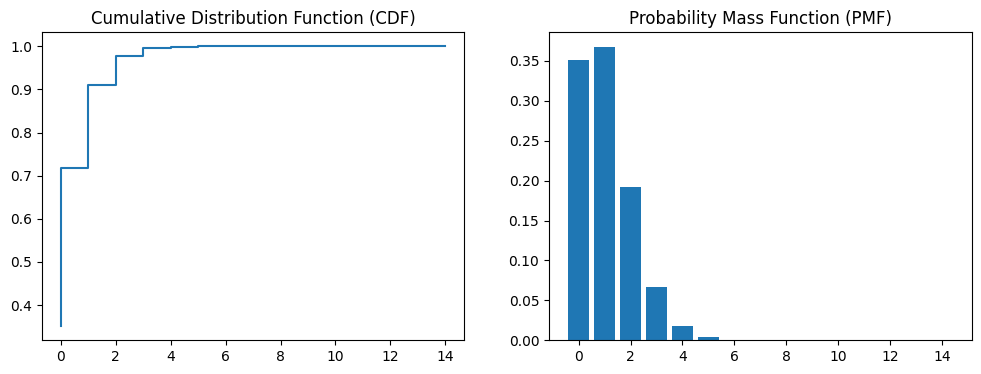

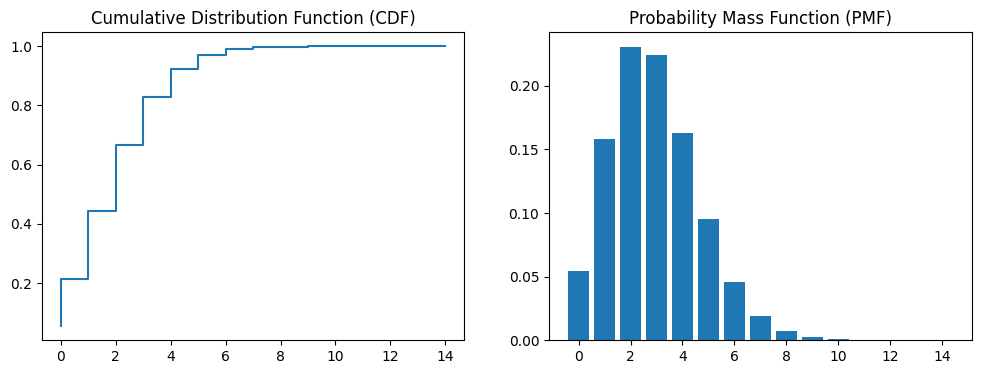



734 vs 735 Distributions
734    0
734    1
734    0
734    0
Name: Goals_Scored_0, dtype: object
735    0
735    3
735    1
735    0
Name: Goals_Scored_0, dtype: object


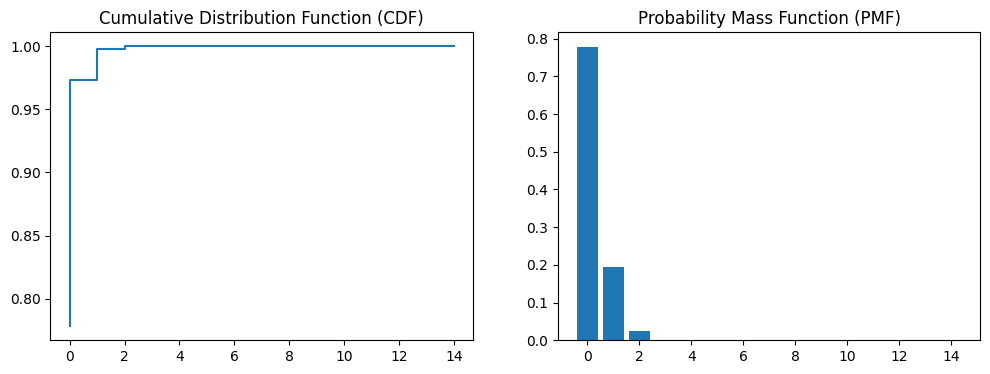

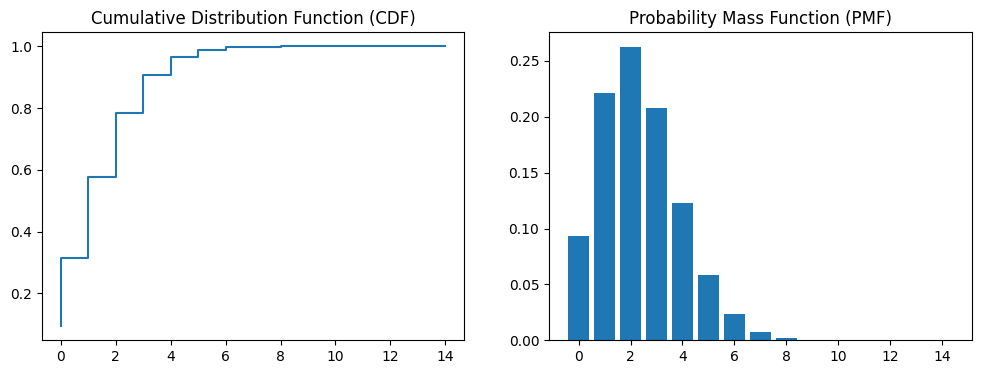



224 vs 225 Distributions
224    0
224    0
224    0
224    1
Name: Goals_Scored_0, dtype: object
225    0
225    5
225    2
225    3
Name: Goals_Scored_0, dtype: object


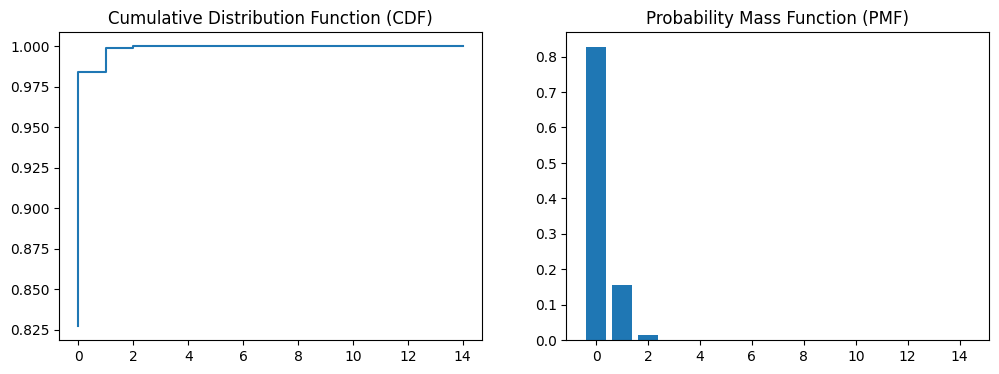

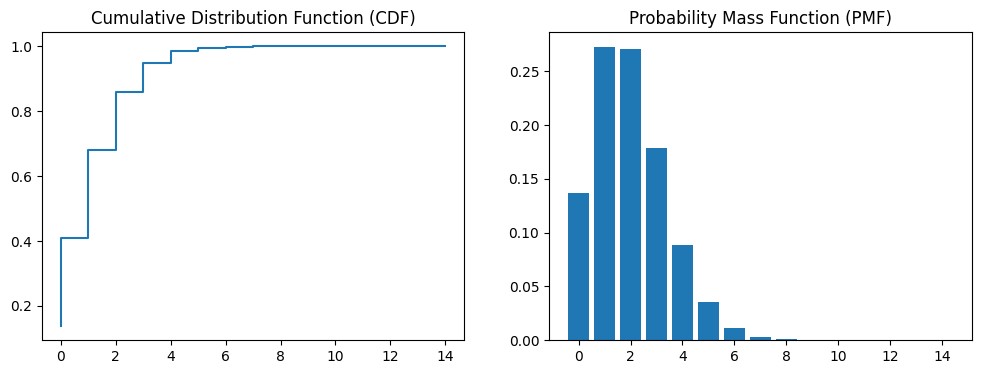



2 vs 3 Distributions
2    3
2    0
2    0
2    1
Name: Goals_Scored_0, dtype: object
3    0
3    1
3    0
3    0
Name: Goals_Scored_0, dtype: object


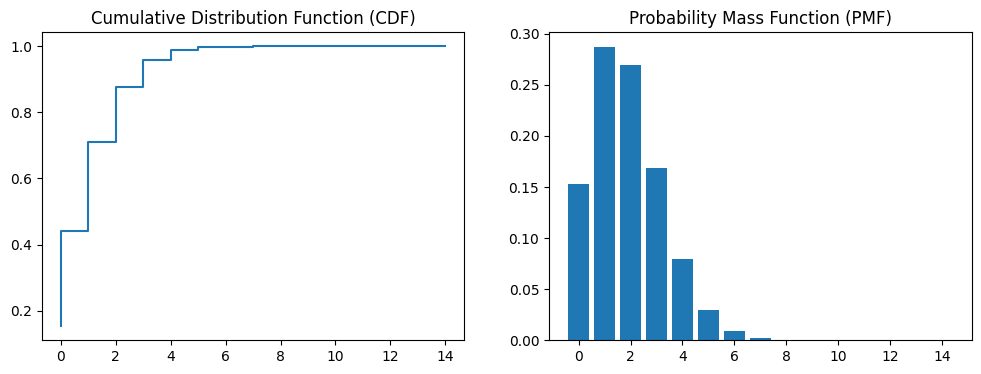

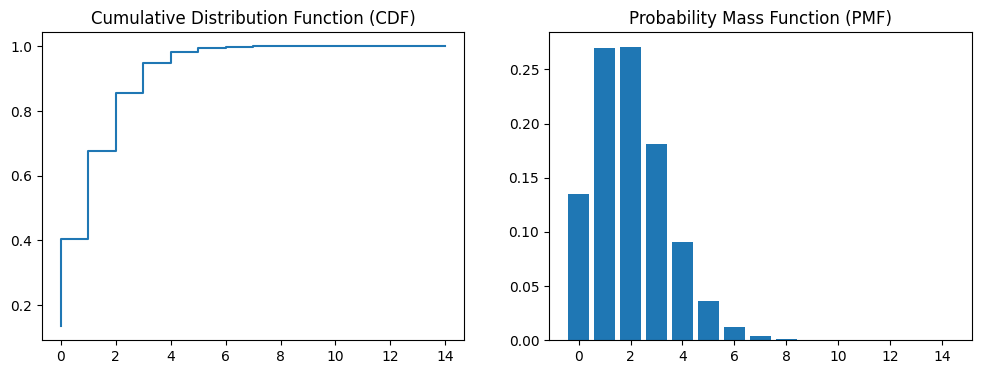



256 vs 257 Distributions
256    1
256    2
256    1
256    1
Name: Goals_Scored_0, dtype: object
257    3
257    1
257    1
257    2
Name: Goals_Scored_0, dtype: object


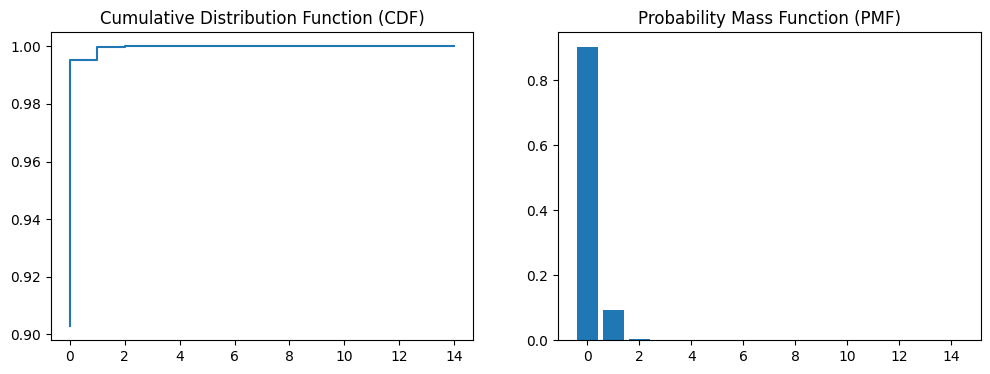

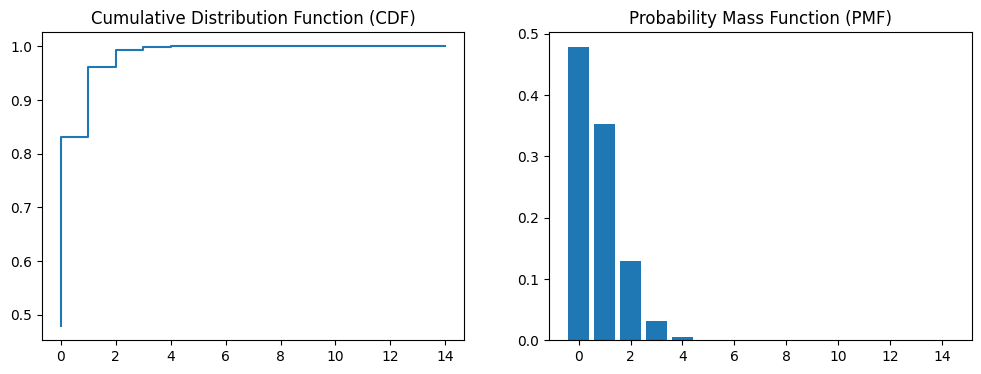



383 vs 382 Distributions
383    1
383    3
383    2
383    0
Name: Goals_Scored_0, dtype: object
382    3
382    1
382    3
382    1
Name: Goals_Scored_0, dtype: object


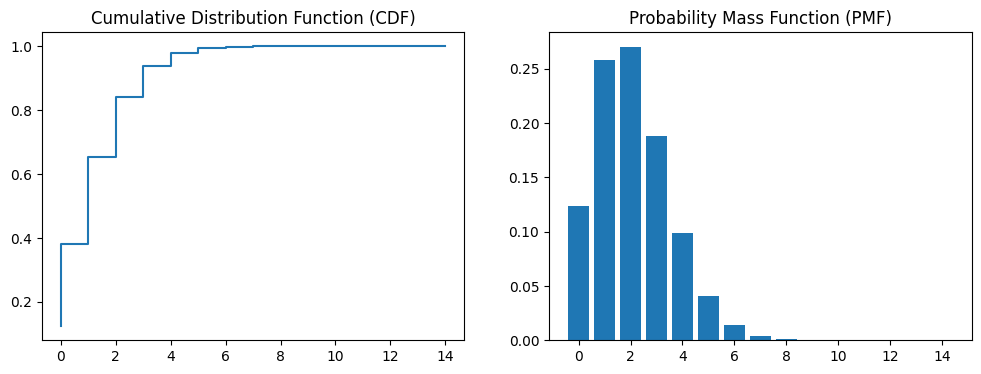

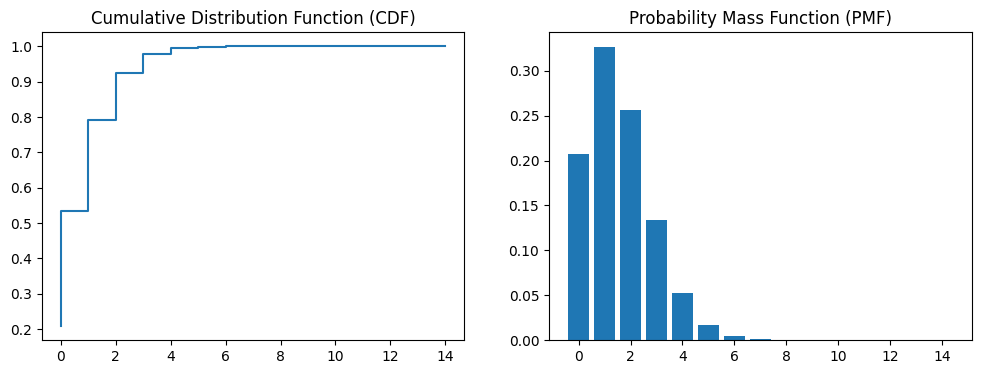



221 vs 220 Distributions
221    2
221    2
221    0
221    0
Name: Goals_Scored_0, dtype: object
220    3
220    1
220    2
220    1
Name: Goals_Scored_0, dtype: object


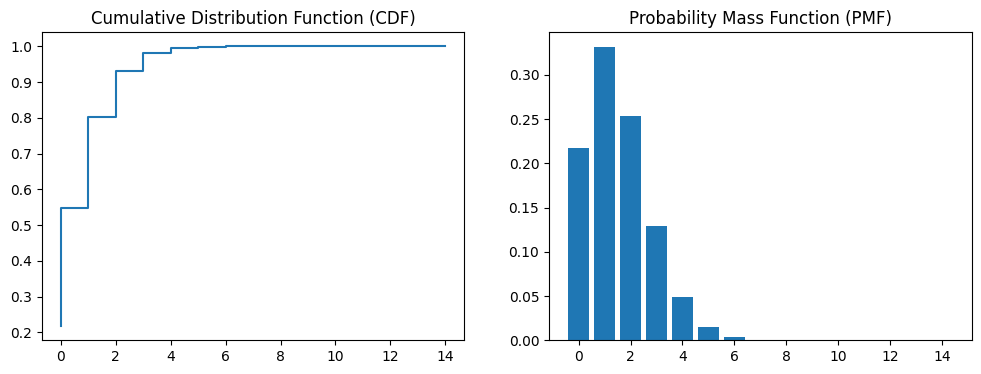

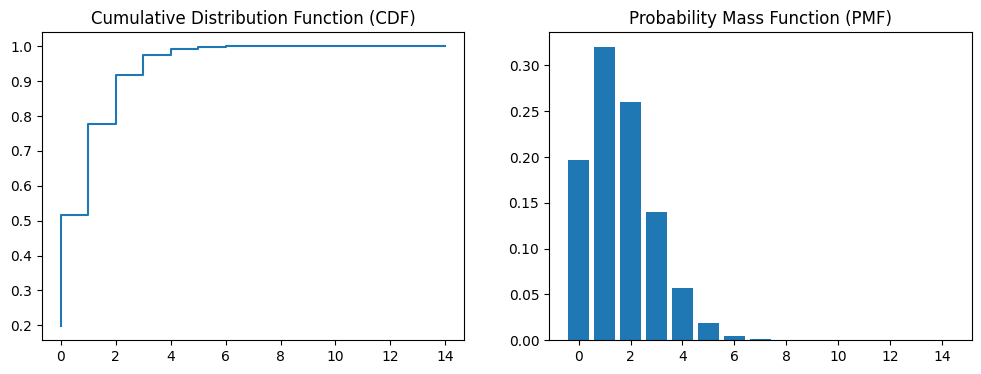



12 vs 13 Distributions
12    0
12    1
12    0
12    1
Name: Goals_Scored_0, dtype: object
13    2
13    2
13    2
13    1
Name: Goals_Scored_0, dtype: object


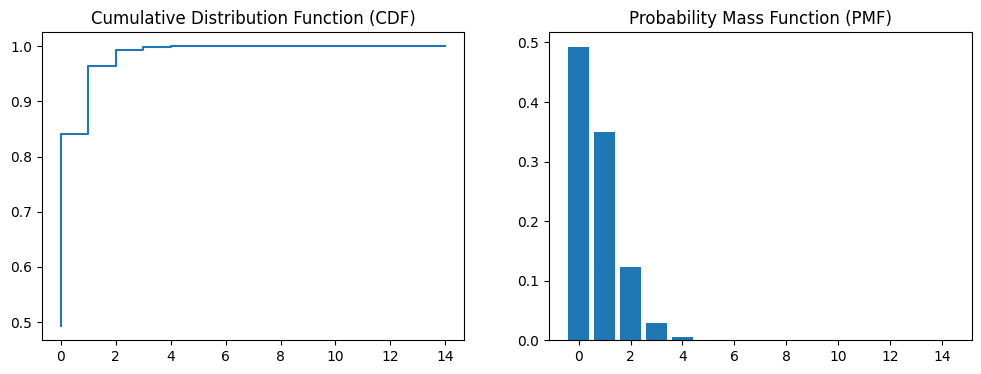

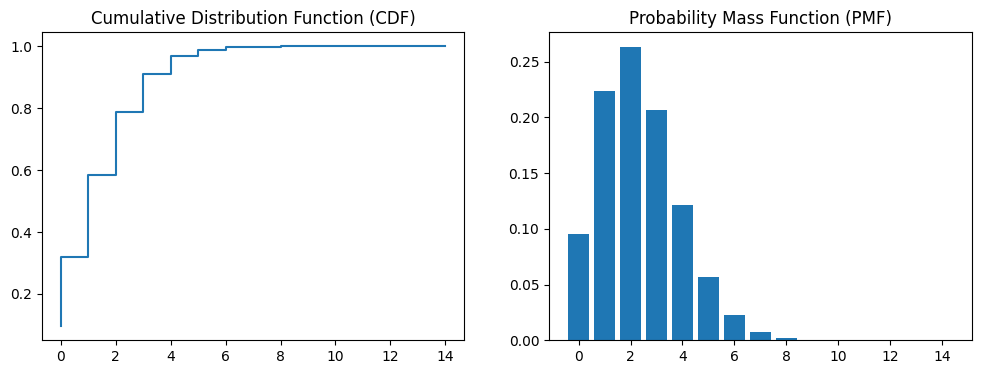



536 vs 537 Distributions
536    0
536    1
536    1
536    2
Name: Goals_Scored_0, dtype: object
537    1
537    2
537    0
537    0
Name: Goals_Scored_0, dtype: object


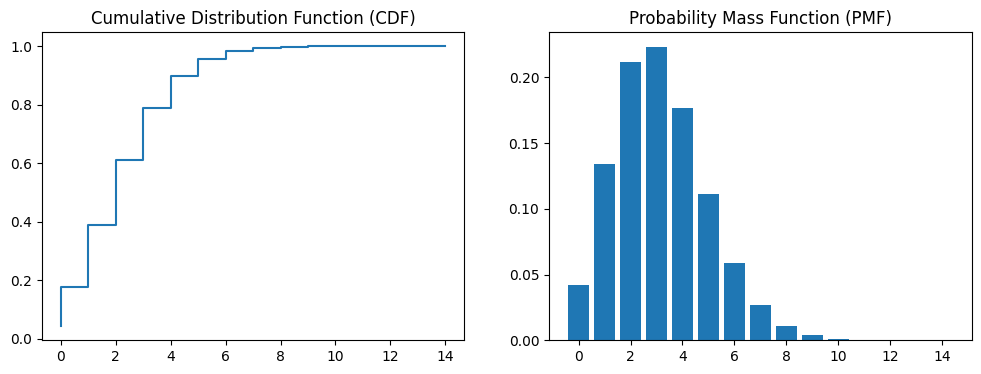

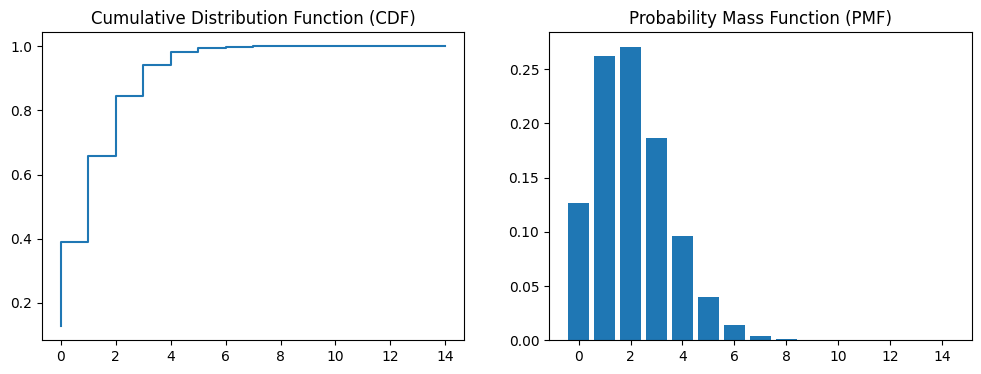



463 vs 462 Distributions
463    3
463    1
463    0
463    3
Name: Goals_Scored_0, dtype: object
462    2
462    0
462    1
462    4
Name: Goals_Scored_0, dtype: object


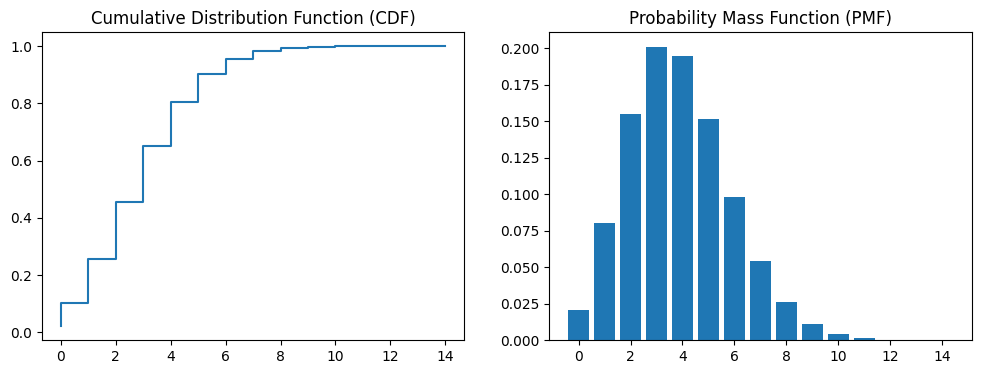

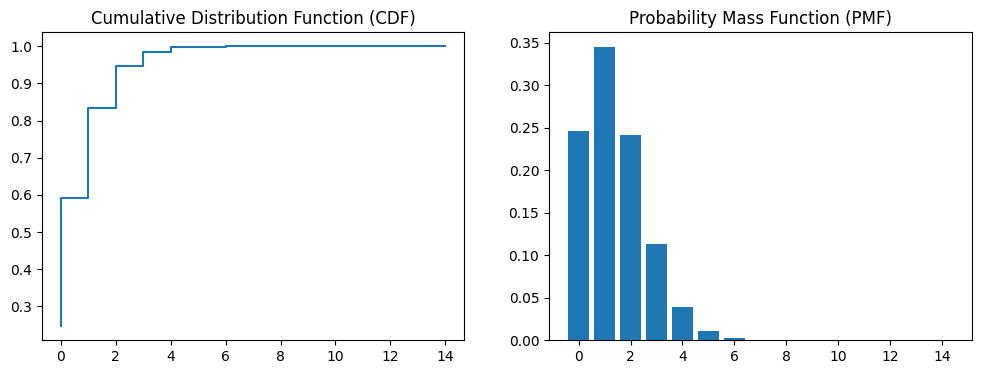



737 vs 736 Distributions
737    2
737    2
737    2
737    0
Name: Goals_Scored_0, dtype: object
736    0
736    0
736    0
736    2
Name: Goals_Scored_0, dtype: object


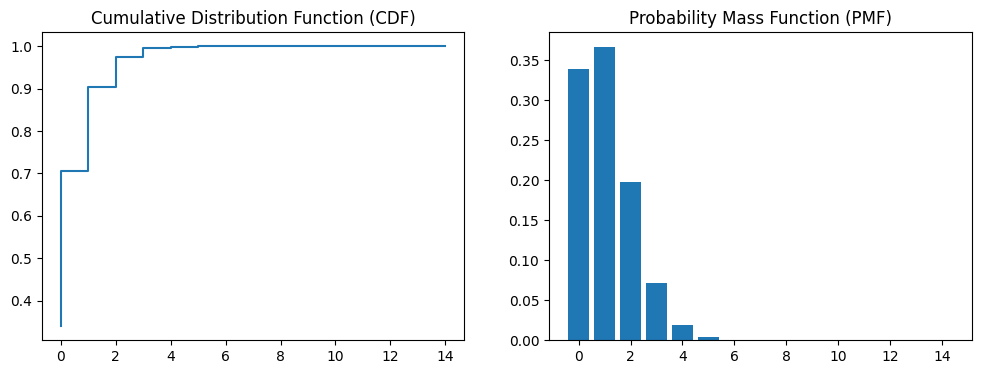

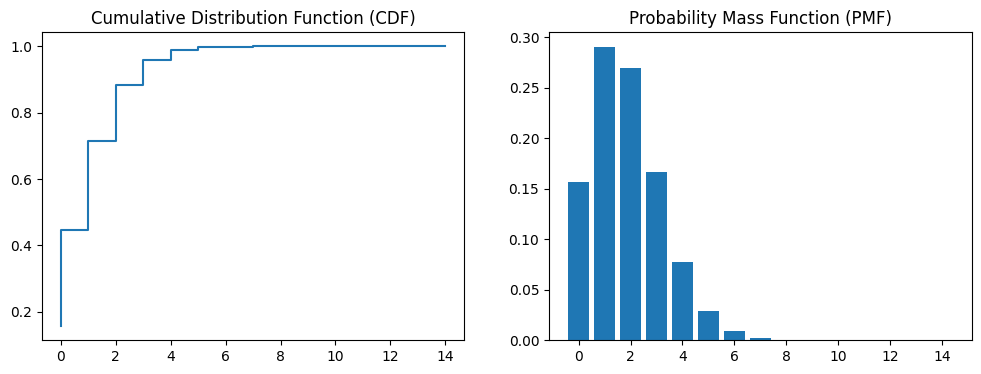



648 vs 649 Distributions
648    0
648    0
648    0
648    2
Name: Goals_Scored_0, dtype: object
649    2
649    2
649    0
649    2
Name: Goals_Scored_0, dtype: object


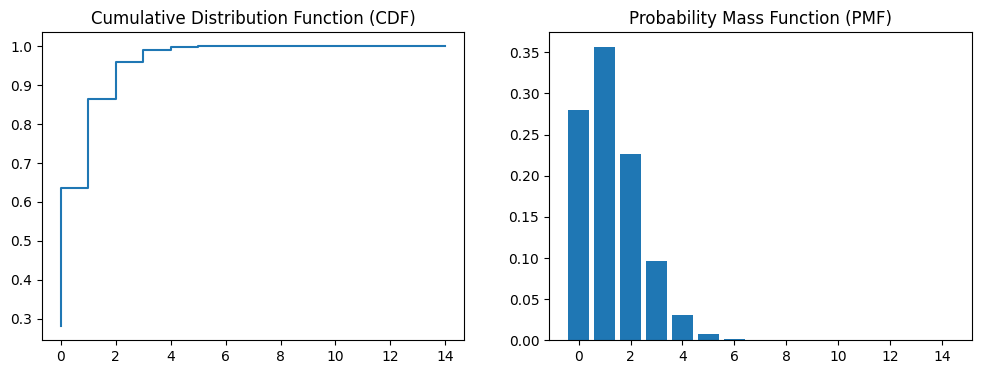

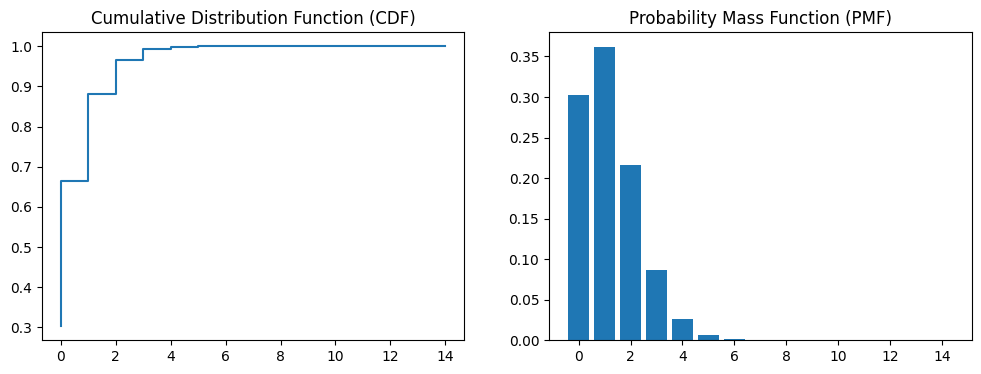



385 vs 384 Distributions
385    2
385    2
385    3
385    1
Name: Goals_Scored_0, dtype: object
384    1
384    2
384    2
384    1
Name: Goals_Scored_0, dtype: object


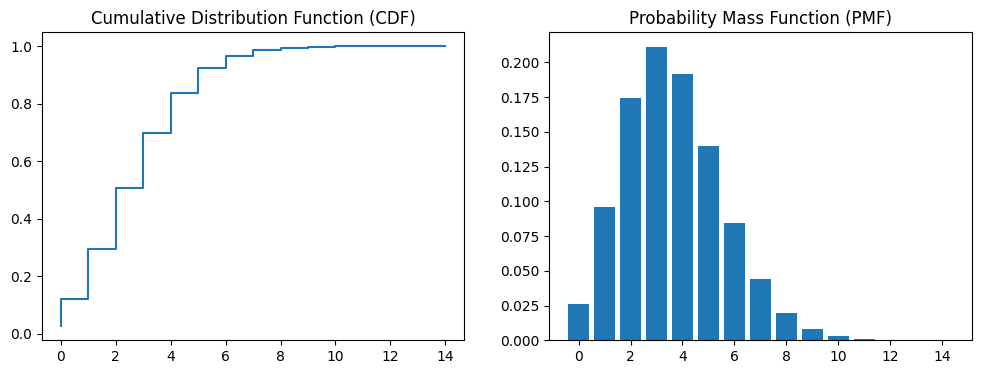

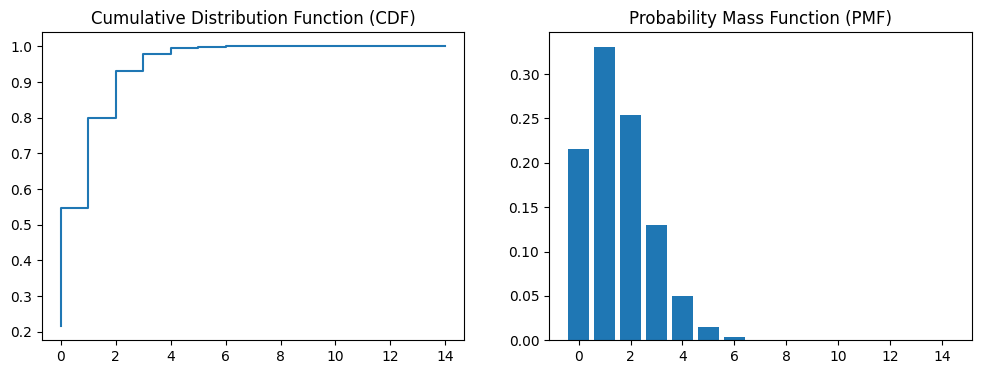



568 vs 569 Distributions
568    0
568    2
568    1
568    1
Name: Goals_Scored_0, dtype: object
569    2
569    2
569    2
569    4
Name: Goals_Scored_0, dtype: object


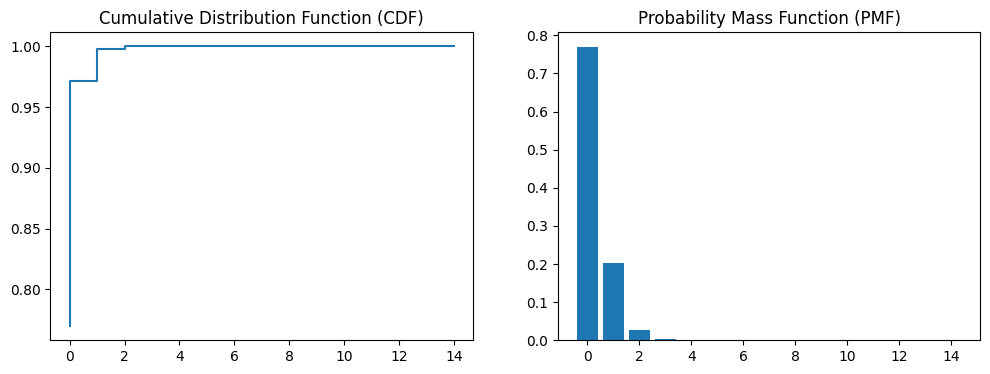

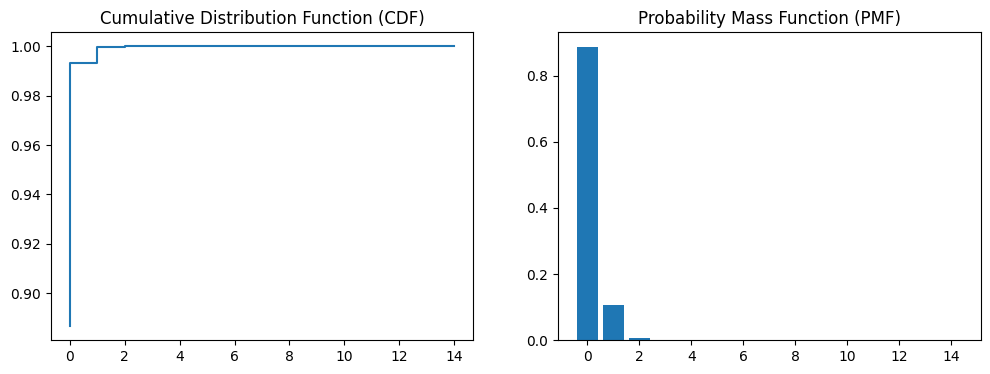



711 vs 710 Distributions
711    3
711    1
711    1
711    2
Name: Goals_Scored_0, dtype: object
710    3
710    1
710    0
710    3
Name: Goals_Scored_0, dtype: object


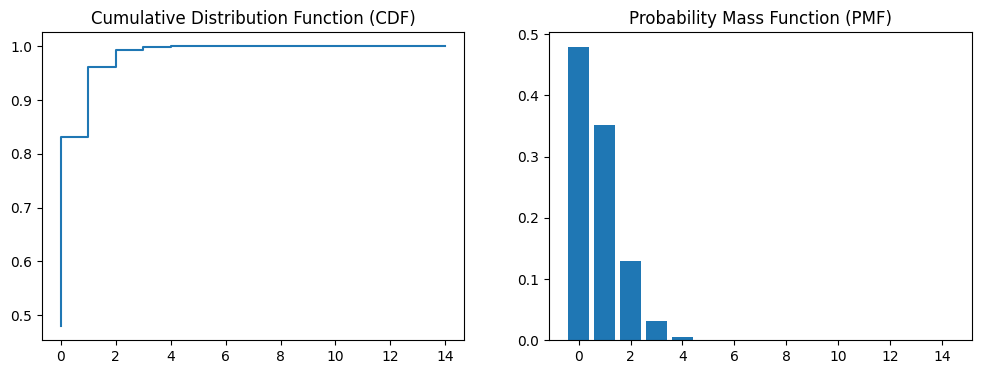

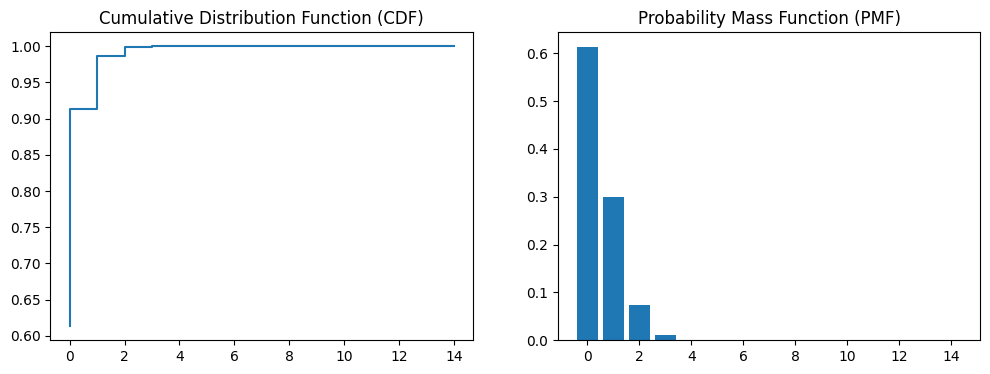



422 vs 423 Distributions
422    1
422    0
422    2
422    2
Name: Goals_Scored_0, dtype: object
423    1
423    0
423    0
423    0
Name: Goals_Scored_0, dtype: object


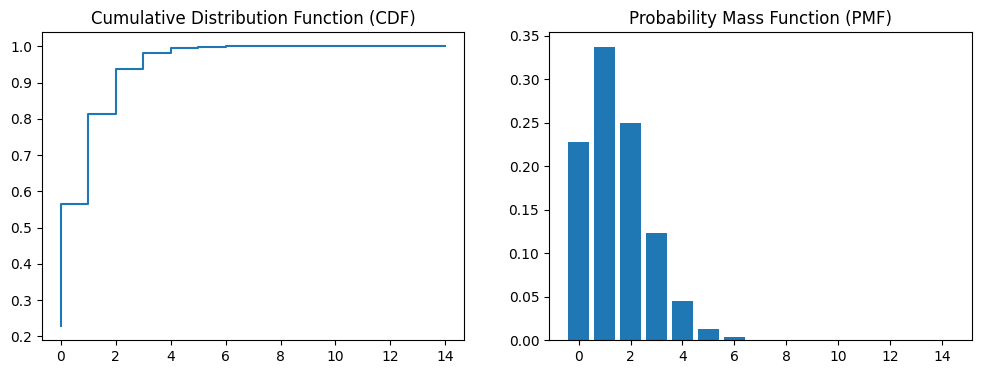

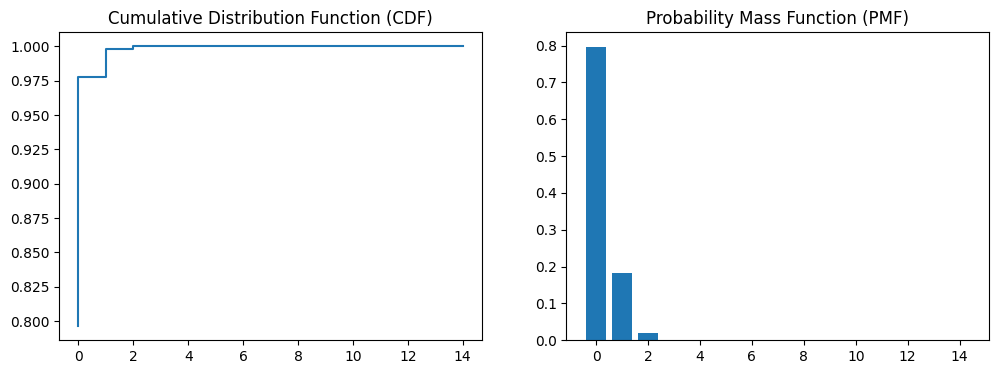



424 vs 425 Distributions
424    1
424    1
424    2
424    2
Name: Goals_Scored_0, dtype: object
425    1
425    2
425    2
425    0
Name: Goals_Scored_0, dtype: object


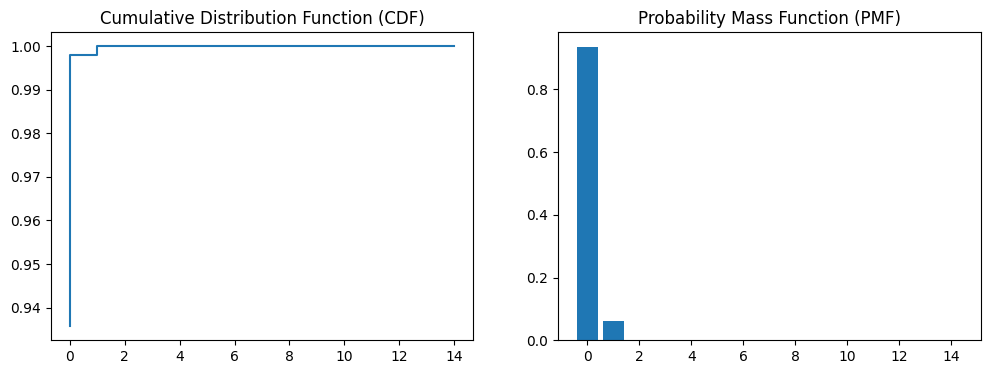

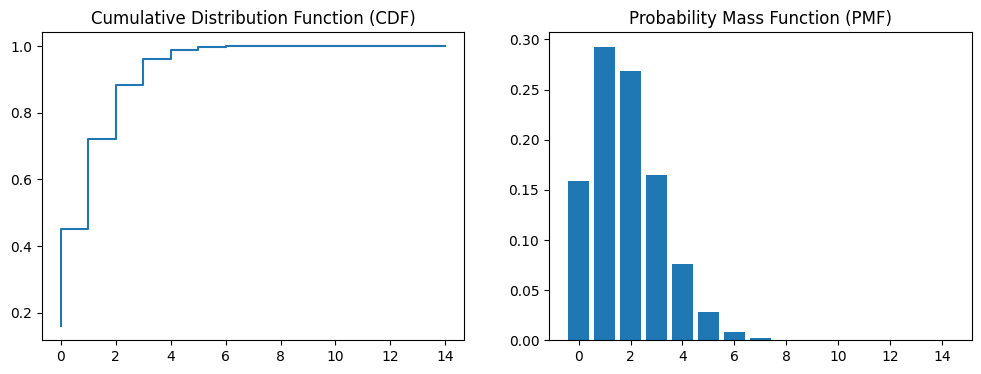



498 vs 499 Distributions
498    2
498    0
498    0
498    1
Name: Goals_Scored_0, dtype: object
499    2
499    1
499    1
499    0
Name: Goals_Scored_0, dtype: object


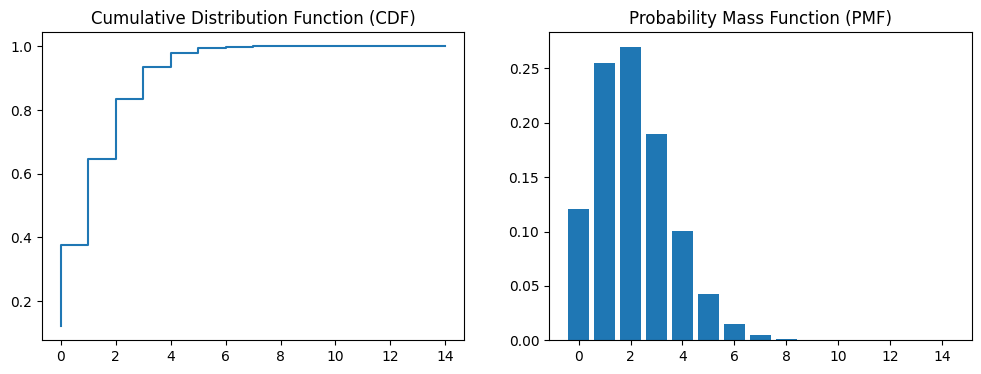

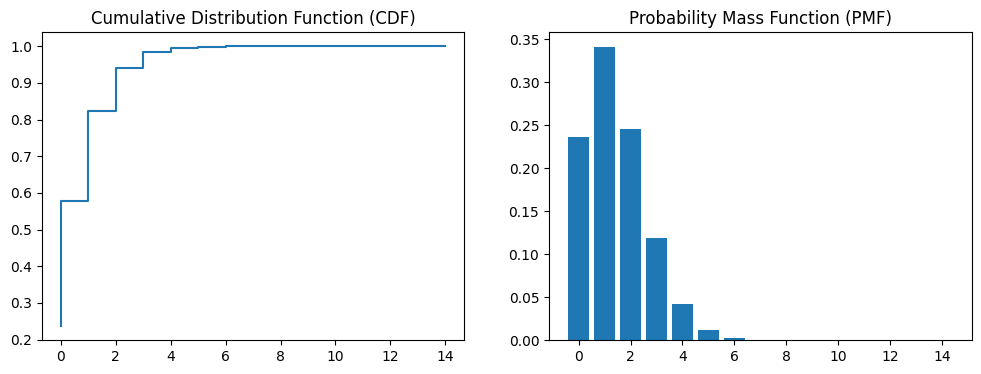



425 vs 424 Distributions
425    1
425    2
425    2
425    0
Name: Goals_Scored_0, dtype: object
424    1
424    1
424    2
424    2
Name: Goals_Scored_0, dtype: object


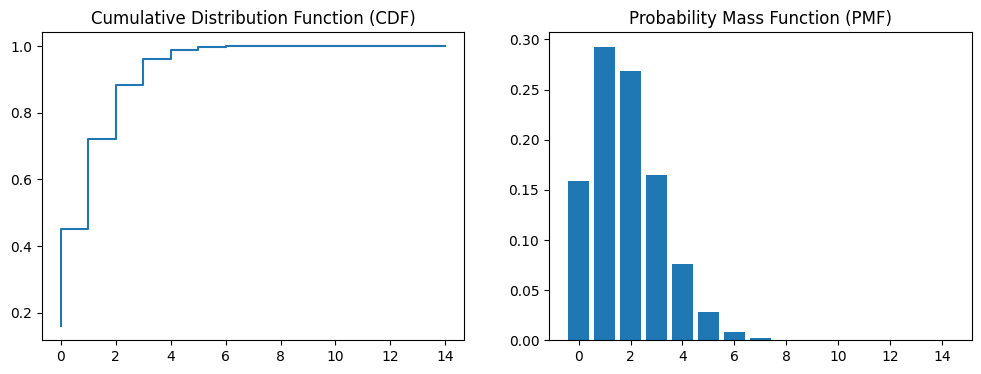

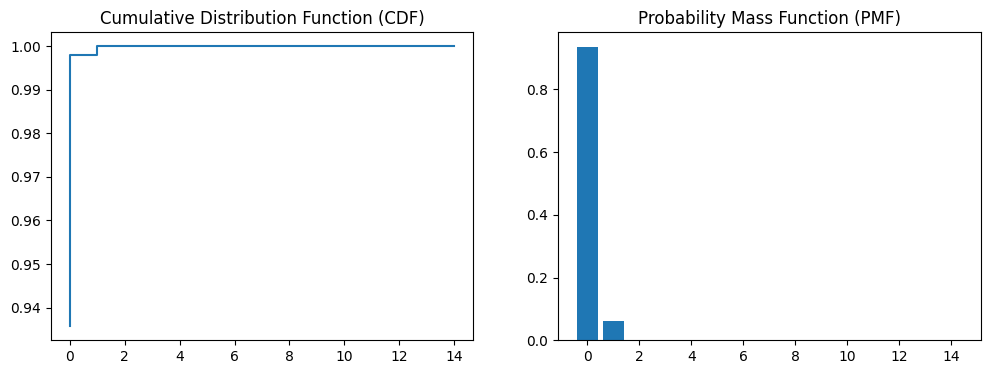



620 vs 621 Distributions
620    0
620    0
620    1
620    2
Name: Goals_Scored_0, dtype: object
621    1
621    0
621    1
621    1
Name: Goals_Scored_0, dtype: object


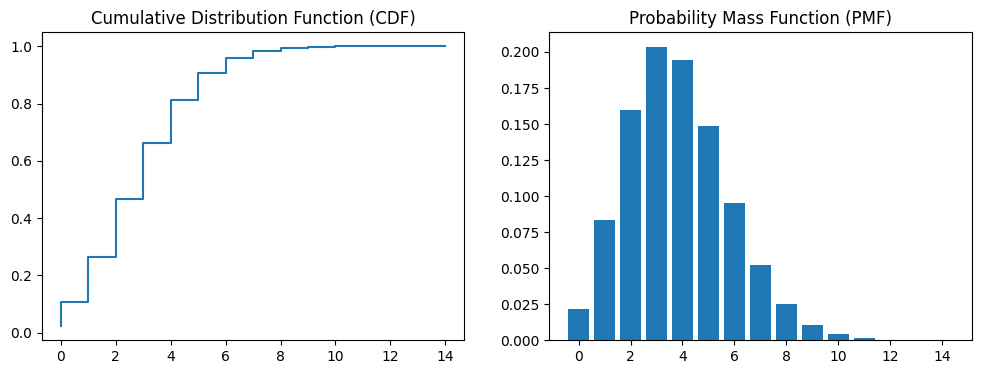

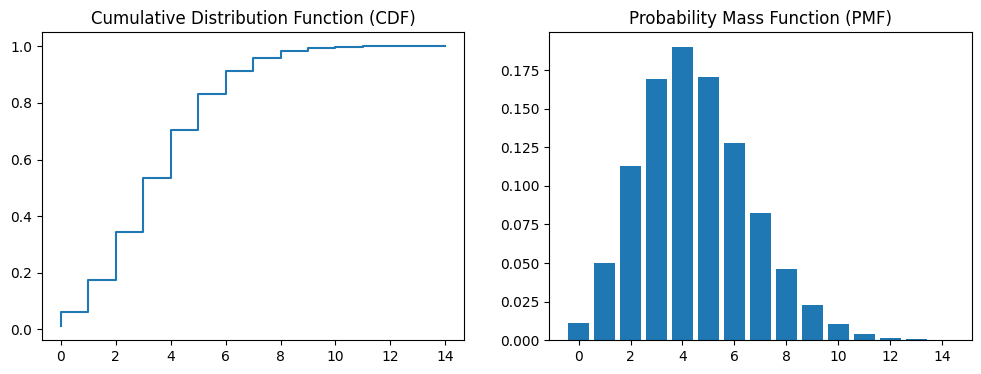



439 vs 438 Distributions
439    1
439    0
439    1
439    1
Name: Goals_Scored_0, dtype: object
438    0
438    0
438    0
438    2
Name: Goals_Scored_0, dtype: object


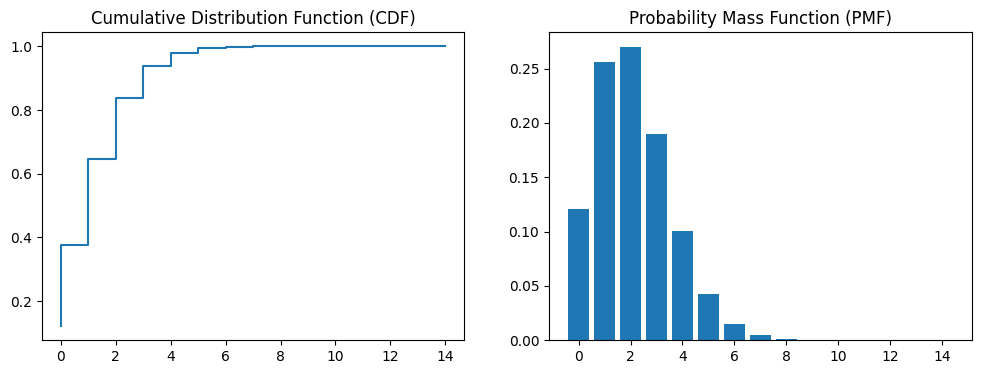

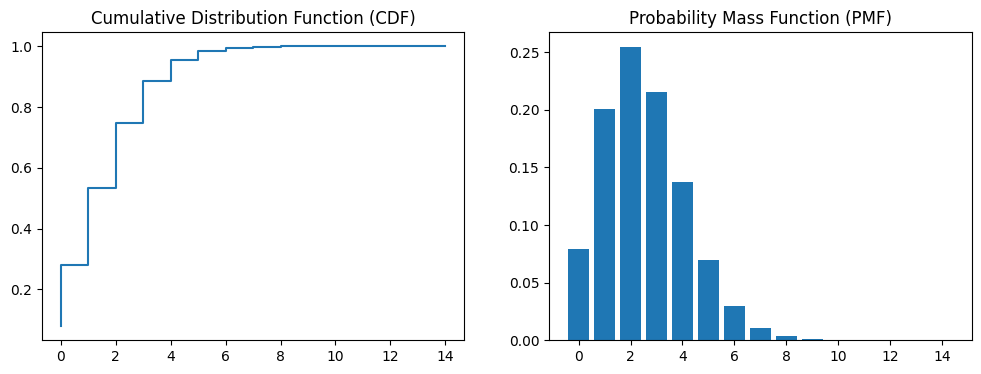



418 vs 419 Distributions
418    1
418    5
418    0
418    2
Name: Goals_Scored_0, dtype: object
419    1
419    1
419    3
419    0
Name: Goals_Scored_0, dtype: object


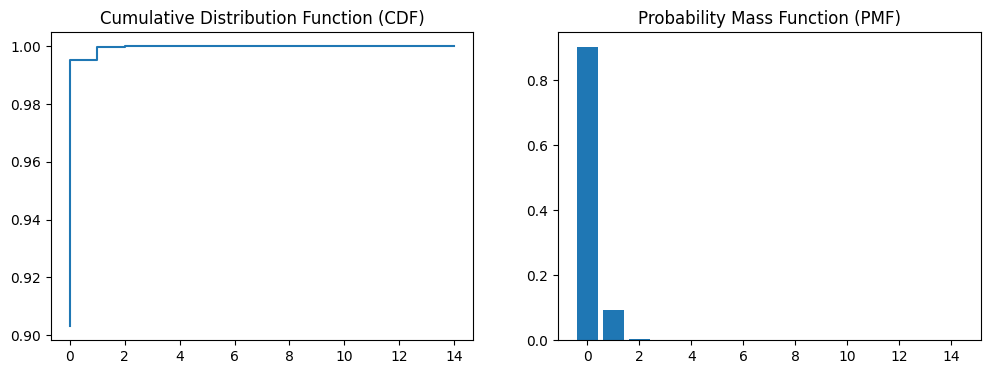

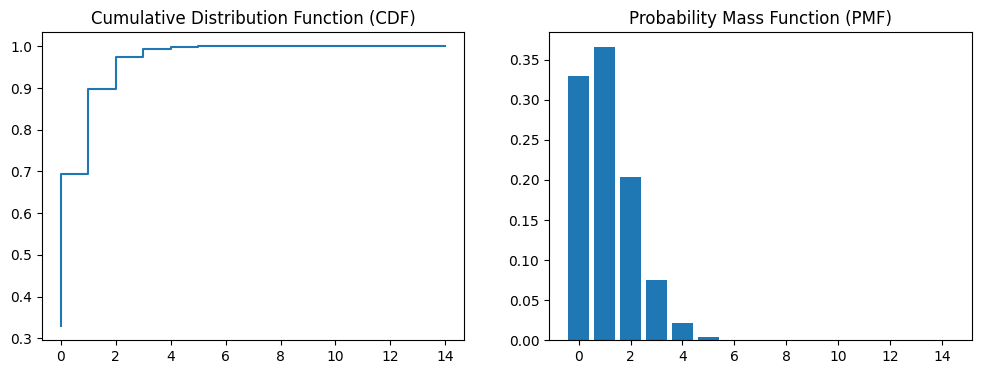



122 vs 123 Distributions
122    2
122    1
122    2
122    0
Name: Goals_Scored_0, dtype: object
123    1
123    5
123    0
123    2
Name: Goals_Scored_0, dtype: object


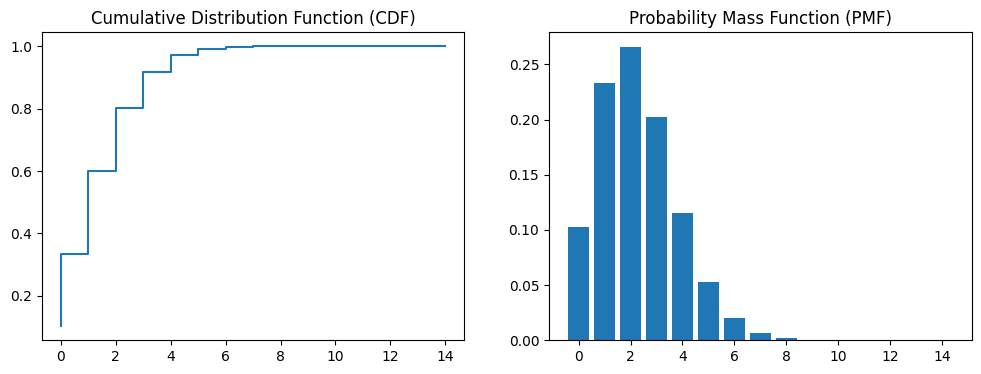

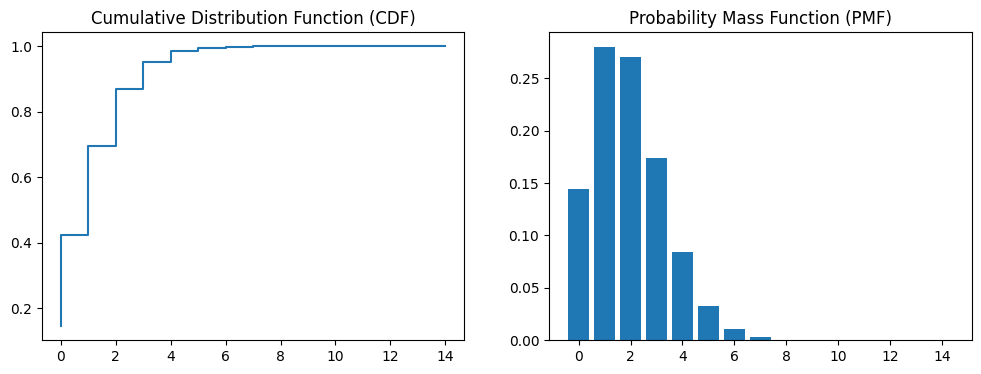



456 vs 457 Distributions
456    2
456    1
456    2
456    1
Name: Goals_Scored_0, dtype: object
457    2
457    1
457    2
457    1
Name: Goals_Scored_0, dtype: object


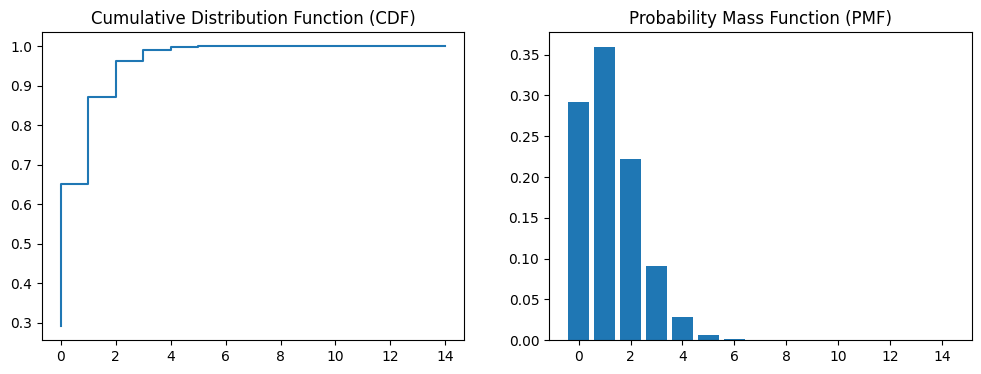

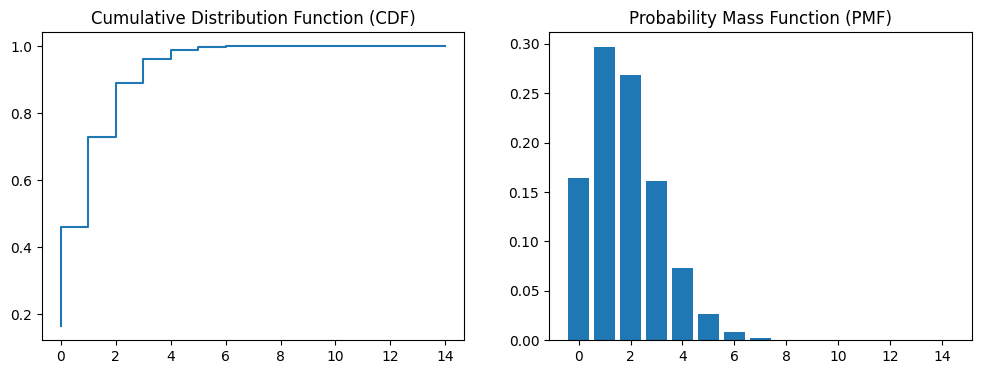



428 vs 429 Distributions
428    1
428    2
428    3
428    1
Name: Goals_Scored_0, dtype: object
429    1
429    1
429    0
429    2
Name: Goals_Scored_0, dtype: object


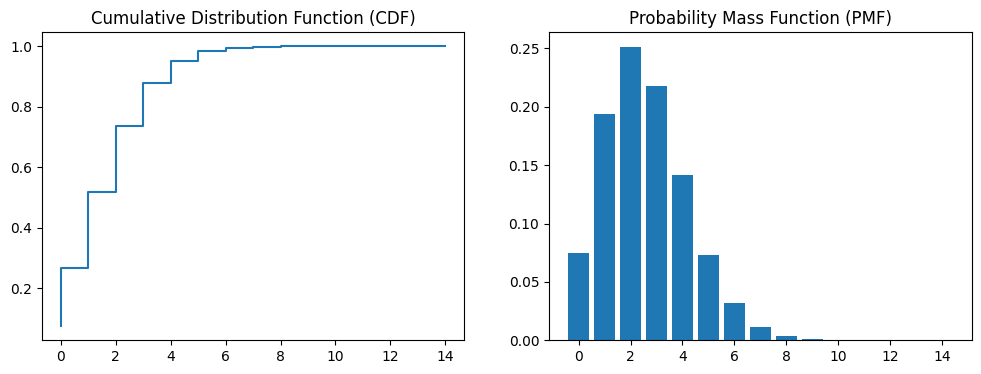

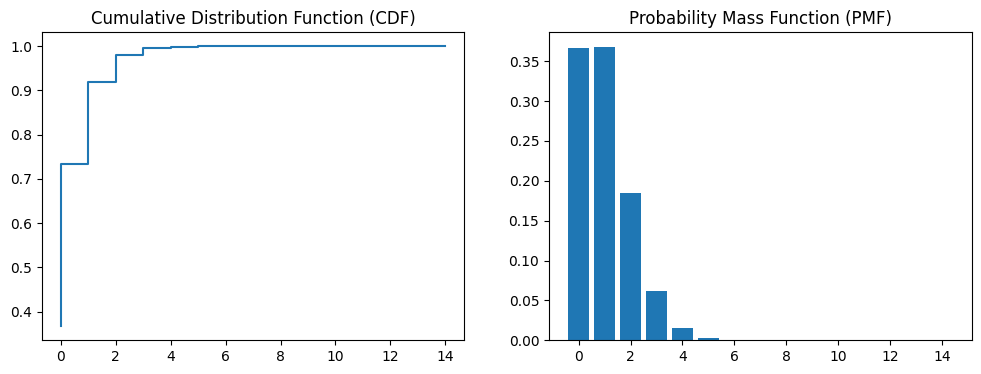



119 vs 118 Distributions
119    2
119    2
119    1
119    2
Name: Goals_Scored_0, dtype: object
118    3
118    3
118    0
118    0
Name: Goals_Scored_0, dtype: object


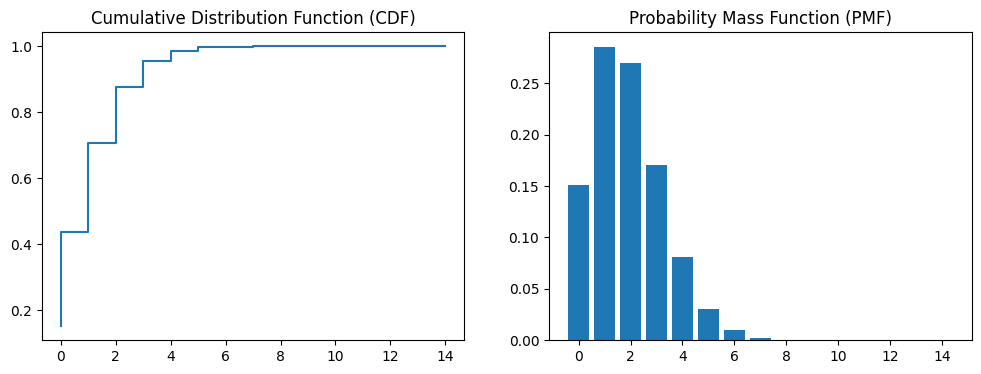

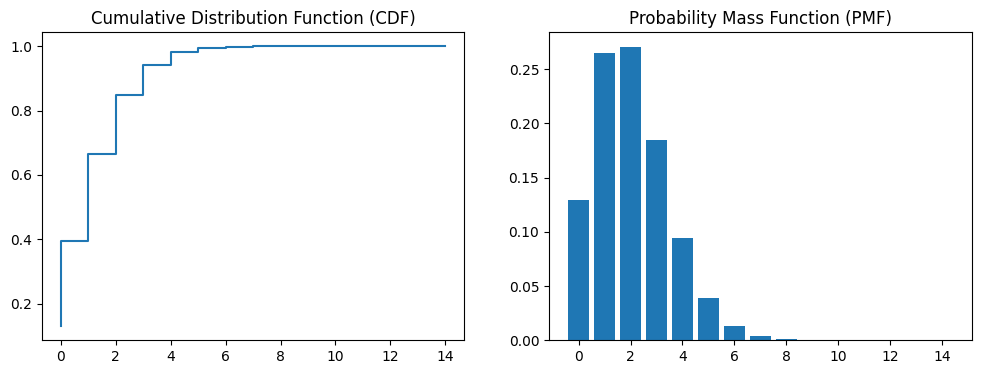



134 vs 135 Distributions
134    2
134    0
134    1
134    1
Name: Goals_Scored_0, dtype: object
135    1
135    3
135    1
135    1
Name: Goals_Scored_0, dtype: object


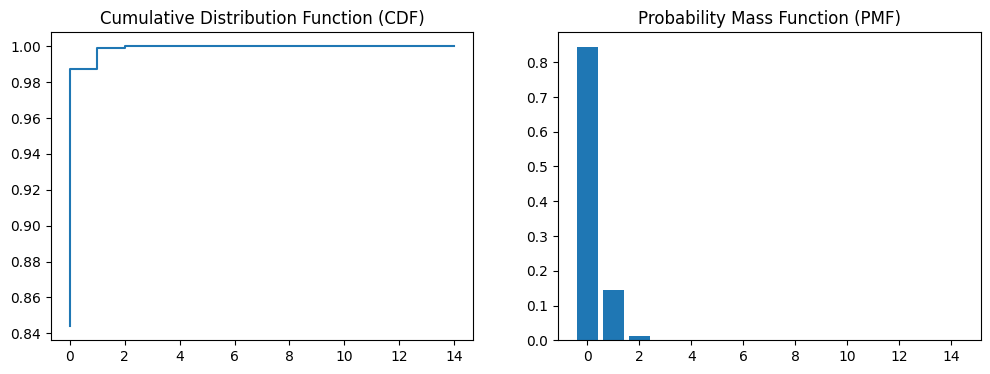

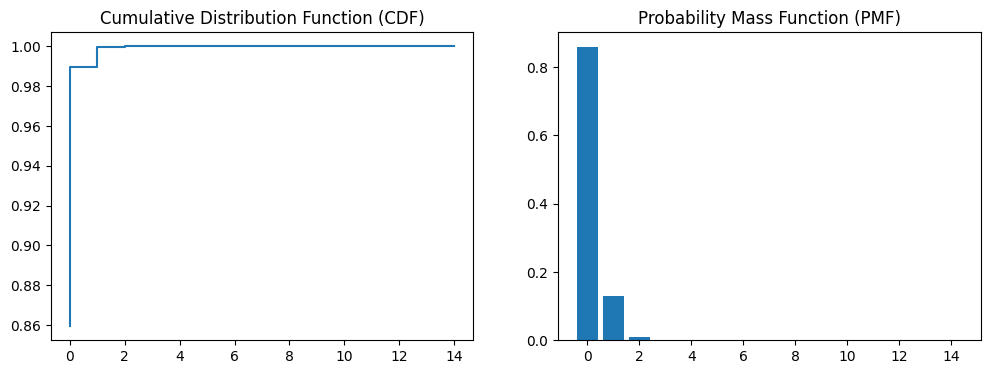



531 vs 530 Distributions
531    3
531    0
531    2
531    2
Name: Goals_Scored_0, dtype: object
530    0
530    2
530    1
530    2
Name: Goals_Scored_0, dtype: object


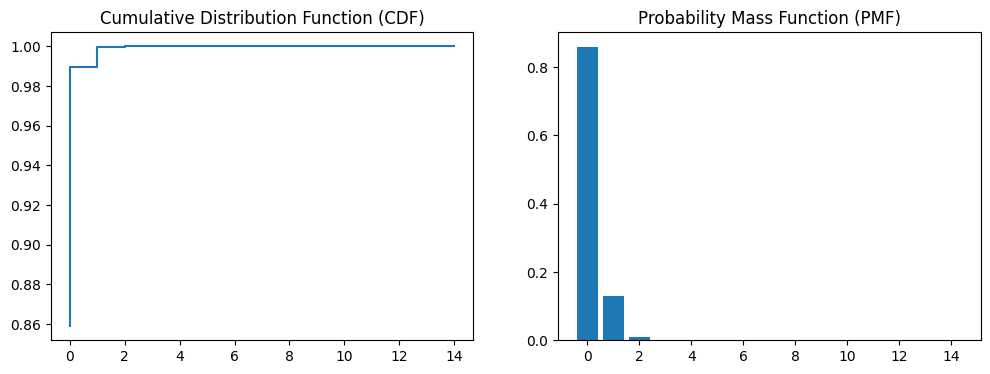

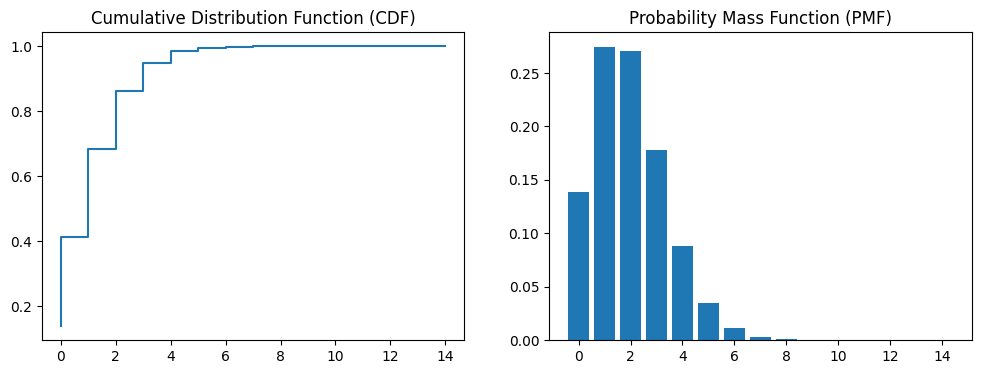



156 vs 157 Distributions
156    2
156    0
156    2
156    1
Name: Goals_Scored_0, dtype: object
157    1
157    2
157    2
157    2
Name: Goals_Scored_0, dtype: object


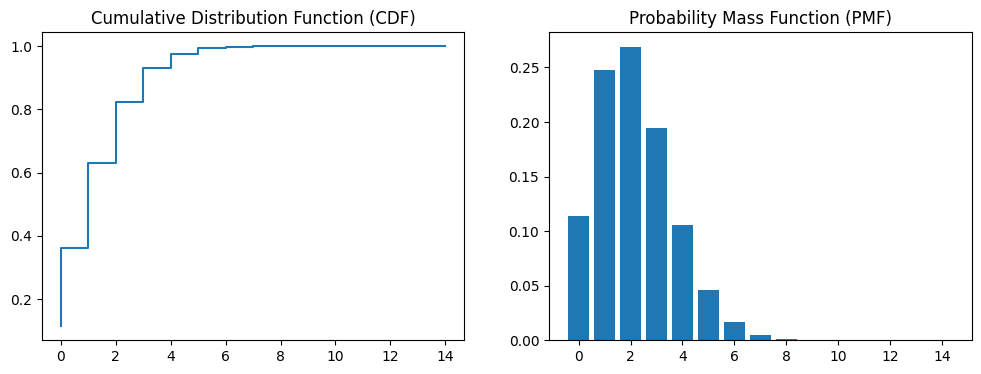

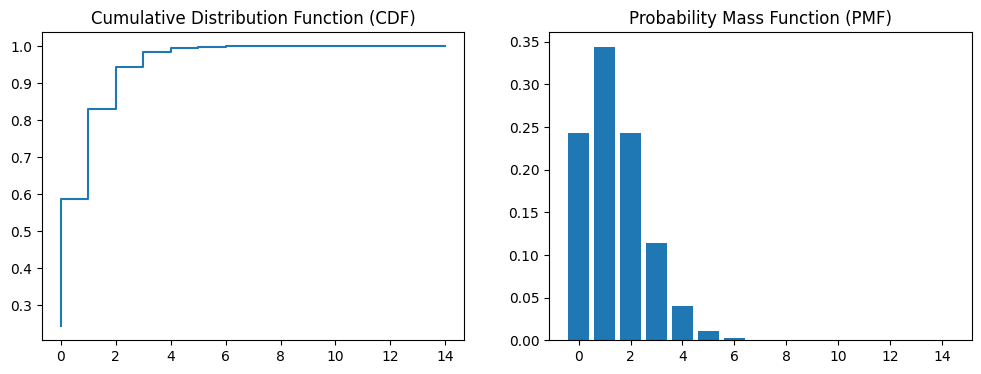



565 vs 564 Distributions
565    0
565    0
565    0
565    3
Name: Goals_Scored_0, dtype: object
564    2
564    0
564    1
564    1
Name: Goals_Scored_0, dtype: object


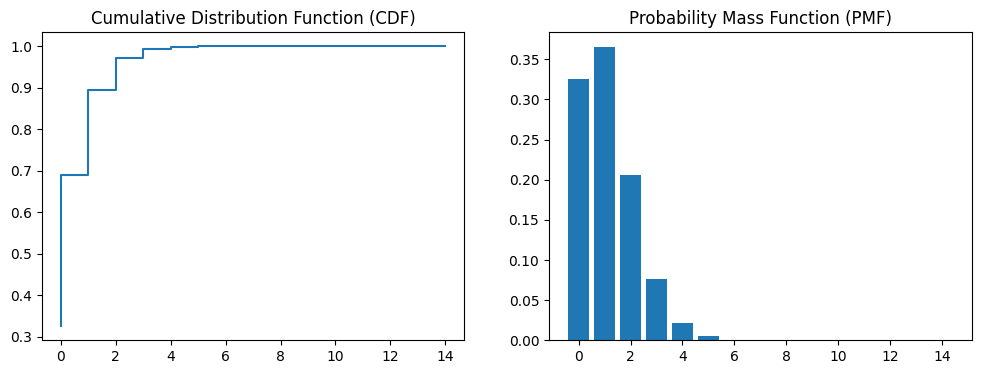

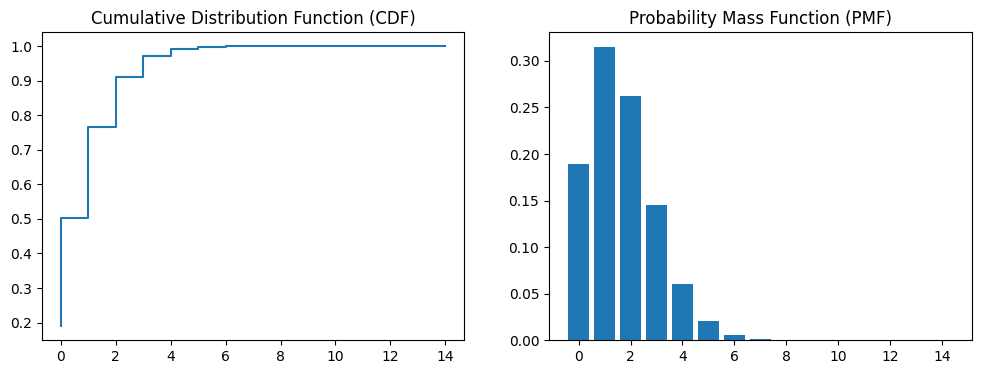



606 vs 607 Distributions
606    0
606    0
606    2
606    3
Name: Goals_Scored_0, dtype: object
607    2
607    2
607    0
607    0
Name: Goals_Scored_0, dtype: object


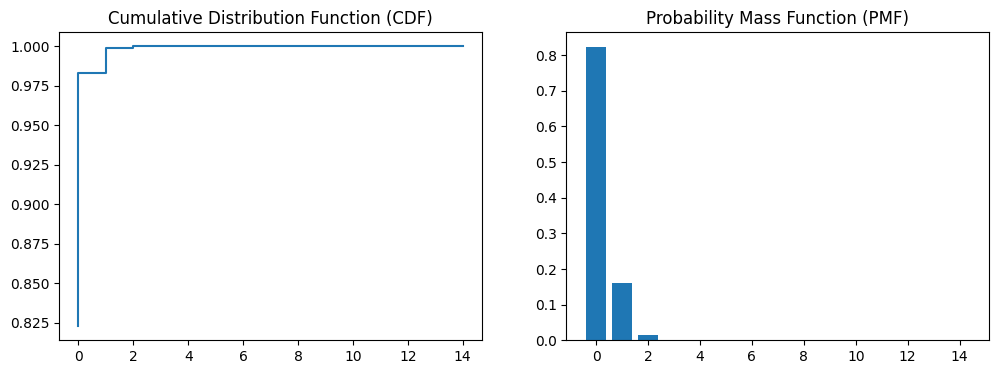

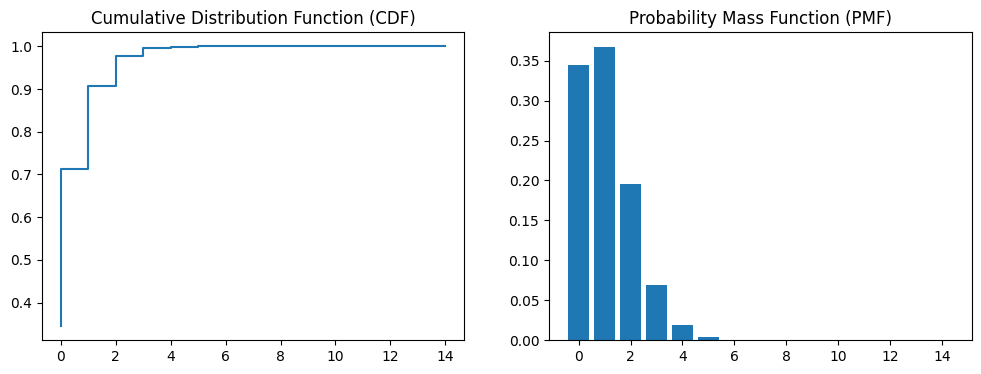



431 vs 430 Distributions
431    1
431    0
431    2
431    1
Name: Goals_Scored_0, dtype: object
430    3
430    1
430    3
430    7
Name: Goals_Scored_0, dtype: object


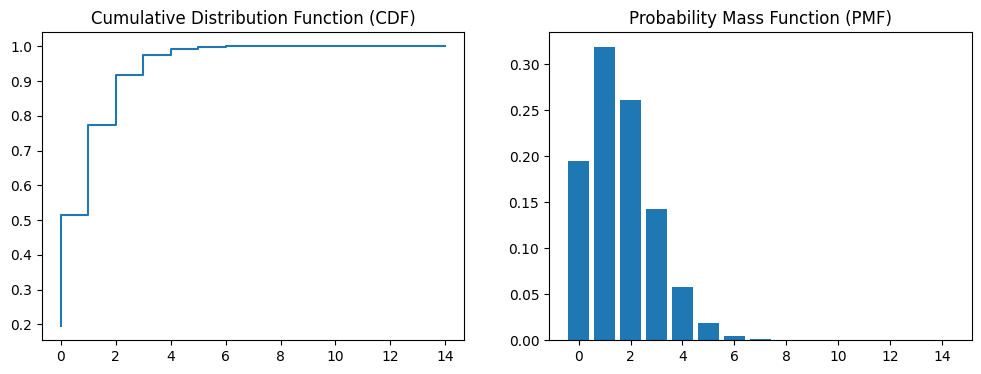

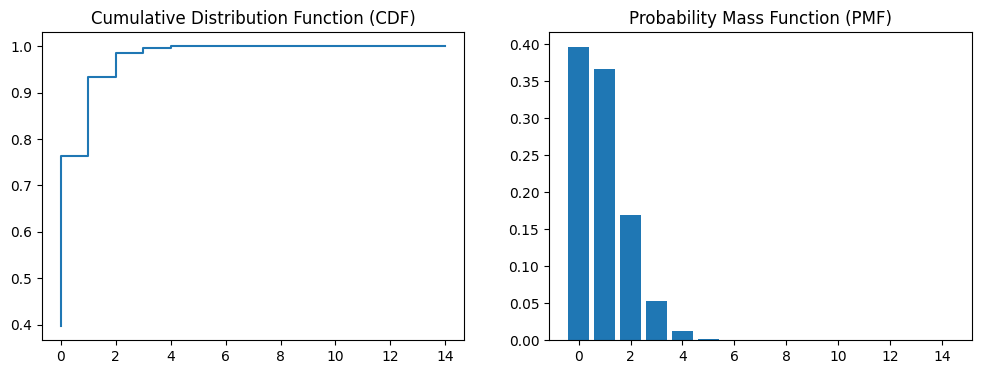



417 vs 416 Distributions
417    3
417    2
417    2
417    2
Name: Goals_Scored_0, dtype: object
416    3
416    3
416    1
416    1
Name: Goals_Scored_0, dtype: object


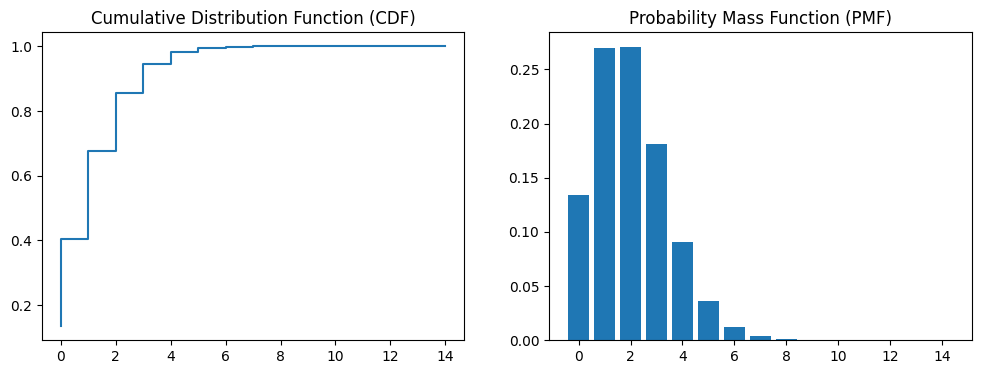

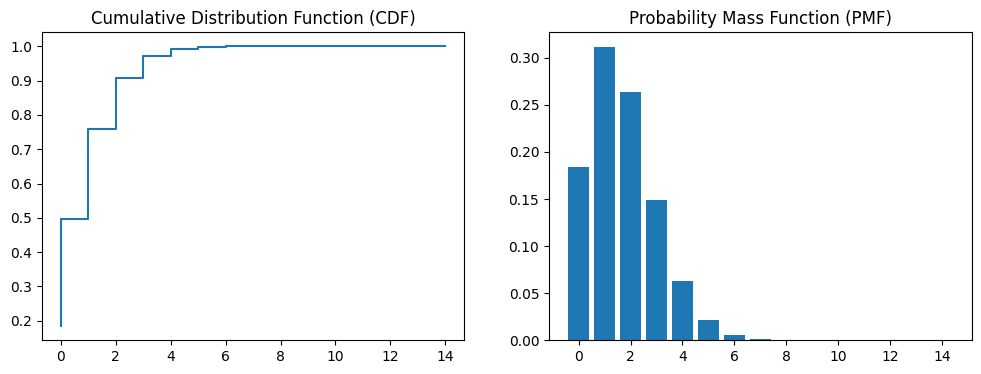



561 vs 560 Distributions
561    3
561    0
561    2
561    2
Name: Goals_Scored_0, dtype: object
560    0
560    2
560    1
560    2
Name: Goals_Scored_0, dtype: object


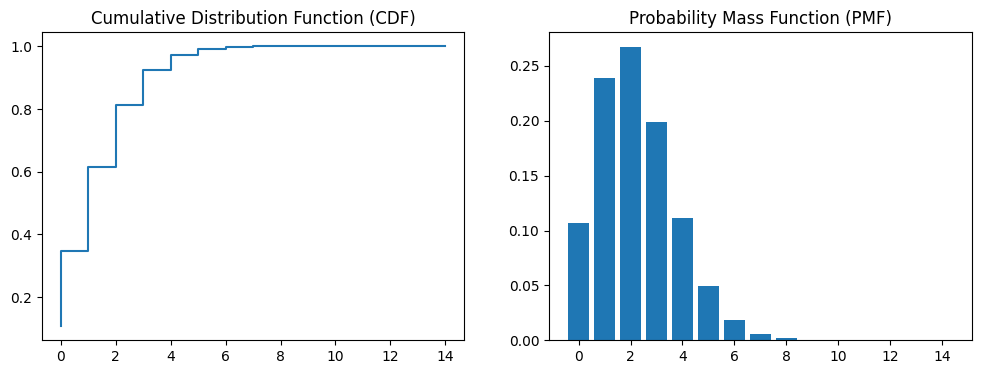

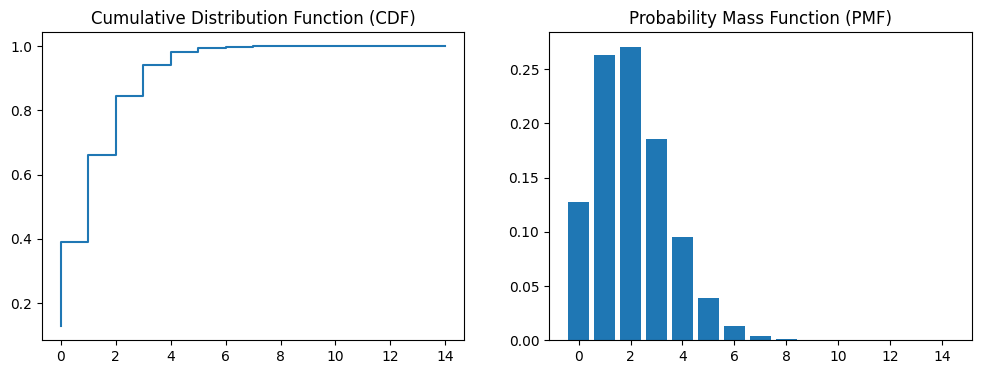



209 vs 208 Distributions
209    0
209    1
209    2
209    3
Name: Goals_Scored_0, dtype: object
208    2
208    1
208    2
208    0
Name: Goals_Scored_0, dtype: object


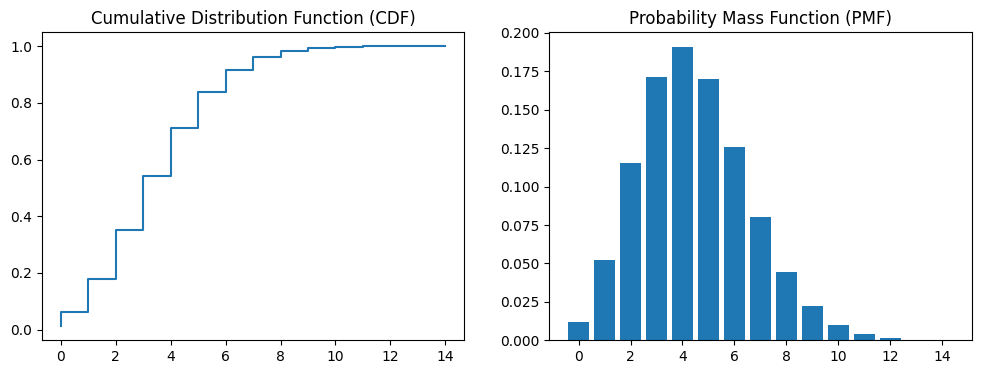

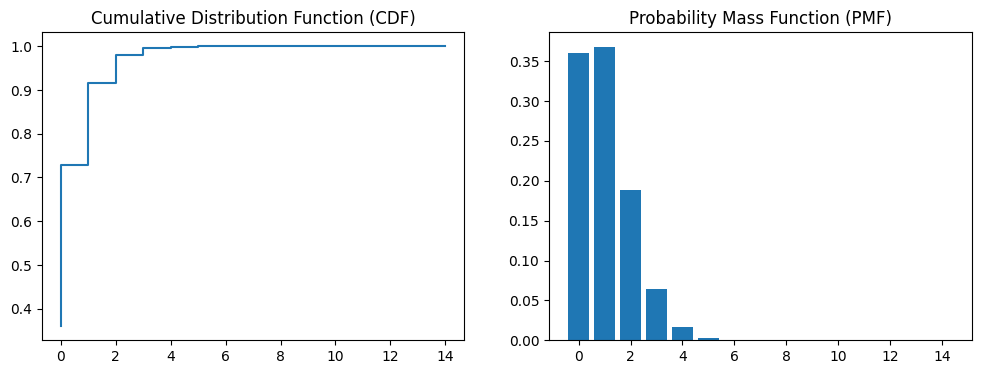



205 vs 204 Distributions
205    3
205    1
205    1
205    0
Name: Goals_Scored_0, dtype: object
204    2
204    0
204    3
204    1
Name: Goals_Scored_0, dtype: object


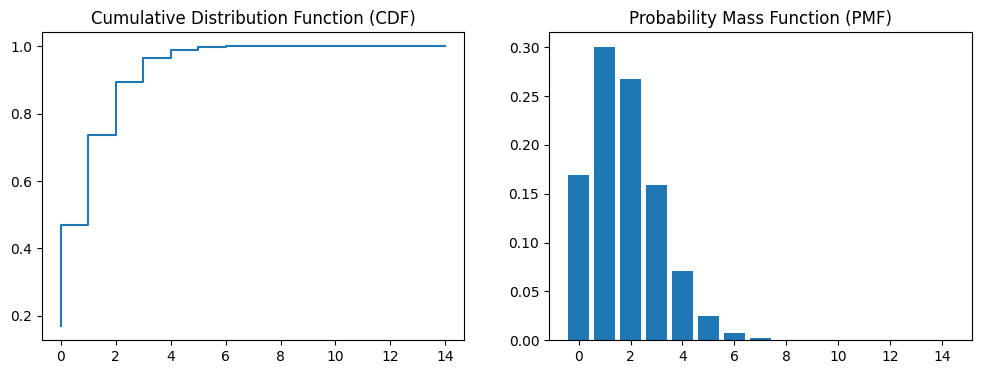

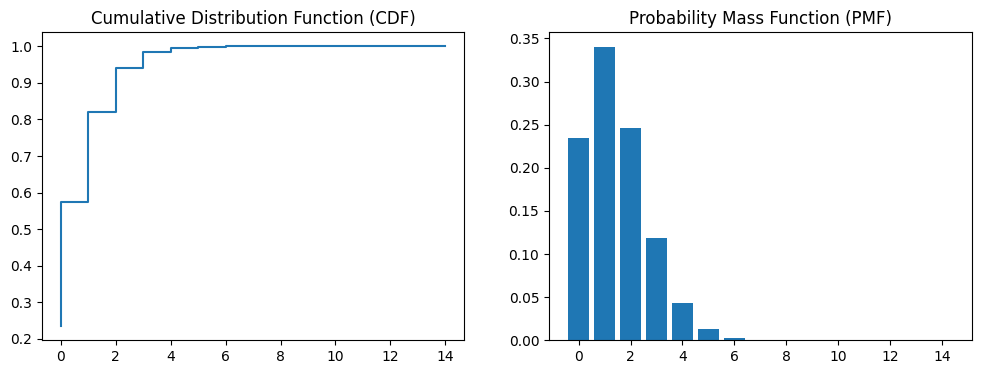



589 vs 588 Distributions
589    2
589    0
589    1
589    1
Name: Goals_Scored_0, dtype: object
588    2
588    1
588    1
588    1
Name: Goals_Scored_0, dtype: object


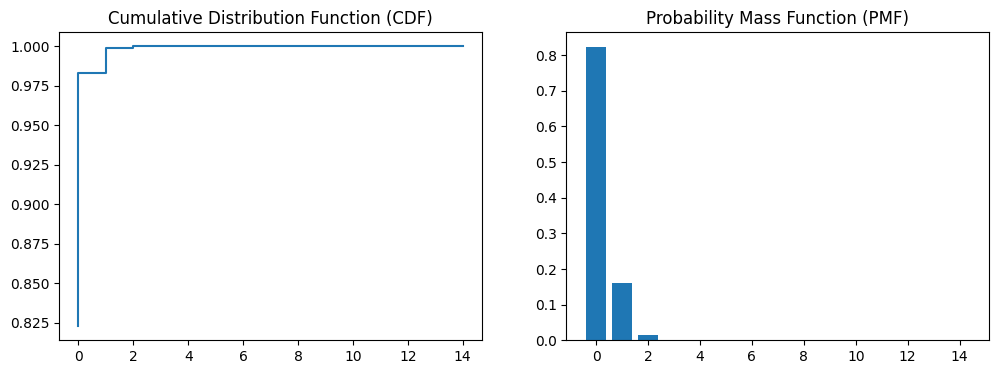

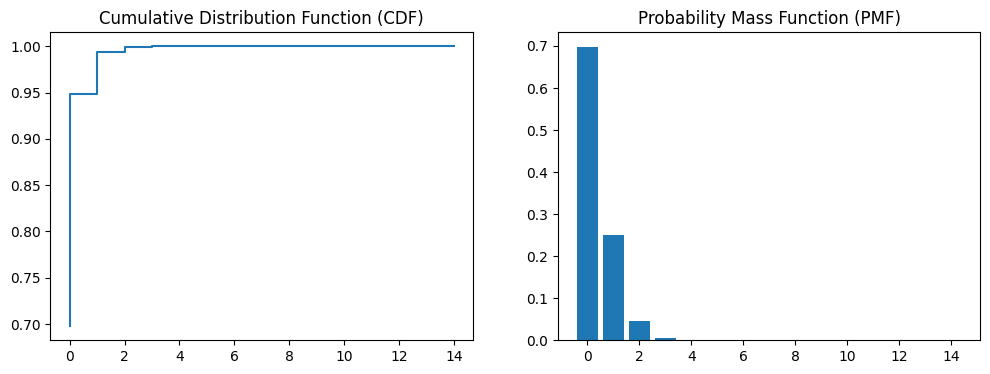



113 vs 112 Distributions
113    2
113    0
113    1
113    4
Name: Goals_Scored_0, dtype: object
112    4
112    3
112    0
112    8
Name: Goals_Scored_0, dtype: object


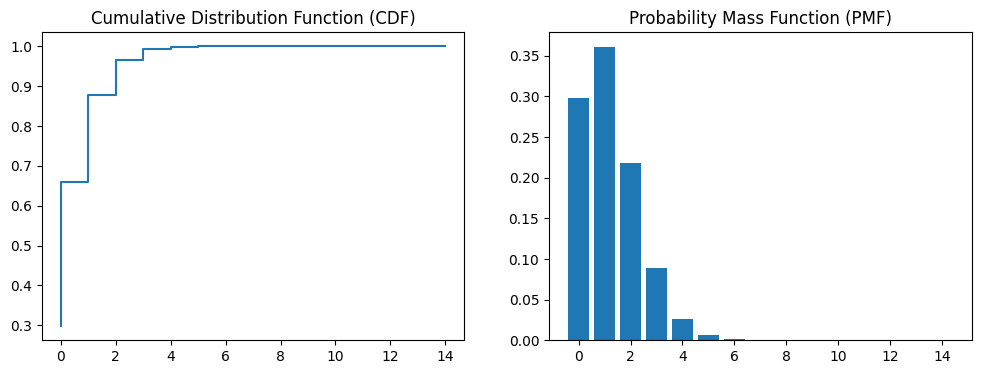

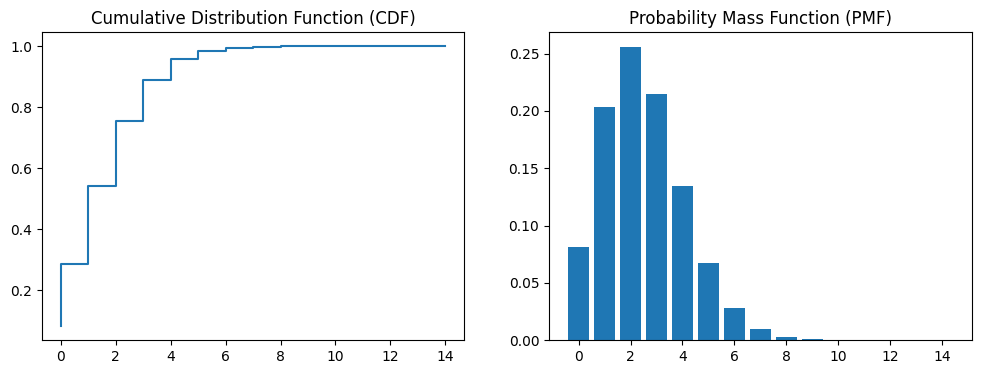



493 vs 492 Distributions
493    1
493    0
493    0
493    0
Name: Goals_Scored_0, dtype: object
492    3
492    2
492    0
492    1
Name: Goals_Scored_0, dtype: object


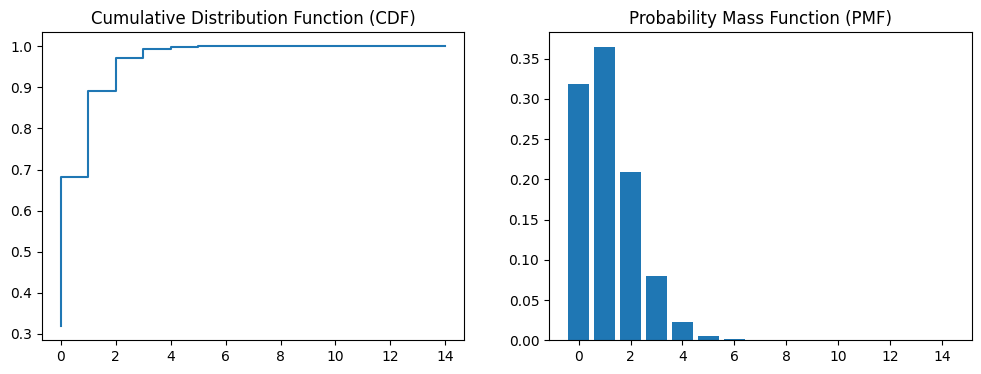

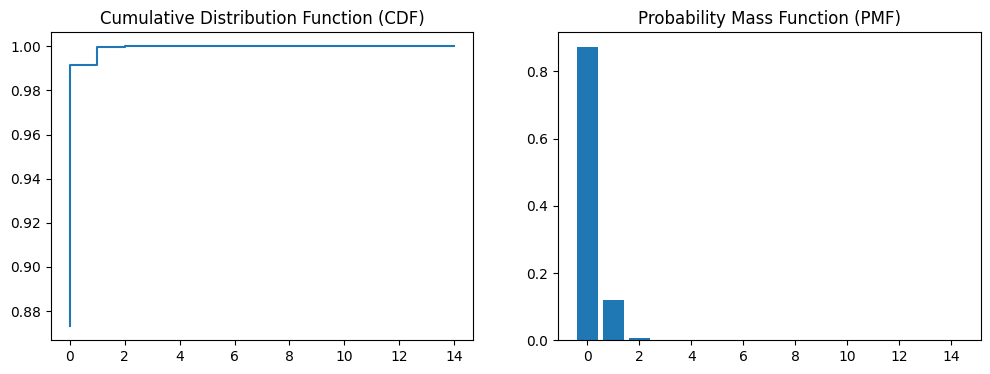



185 vs 184 Distributions
185    3
185    0
185    0
185    1
Name: Goals_Scored_0, dtype: object
184    1
184    0
184    2
184    1
Name: Goals_Scored_0, dtype: object


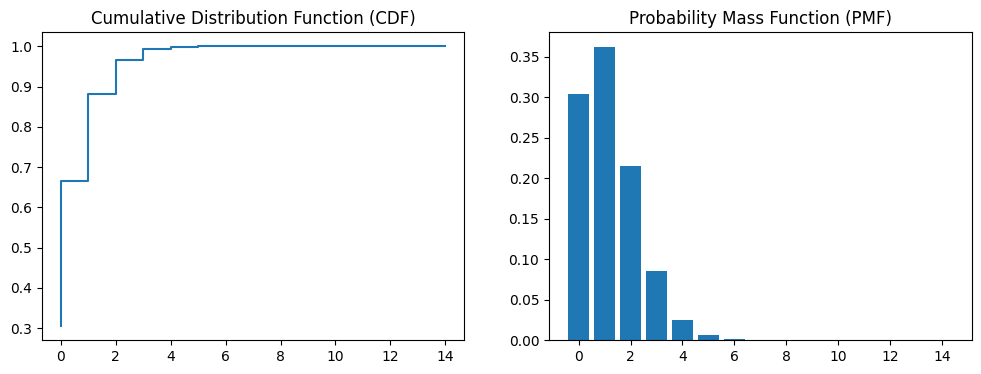

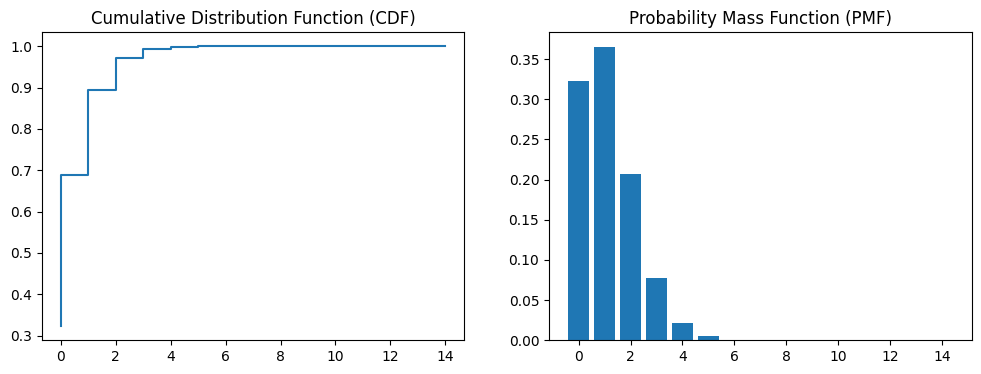



115 vs 114 Distributions
115    2
115    0
115    2
115    1
Name: Goals_Scored_0, dtype: object
114    2
114    2
114    0
114    0
Name: Goals_Scored_0, dtype: object


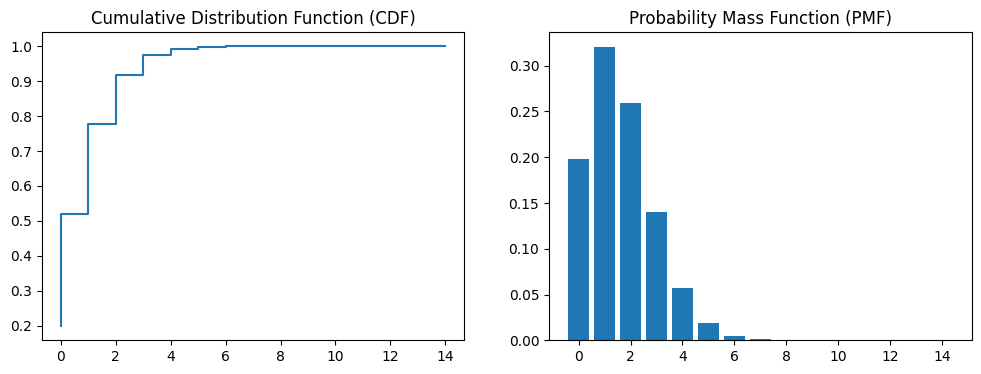

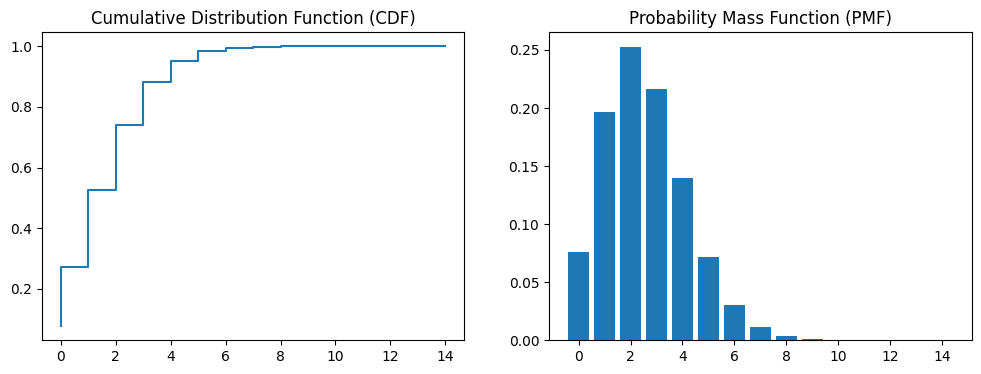



11 vs 10 Distributions
11    3
11    1
11    3
11    3
Name: Goals_Scored_0, dtype: object
10    2
10    1
10    1
10    1
Name: Goals_Scored_0, dtype: object


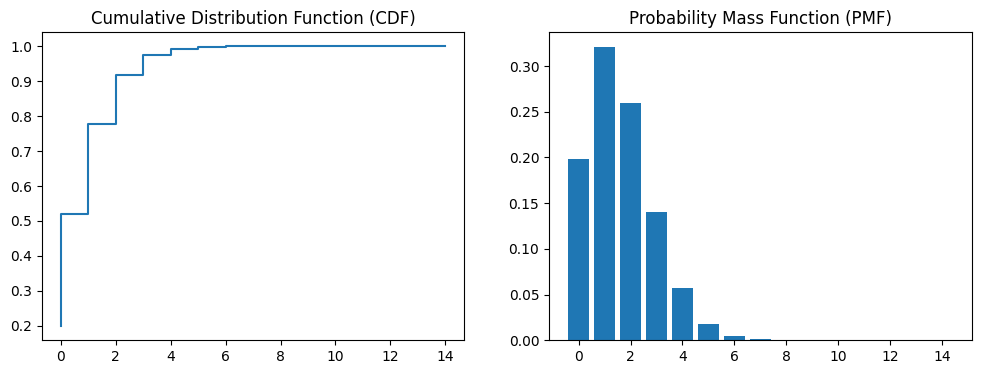

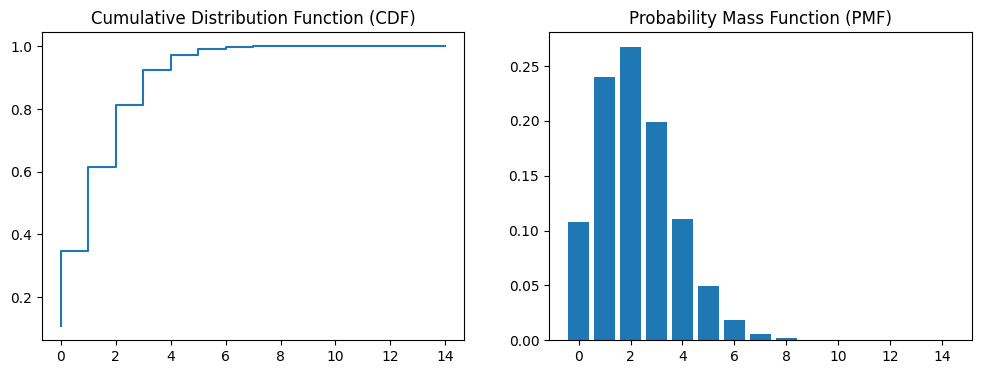



259 vs 258 Distributions
259    1
259    5
259    0
259    0
Name: Goals_Scored_0, dtype: object
258    0
258    0
258    1
258    3
Name: Goals_Scored_0, dtype: object


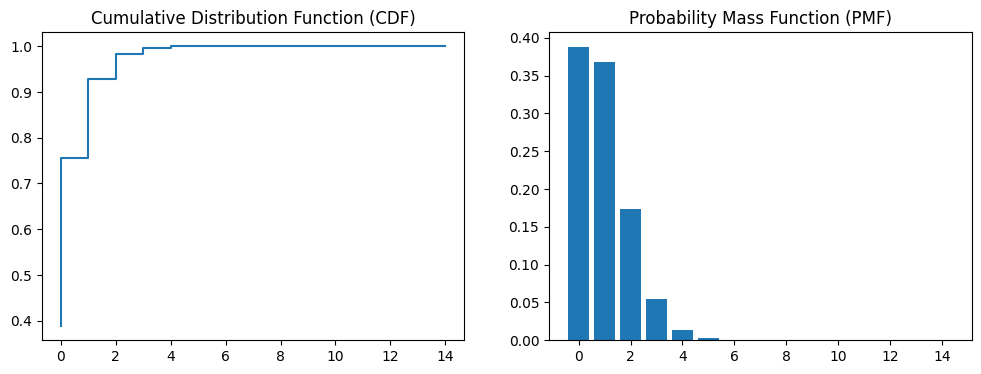

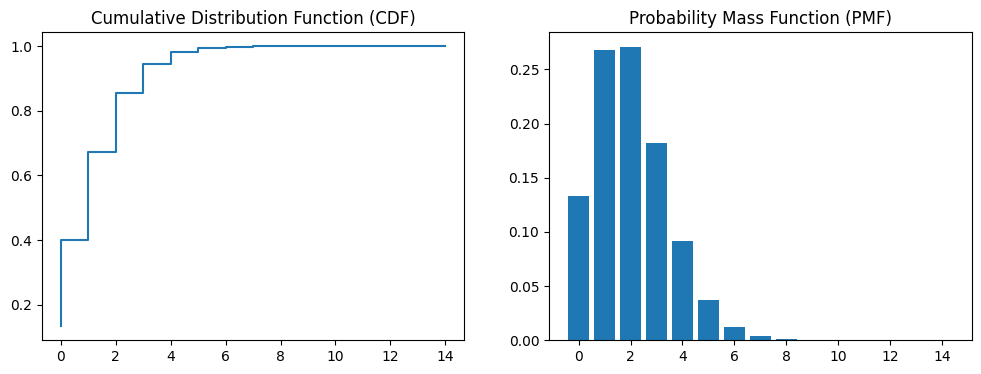



671 vs 670 Distributions
671    1
671    2
671    0
671    0
Name: Goals_Scored_0, dtype: object
670    0
670    1
670    1
670    0
Name: Goals_Scored_0, dtype: object


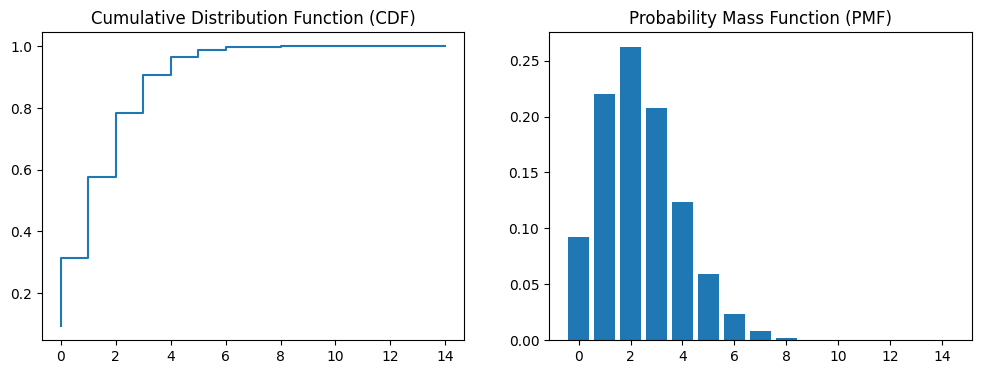

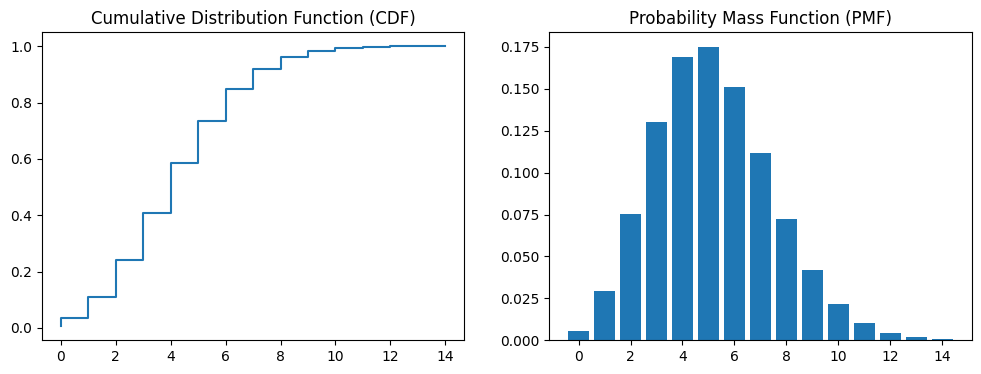



707 vs 706 Distributions
707    0
707    1
707    1
707    0
Name: Goals_Scored_0, dtype: object
706    4
706    0
706    1
706    4
Name: Goals_Scored_0, dtype: object


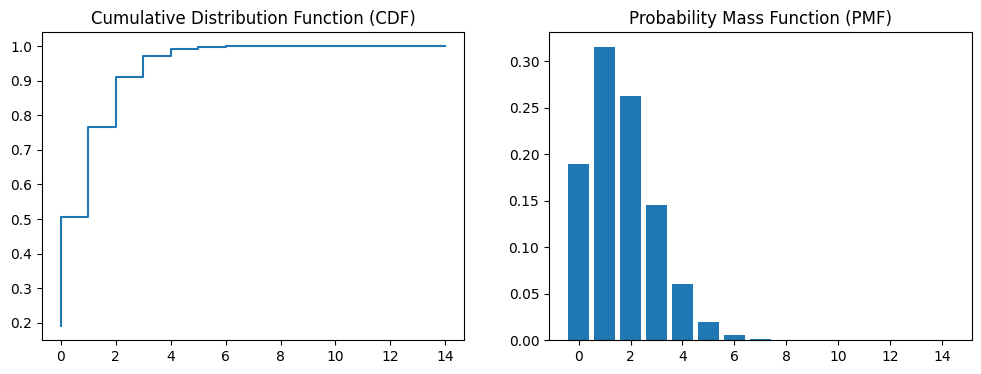

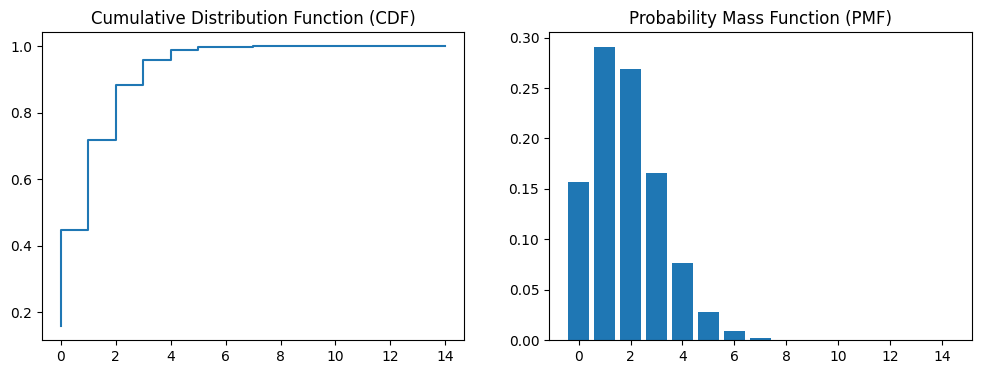



87 vs 86 Distributions
87    5
87    0
87    2
87    4
Name: Goals_Scored_0, dtype: object
86    1
86    1
86    2
86    3
Name: Goals_Scored_0, dtype: object


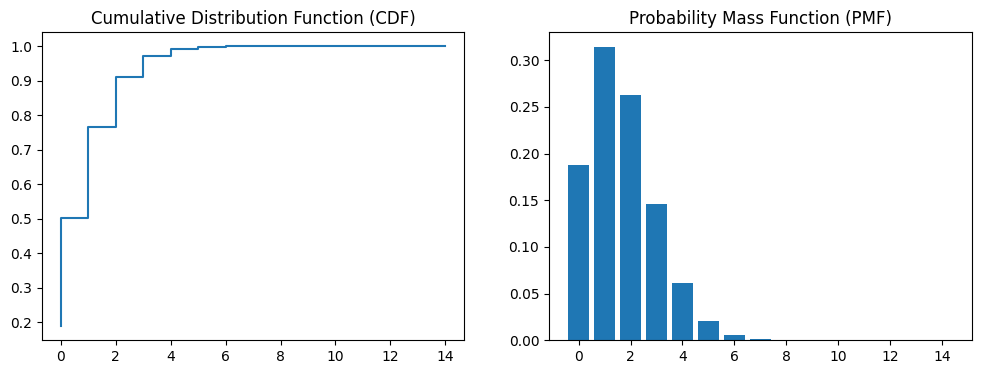

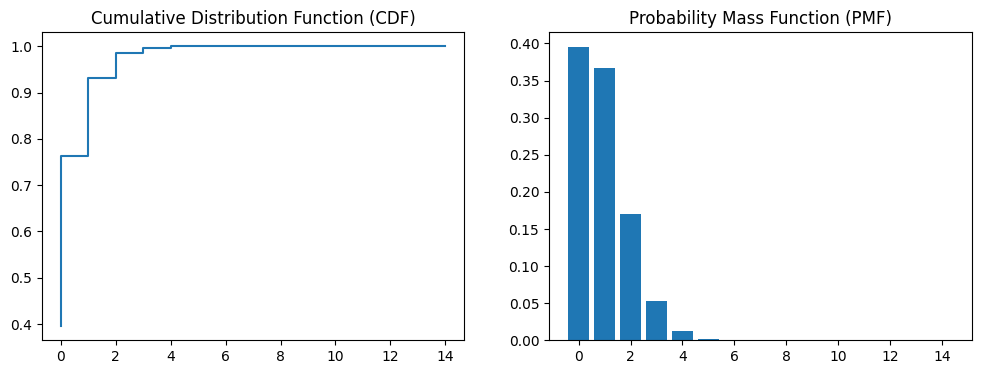



353 vs 352 Distributions
353    1
353    2
353    1
353    4
Name: Goals_Scored_0, dtype: object
352    2
352    4
352    2
352    1
Name: Goals_Scored_0, dtype: object


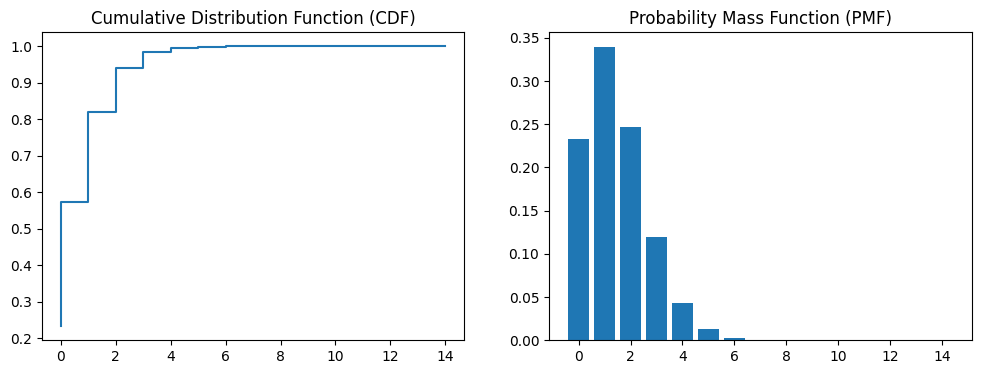

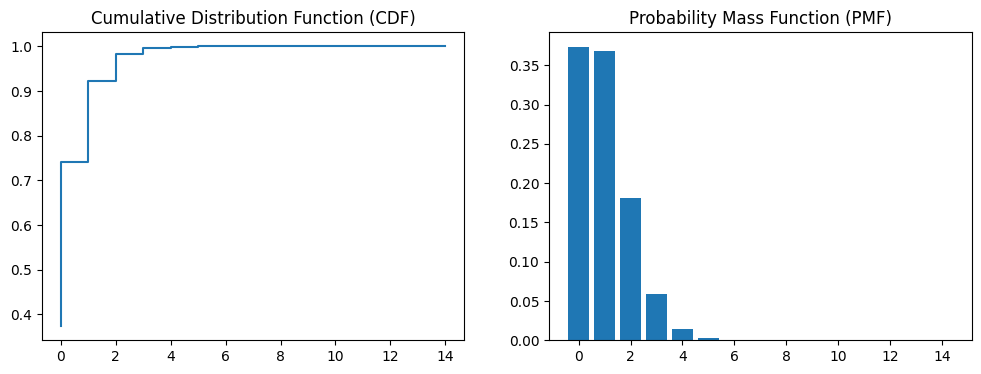



644 vs 645 Distributions
644    2
644    0
644    1
644    1
Name: Goals_Scored_0, dtype: object
645    0
645    1
645    0
645    0
Name: Goals_Scored_0, dtype: object


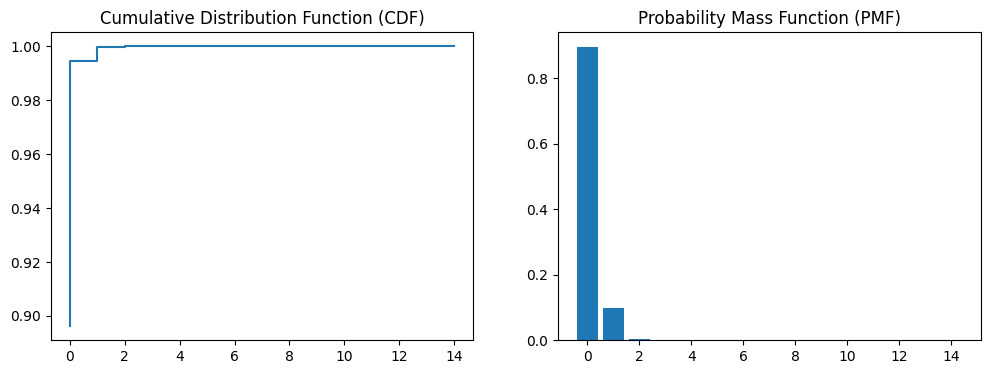

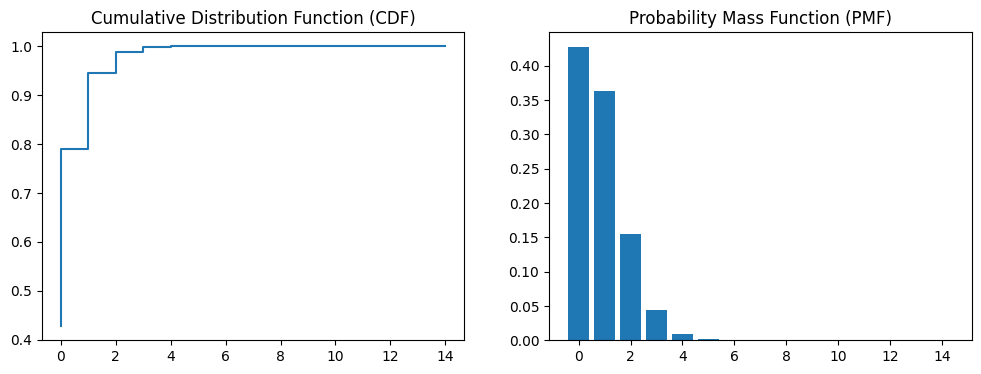



412 vs 413 Distributions
412    0
412    1
412    2
412    1
Name: Goals_Scored_0, dtype: object
413    0
413    0
413    3
413    0
Name: Goals_Scored_0, dtype: object


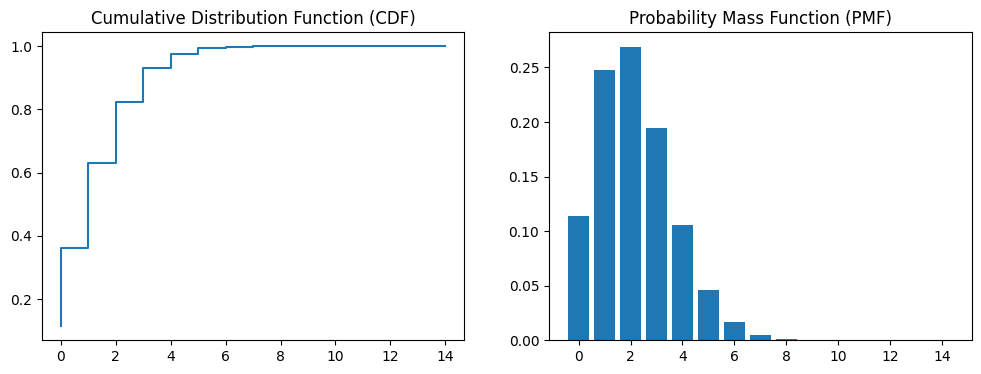

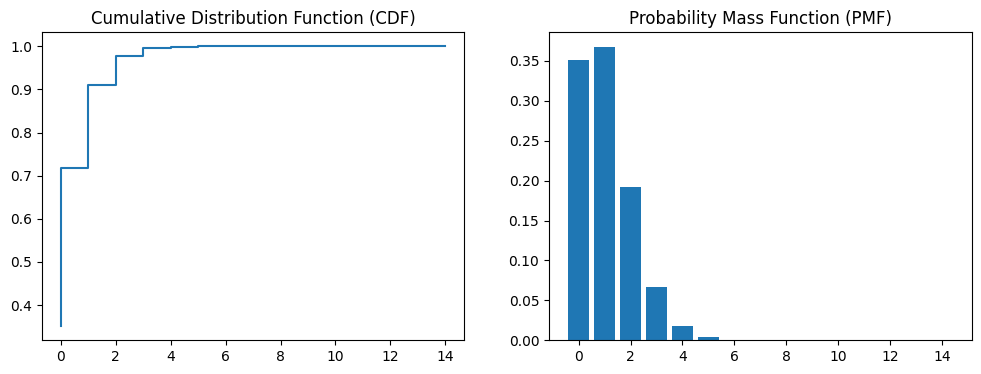



185 vs 184 Distributions
185    3
185    0
185    0
185    1
Name: Goals_Scored_0, dtype: object
184    1
184    0
184    2
184    1
Name: Goals_Scored_0, dtype: object


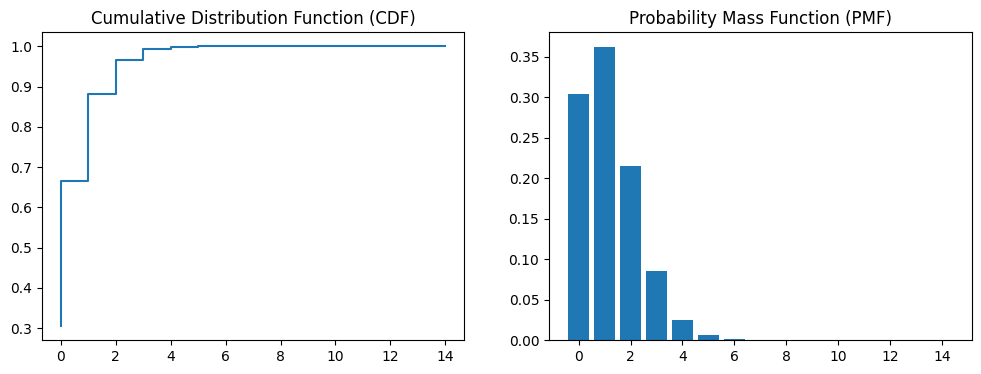

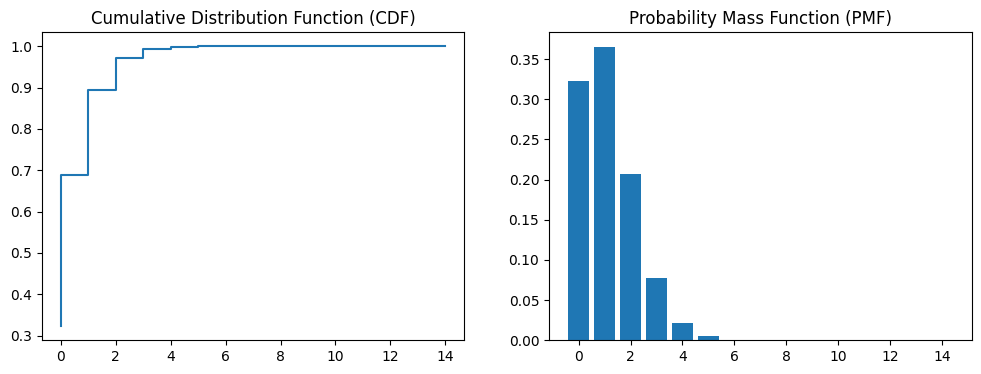



689 vs 688 Distributions
689    0
689    2
689    0
689    1
Name: Goals_Scored_0, dtype: object
688    0
688    1
688    2
688    2
Name: Goals_Scored_0, dtype: object


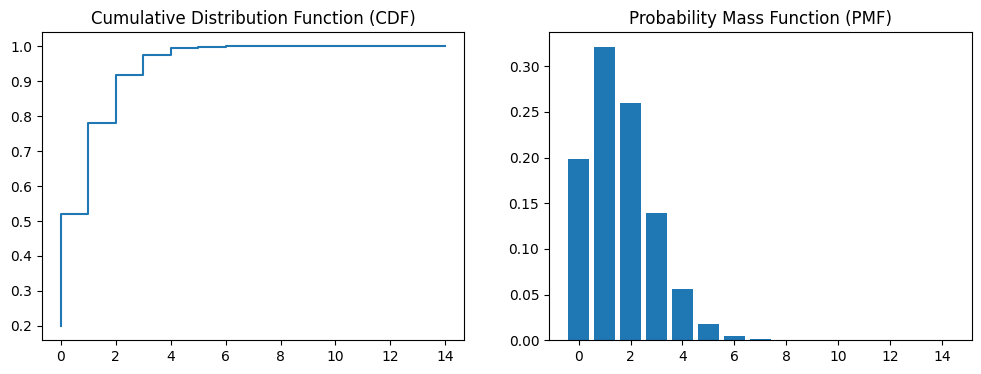

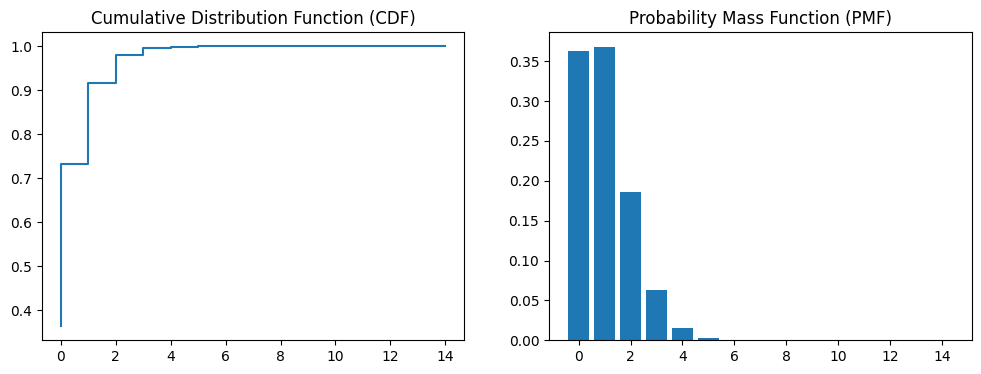



715 vs 714 Distributions
715    2
715    2
715    2
715    1
Name: Goals_Scored_0, dtype: object
714    3
714    1
714    1
714    3
Name: Goals_Scored_0, dtype: object


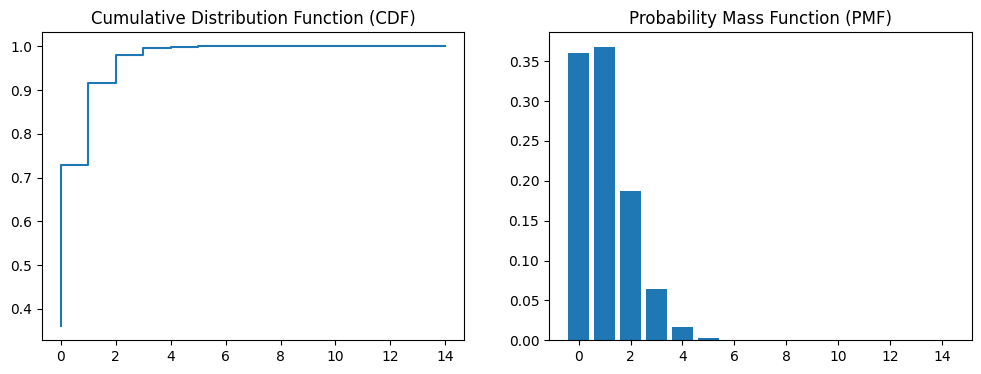

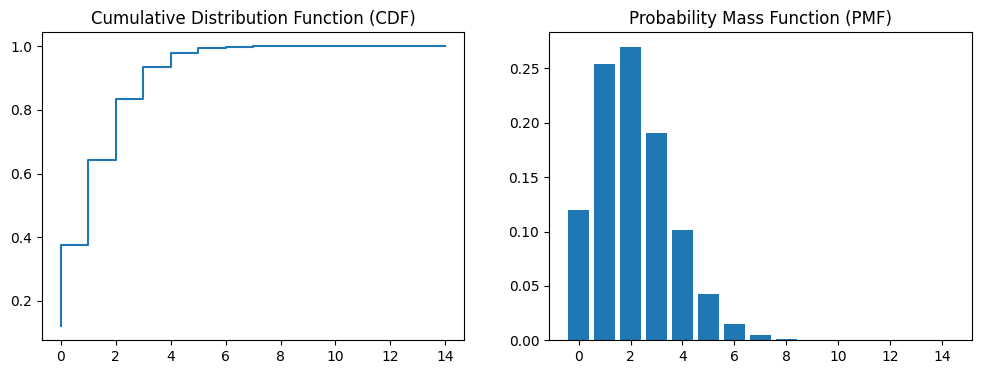



235 vs 234 Distributions
235    0
235    4
235    1
235    3
Name: Goals_Scored_0, dtype: object
234    1
234    3
234    2
234    0
Name: Goals_Scored_0, dtype: object


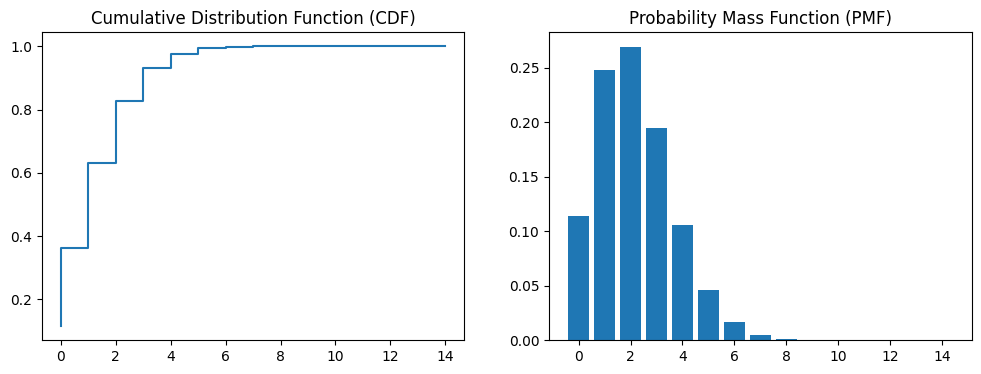

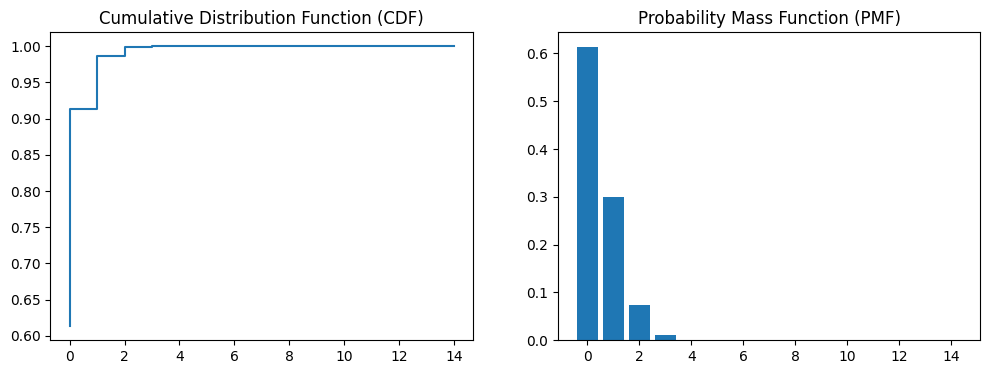



397 vs 396 Distributions
397    2
397    5
397    4
397    1
Name: Goals_Scored_0, dtype: object
396    1
396    0
396    1
396    0
Name: Goals_Scored_0, dtype: object


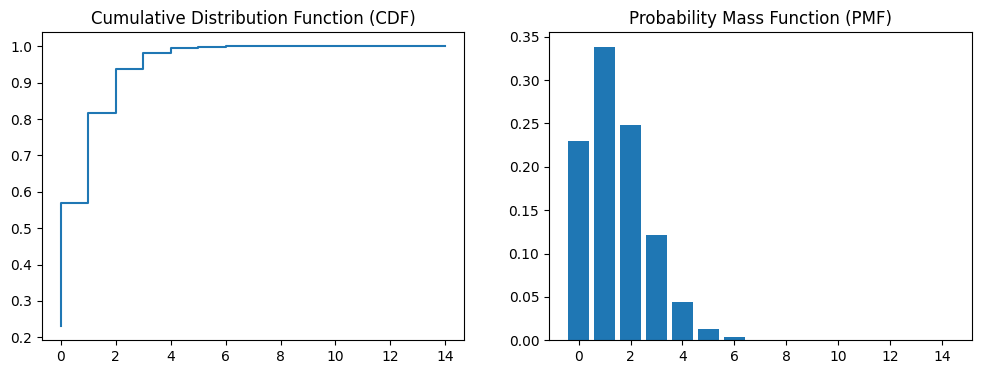

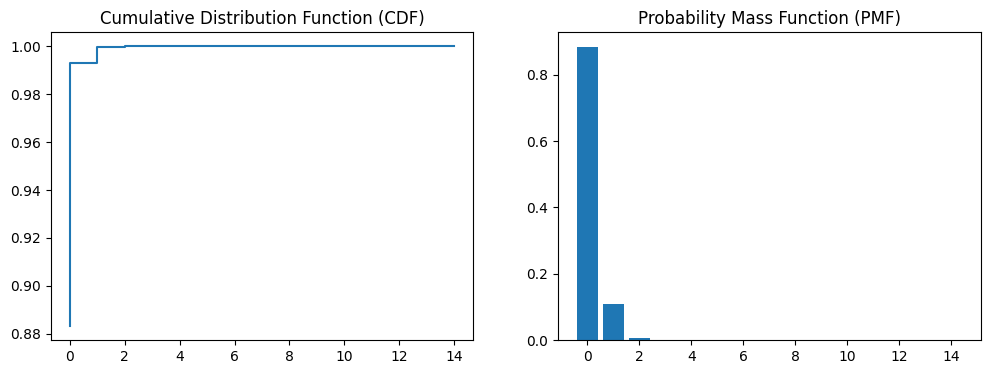



675 vs 674 Distributions
675    1
675    0
675    1
675    2
Name: Goals_Scored_0, dtype: object
674    0
674    0
674    0
674    0
Name: Goals_Scored_0, dtype: object


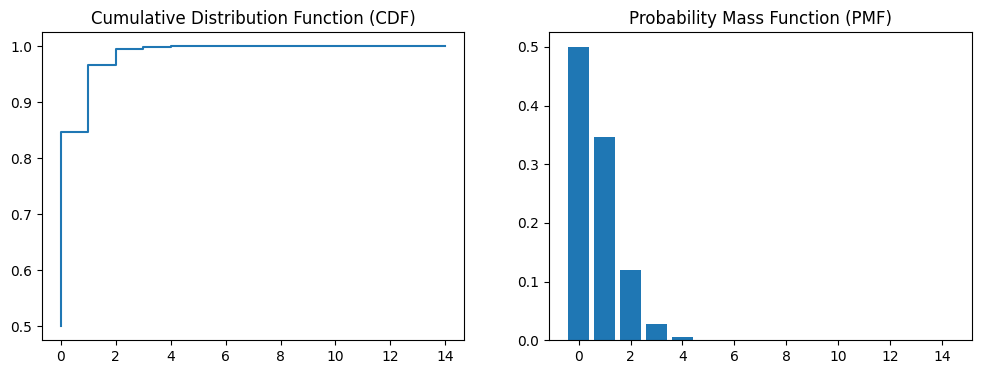

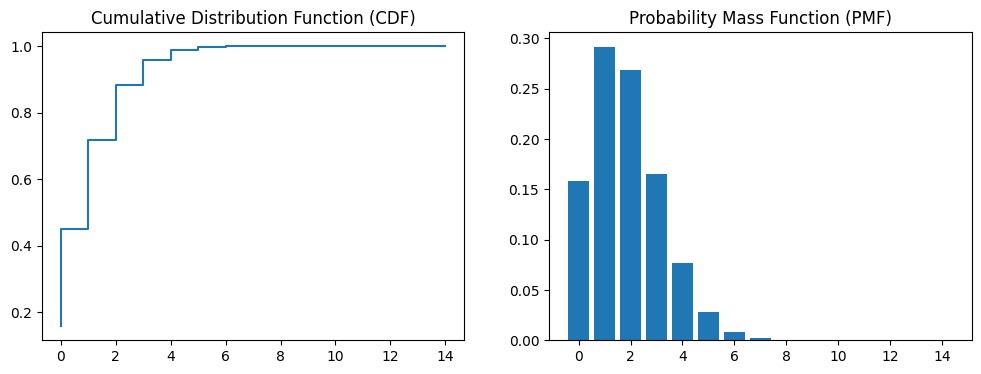



321 vs 320 Distributions
321    1
321    1
321    3
321    0
Name: Goals_Scored_0, dtype: object
320    3
320    1
320    1
320    0
Name: Goals_Scored_0, dtype: object


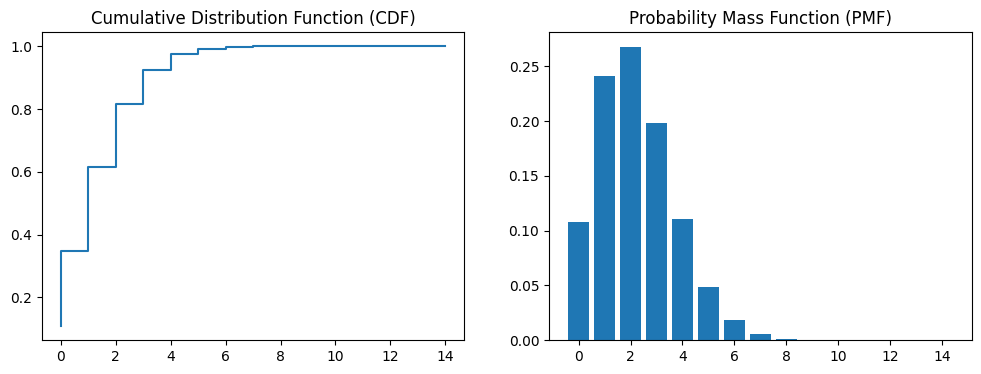

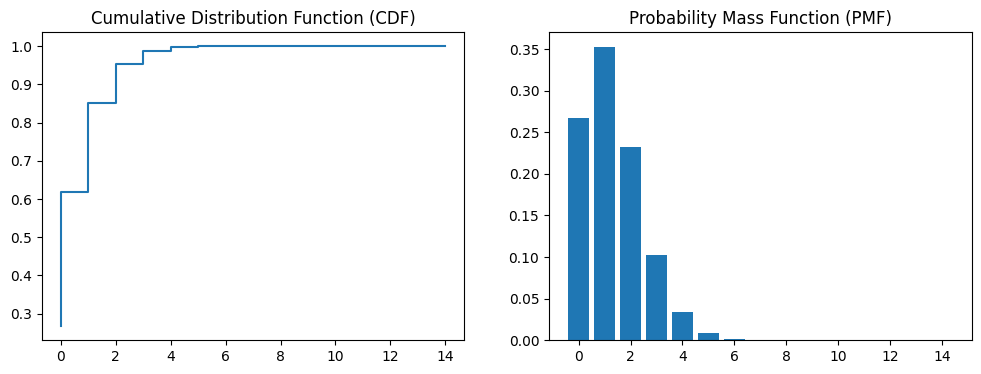



163 vs 162 Distributions
163    2
163    3
163    0
163    0
Name: Goals_Scored_0, dtype: object
162    1
162    0
162    2
162    0
Name: Goals_Scored_0, dtype: object


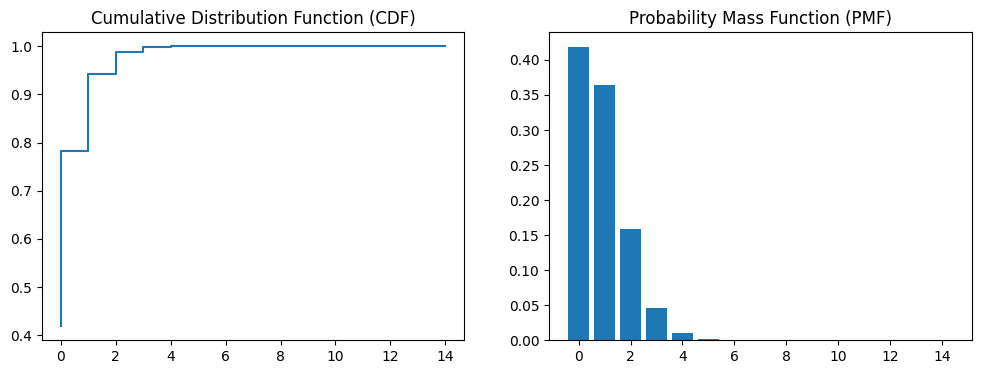

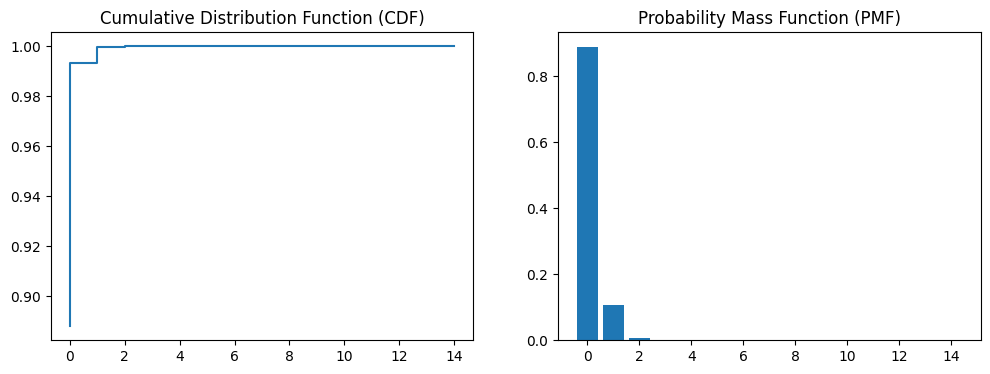



691 vs 690 Distributions
691    2
691    1
691    2
691    4
Name: Goals_Scored_0, dtype: object
690    2
690    1
690    3
690    2
Name: Goals_Scored_0, dtype: object


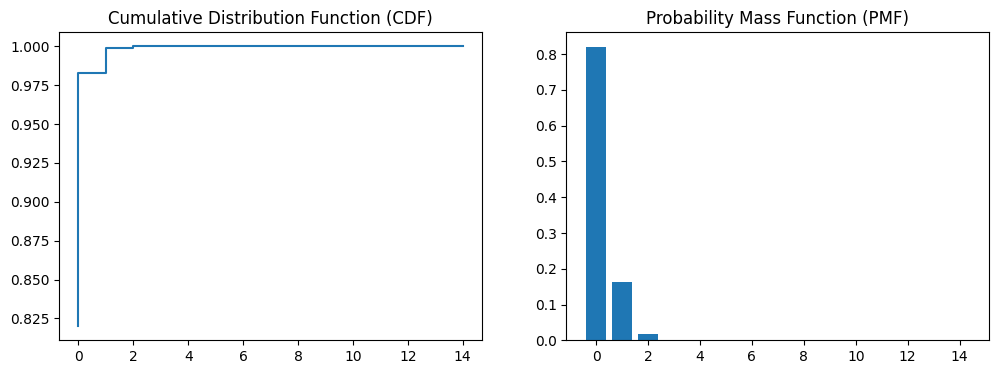

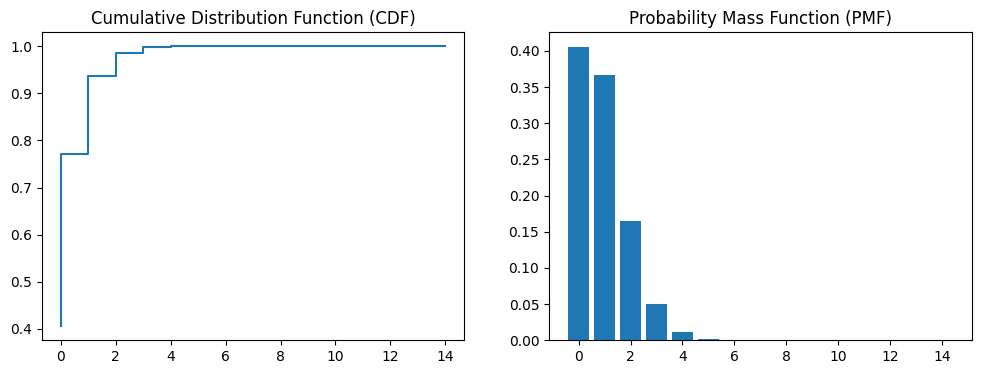



0 vs 1 Distributions
0    2
0    0
0    4
0    2
Name: Goals_Scored_0, dtype: object
1    0
1    1
1    3
1    4
Name: Goals_Scored_0, dtype: object


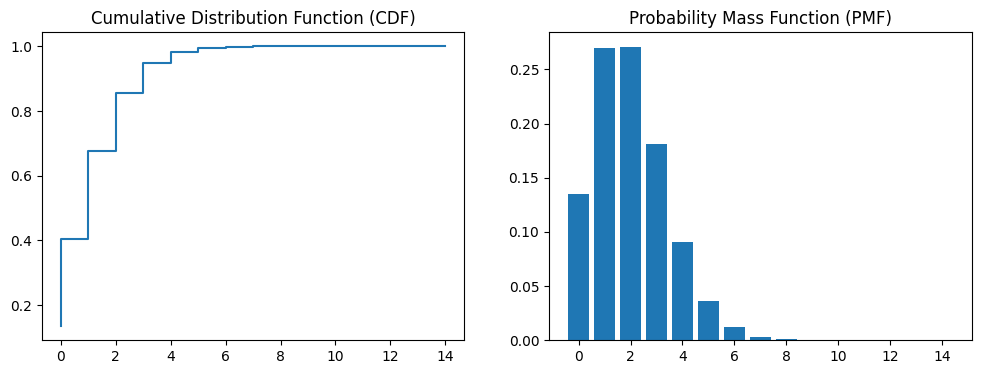

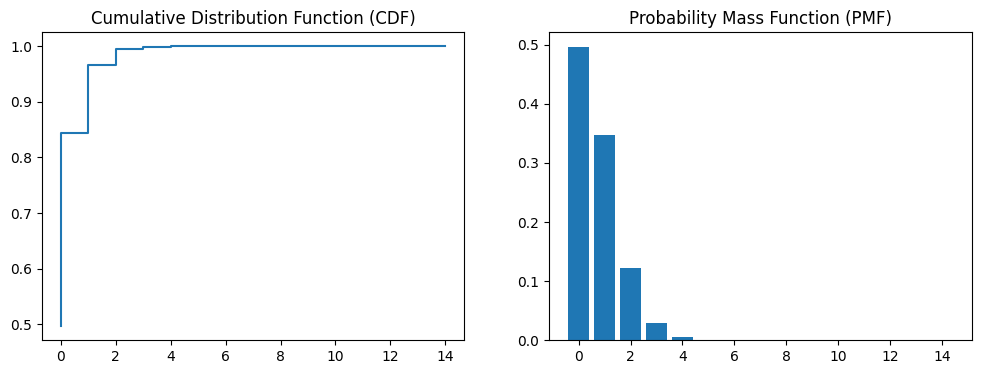



726 vs 727 Distributions
726    1
726    1
726    1
726    0
Name: Goals_Scored_0, dtype: object
727    2
727    0
727    0
727    1
Name: Goals_Scored_0, dtype: object


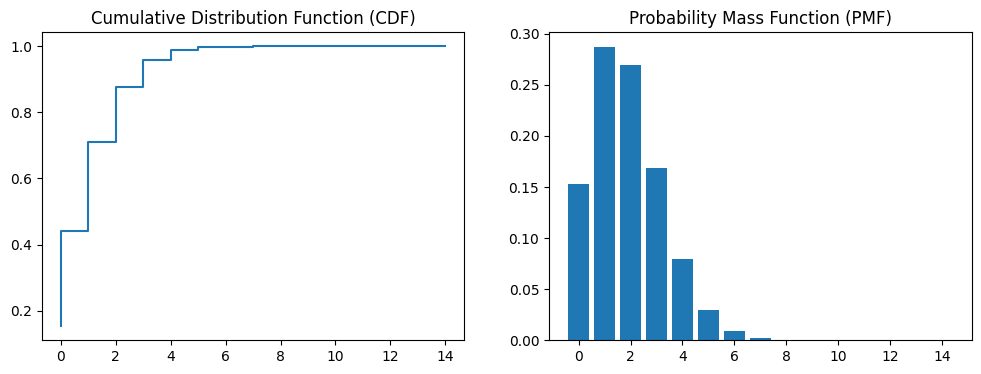

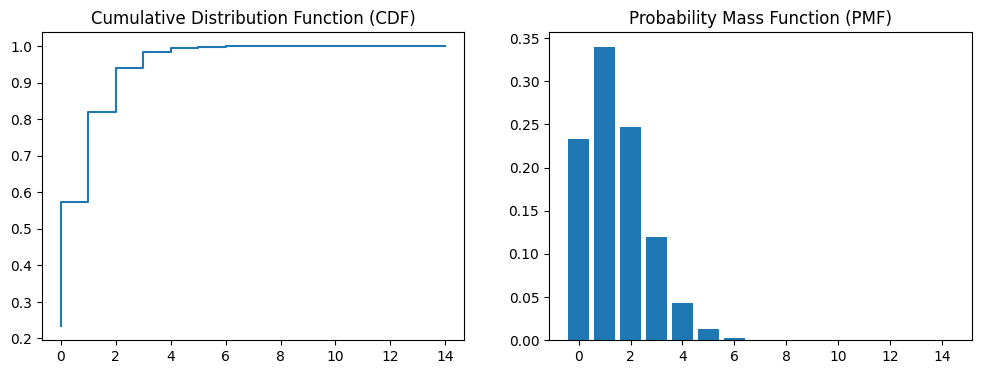



149 vs 148 Distributions
149    0
149    2
149    1
149    2
Name: Goals_Scored_0, dtype: object
148    0
148    1
148    2
148    0
Name: Goals_Scored_0, dtype: object


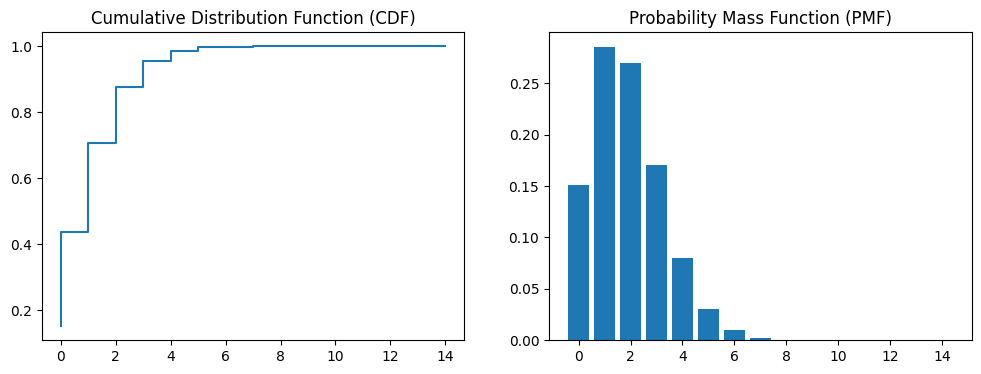

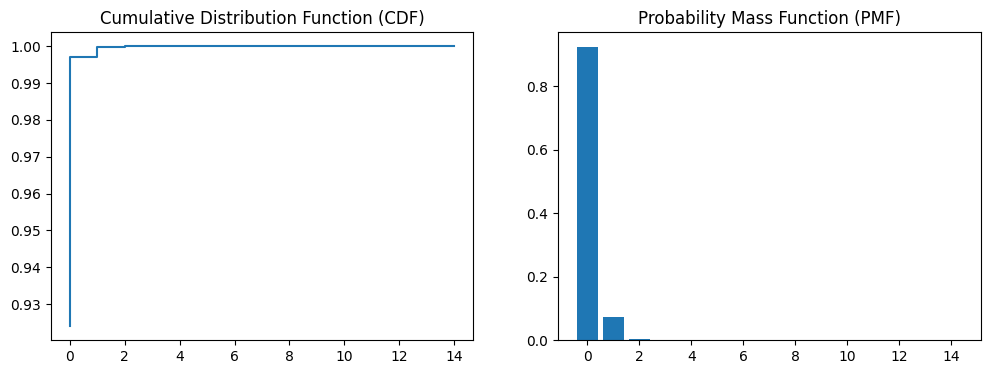



189 vs 188 Distributions
189    1
189    2
189    2
189    1
Name: Goals_Scored_0, dtype: object
188    0
188    5
188    2
188    0
Name: Goals_Scored_0, dtype: object


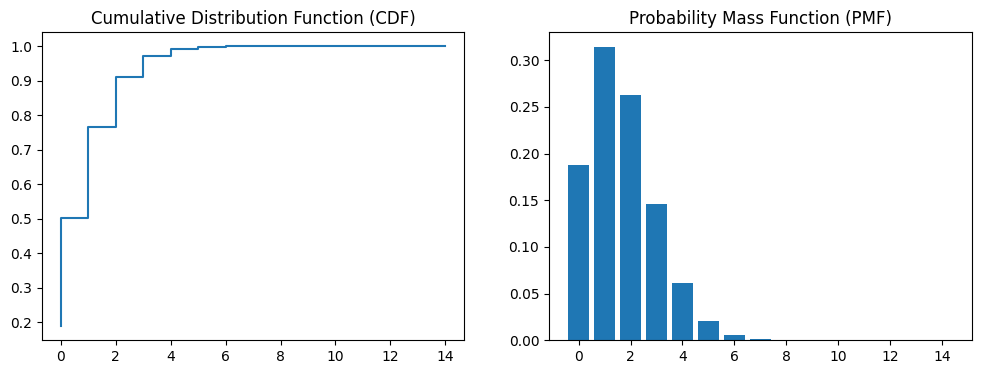

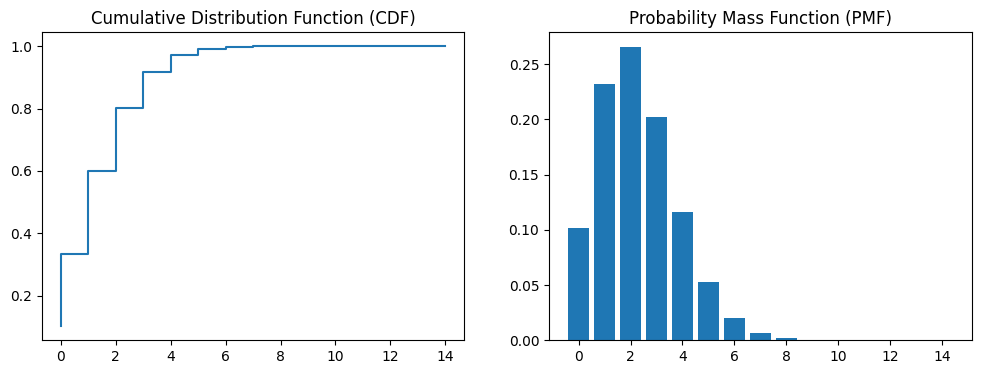



217 vs 216 Distributions
217    5
217    2
217    2
217    2
Name: Goals_Scored_0, dtype: object
216    1
216    2
216    5
216    0
Name: Goals_Scored_0, dtype: object


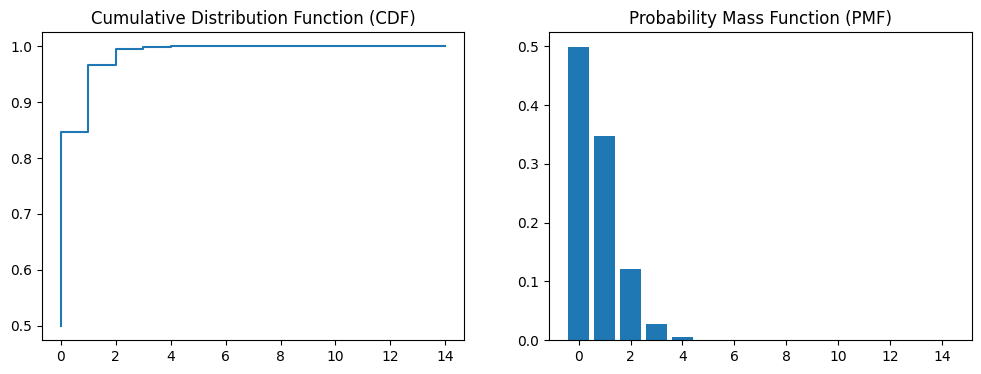

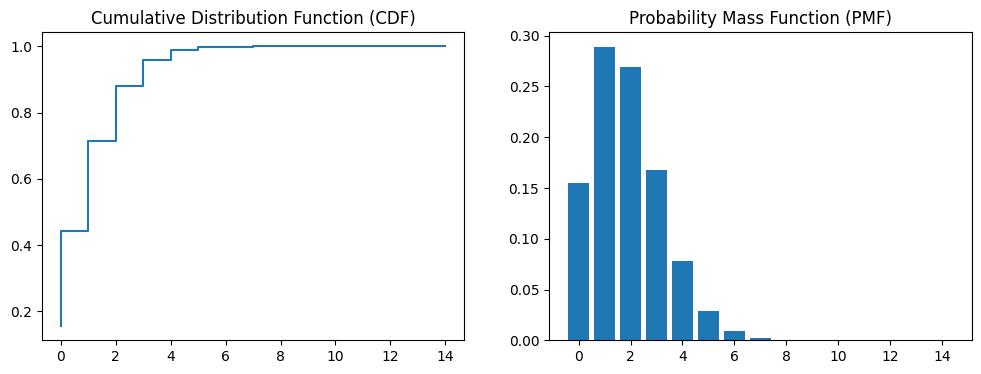



571 vs 570 Distributions
571    4
571    2
571    0
571    0
Name: Goals_Scored_0, dtype: object
570    0
570    3
570    0
570    3
Name: Goals_Scored_0, dtype: object


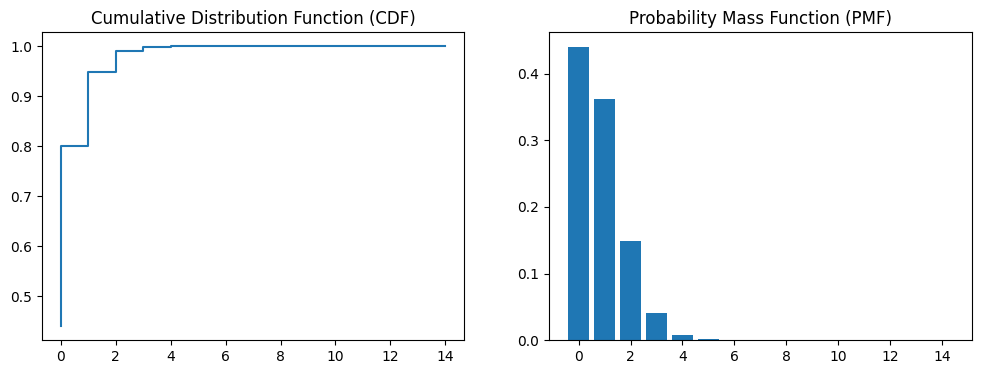

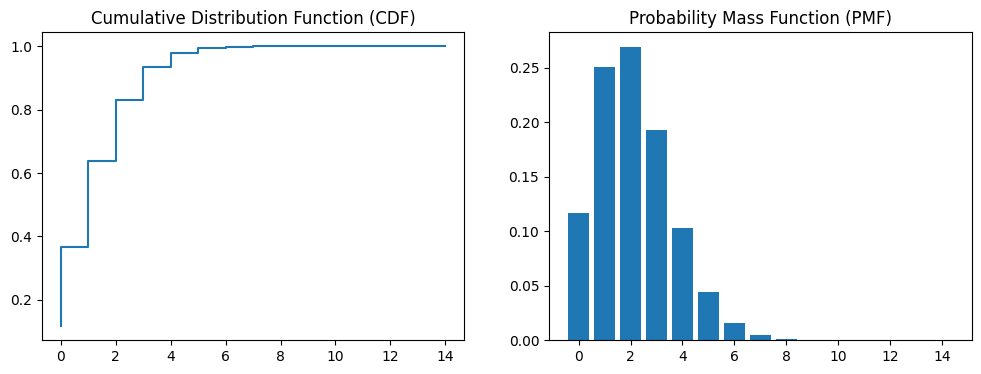



166 vs 167 Distributions
166    1
166    2
166    2
166    1
Name: Goals_Scored_0, dtype: object
167    2
167    1
167    0
167    1
Name: Goals_Scored_0, dtype: object


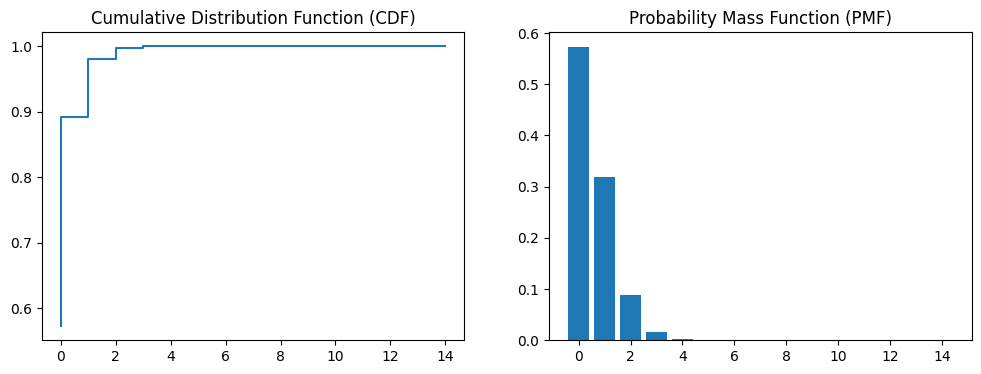

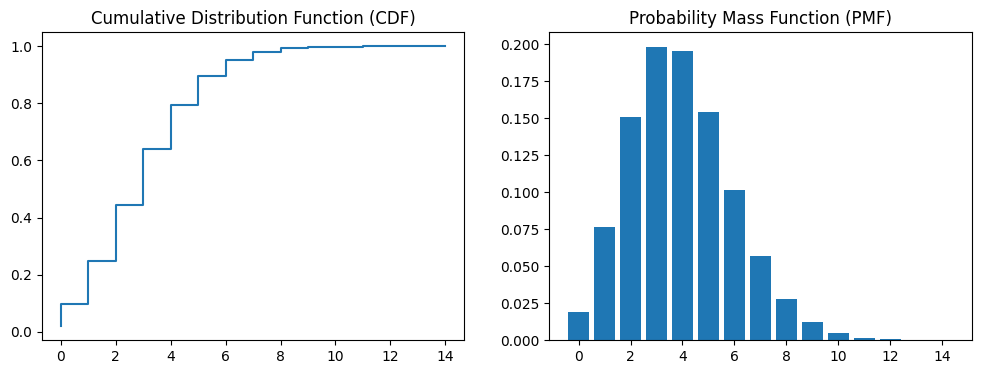



109 vs 108 Distributions
109    1
109    2
109    1
109    2
Name: Goals_Scored_0, dtype: object
108    0
108    2
108    1
108    0
Name: Goals_Scored_0, dtype: object


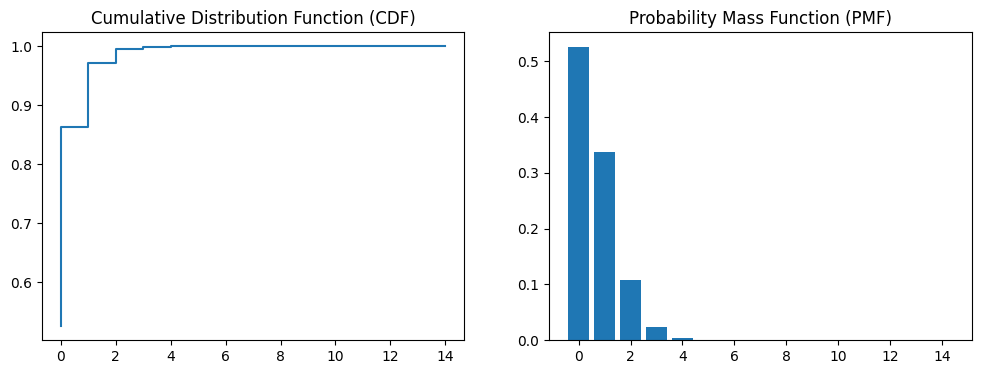

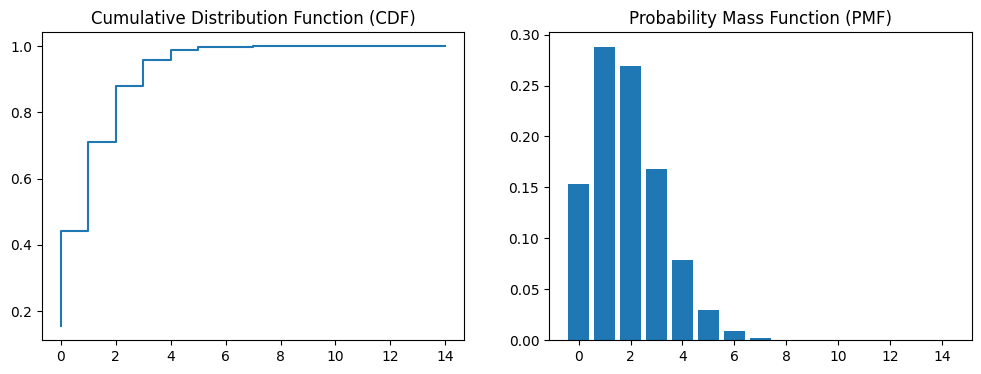



146 vs 147 Distributions
146    3
146    3
146    2
146    0
Name: Goals_Scored_0, dtype: object
147    1
147    7
147    1
147    0
Name: Goals_Scored_0, dtype: object


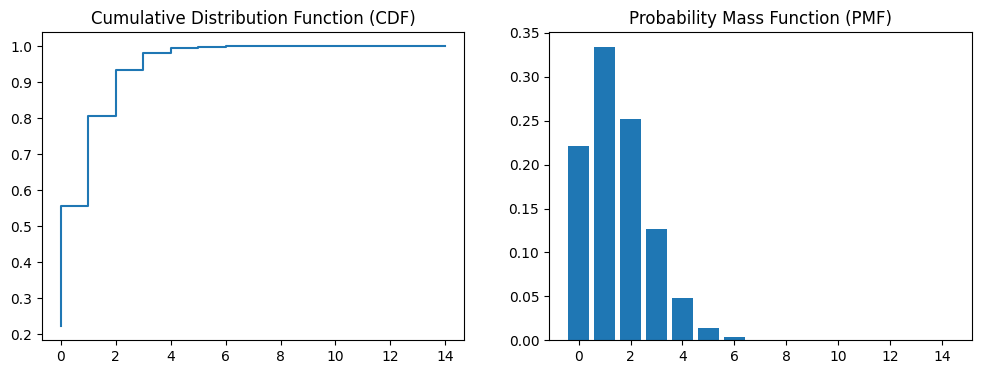

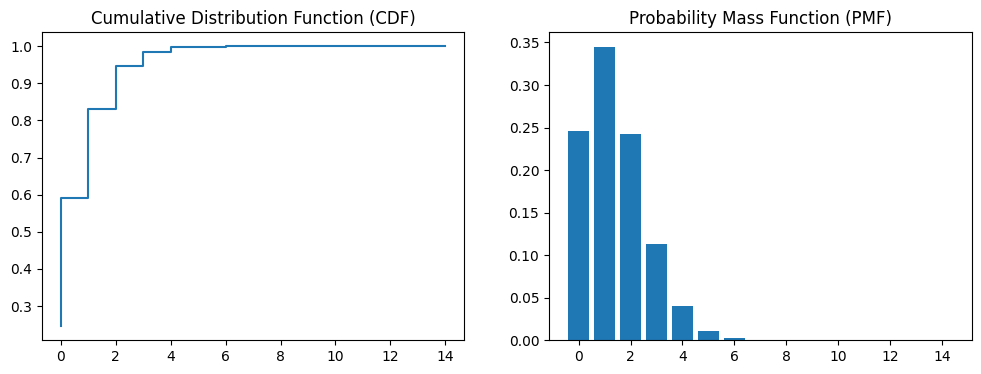



759 vs 758 Distributions
759    2
759    2
759    0
759    2
Name: Goals_Scored_0, dtype: object
758    1
758    0
758    0
758    5
Name: Goals_Scored_0, dtype: object


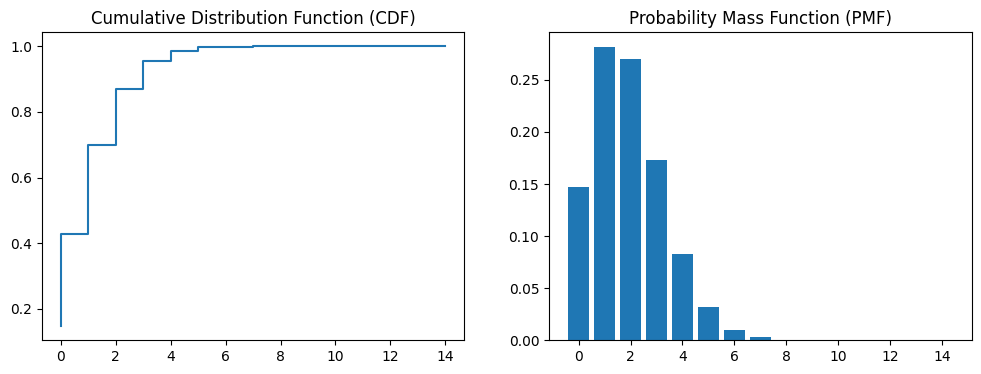

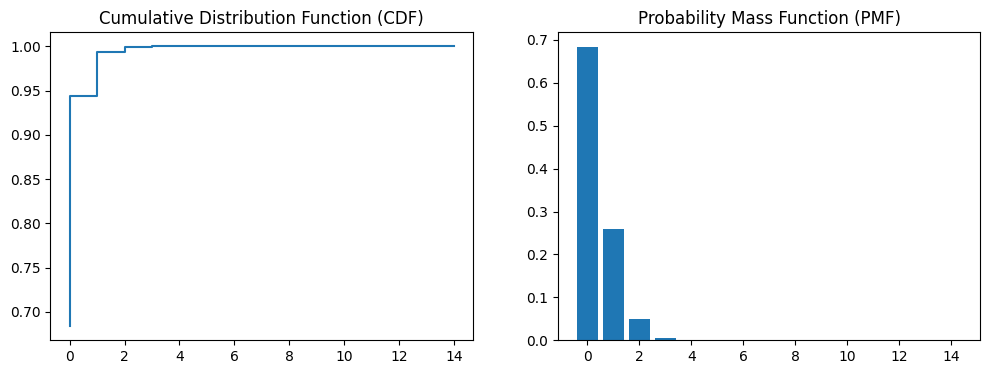



607 vs 606 Distributions
607    2
607    2
607    0
607    0
Name: Goals_Scored_0, dtype: object
606    0
606    0
606    2
606    3
Name: Goals_Scored_0, dtype: object


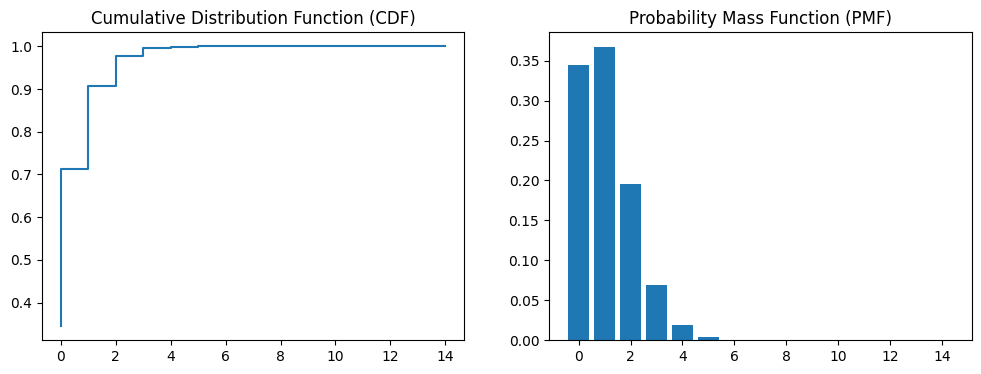

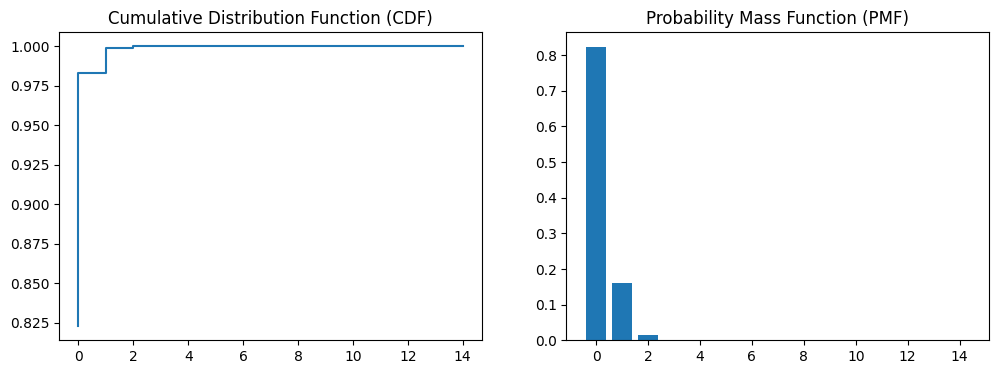



586 vs 587 Distributions
586    3
586    1
586    0
586    3
Name: Goals_Scored_0, dtype: object
587    4
587    1
587    1
587    1
Name: Goals_Scored_0, dtype: object


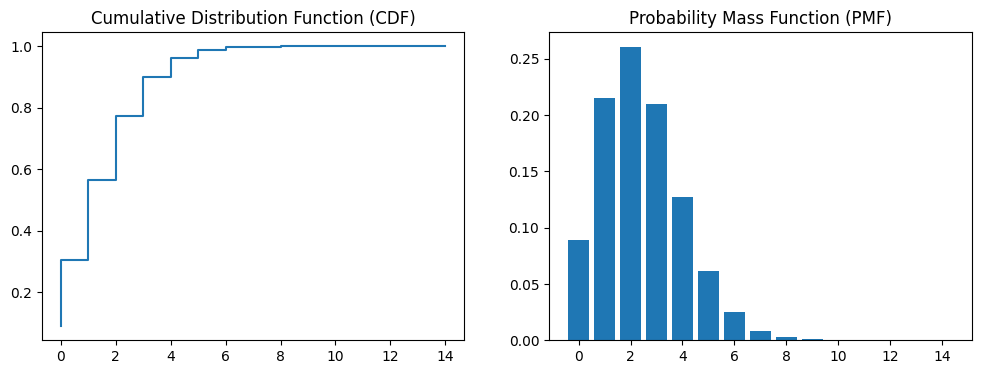

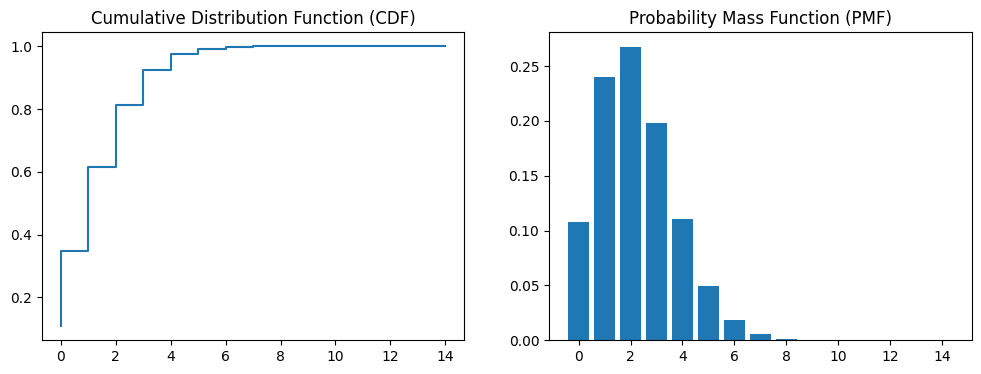



737 vs 736 Distributions
737    2
737    2
737    2
737    0
Name: Goals_Scored_0, dtype: object
736    0
736    0
736    0
736    2
Name: Goals_Scored_0, dtype: object


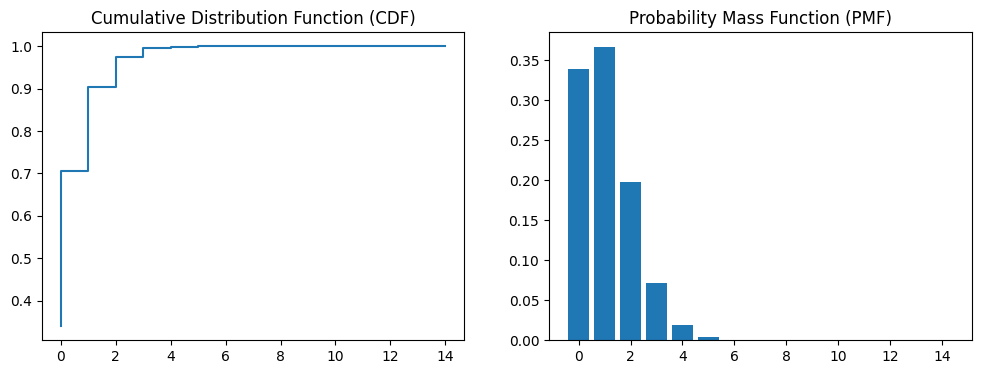

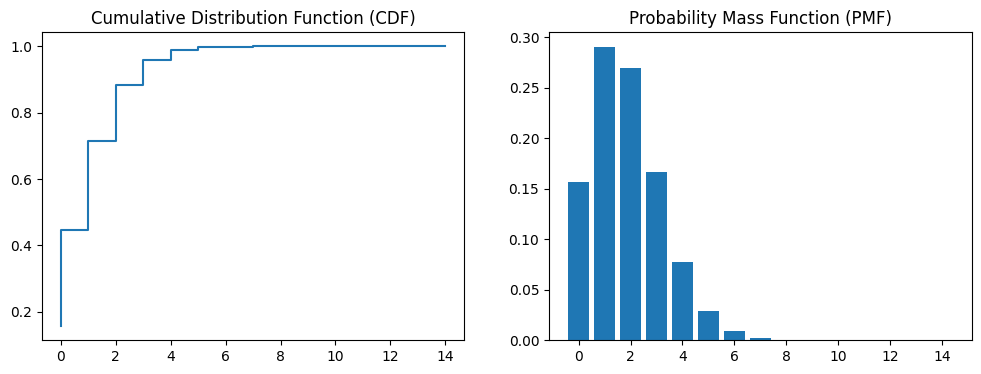



628 vs 629 Distributions
628    4
628    4
628    0
628    0
Name: Goals_Scored_0, dtype: object
629    0
629    2
629    1
629    0
Name: Goals_Scored_0, dtype: object


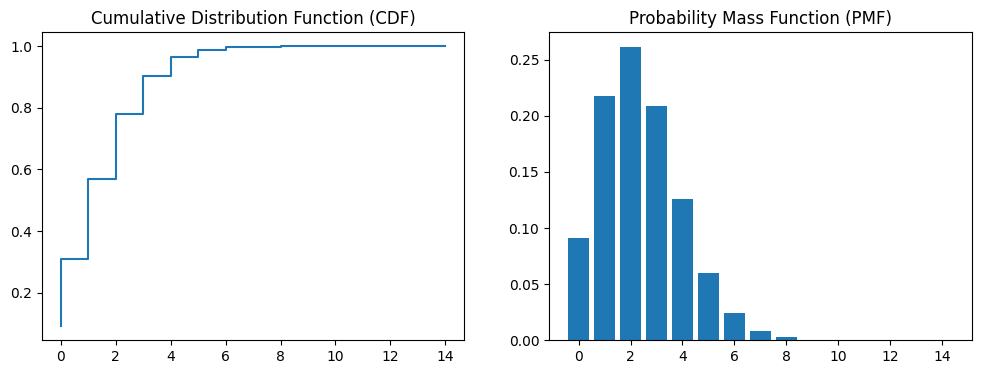

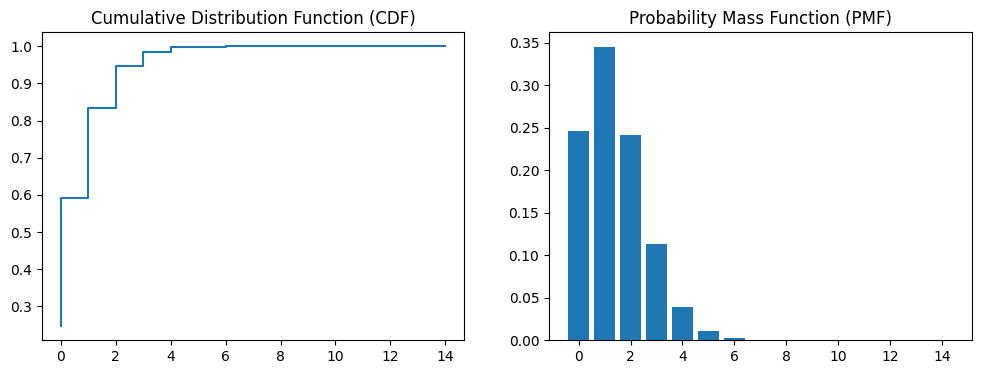



535 vs 534 Distributions
535    1
535    1
535    2
535    5
Name: Goals_Scored_0, dtype: object
534    3
534    2
534    3
534    1
Name: Goals_Scored_0, dtype: object


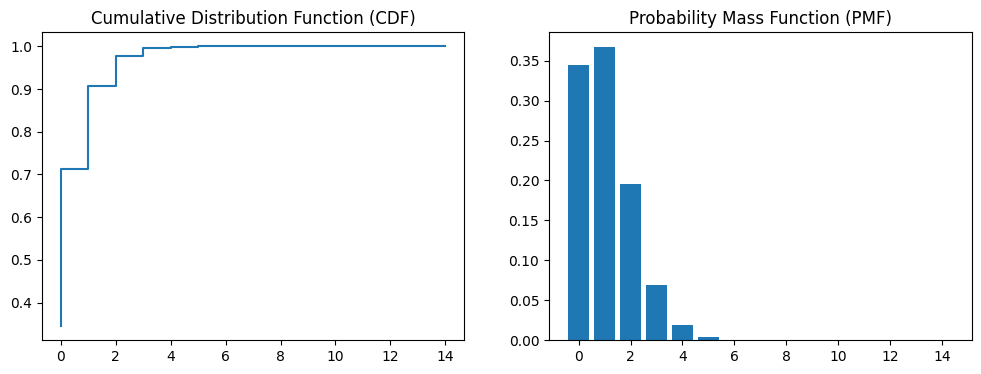

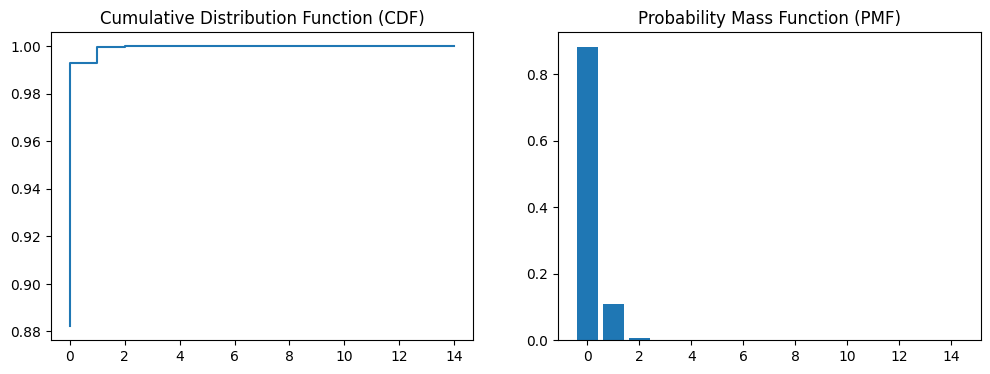



643 vs 642 Distributions
643    0
643    0
643    1
643    2
Name: Goals_Scored_0, dtype: object
642    1
642    1
642    3
642    1
Name: Goals_Scored_0, dtype: object


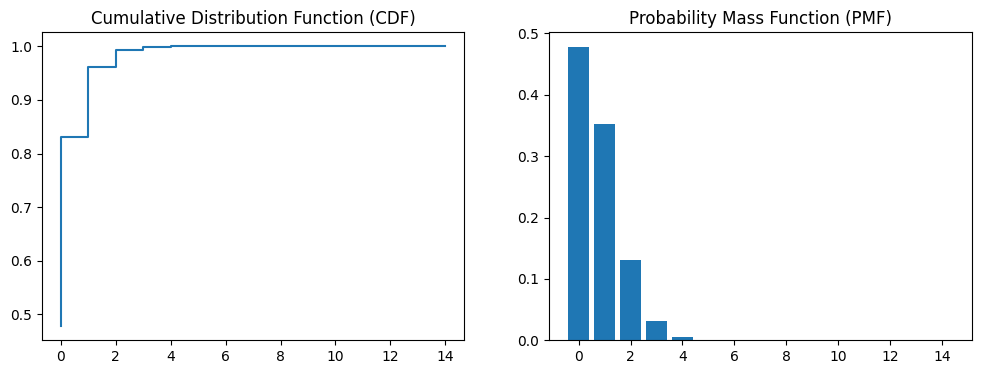

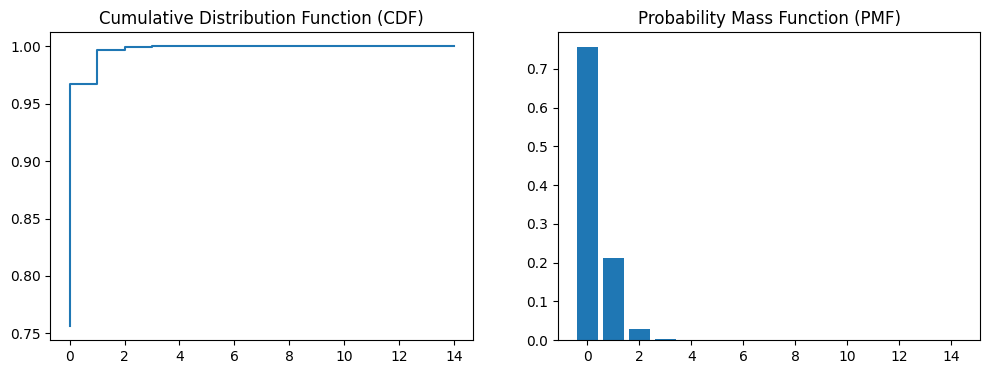



12 vs 13 Distributions
12    0
12    1
12    0
12    1
Name: Goals_Scored_0, dtype: object
13    2
13    2
13    2
13    1
Name: Goals_Scored_0, dtype: object


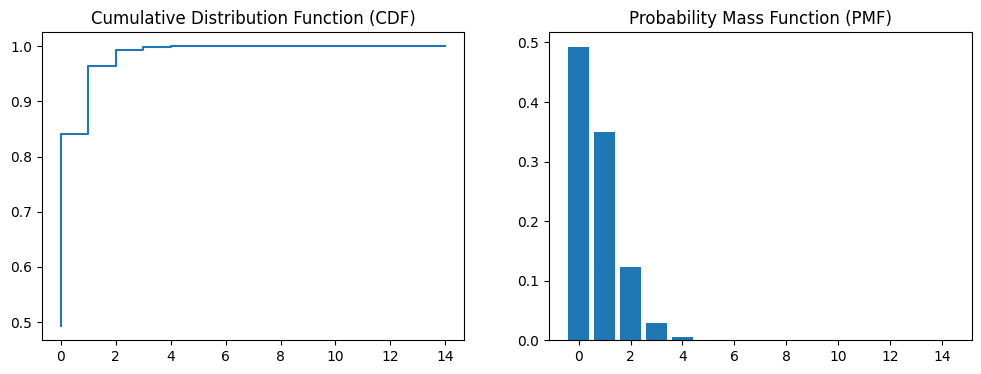

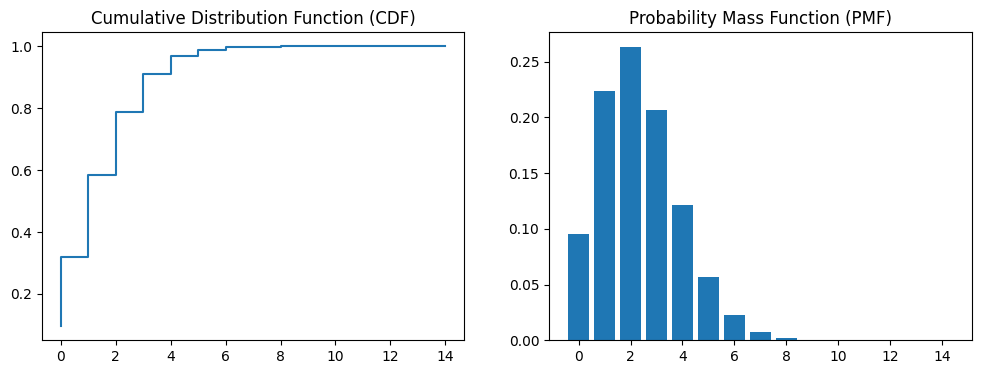



717 vs 716 Distributions
717    1
717    1
717    1
717    0
Name: Goals_Scored_0, dtype: object
716    1
716    4
716    2
716    2
Name: Goals_Scored_0, dtype: object


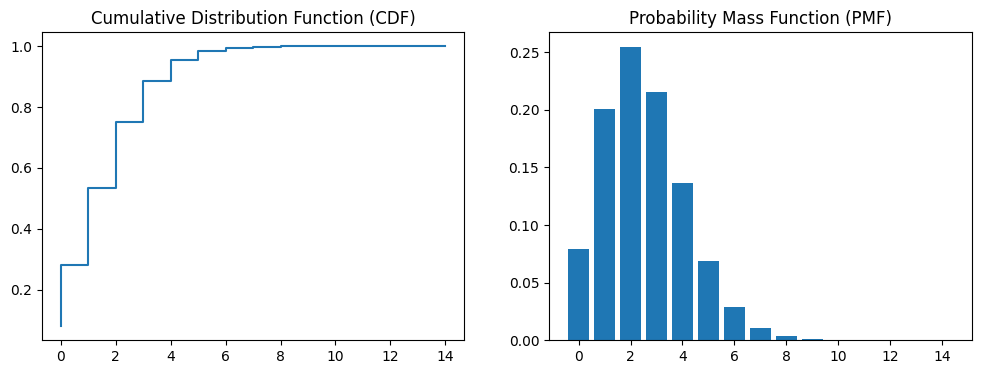

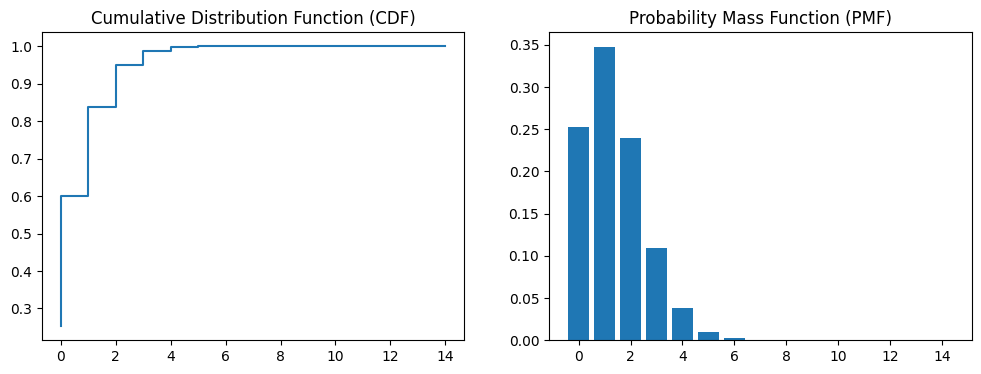



459 vs 458 Distributions
459    1
459    2
459    2
459    1
Name: Goals_Scored_0, dtype: object
458    1
458    2
458    0
458    0
Name: Goals_Scored_0, dtype: object


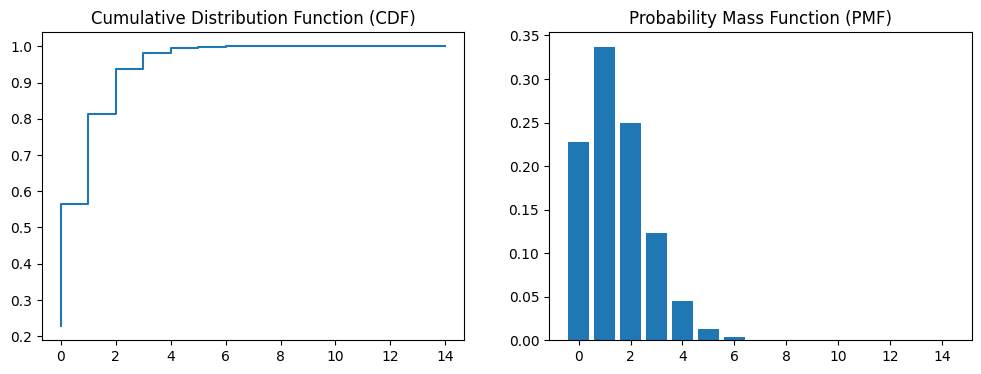

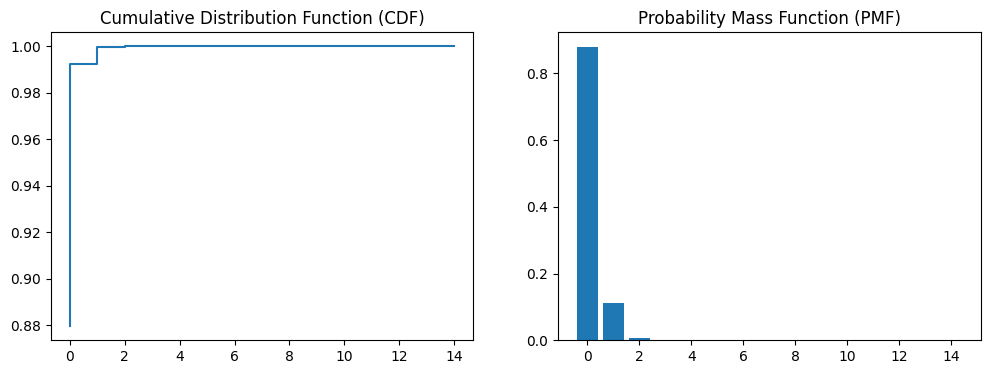



272 vs 273 Distributions
272    1
272    3
272    0
272    3
Name: Goals_Scored_0, dtype: object
273    1
273    3
273    0
273    2
Name: Goals_Scored_0, dtype: object


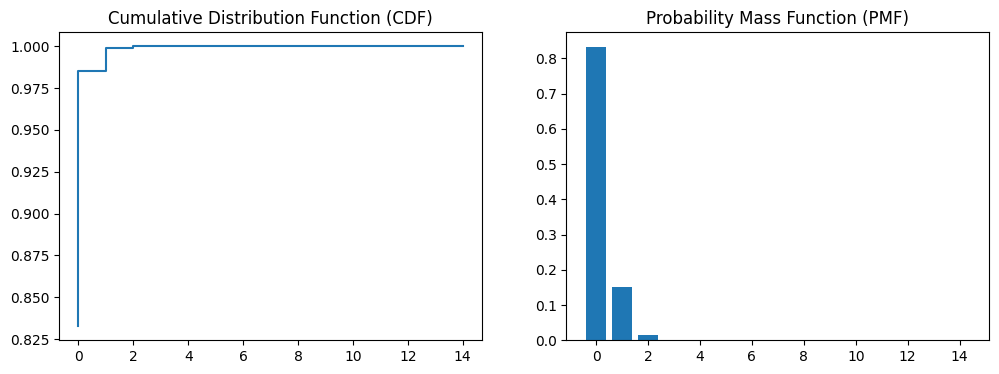

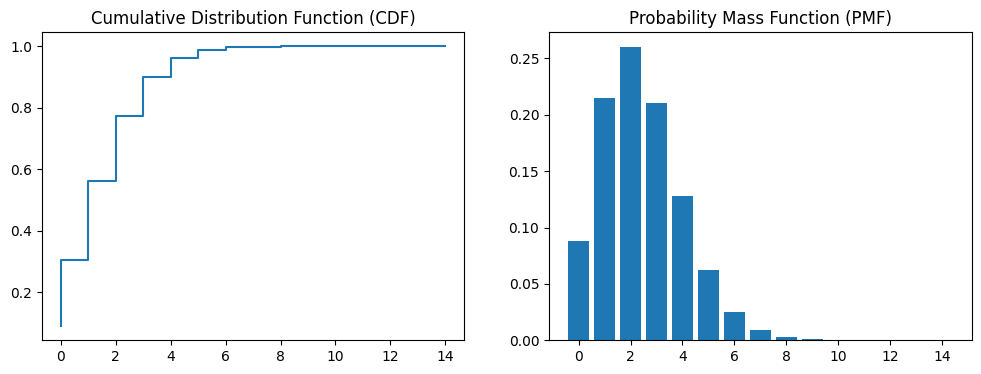



503 vs 502 Distributions
503    1
503    0
503    1
503    0
Name: Goals_Scored_0, dtype: object
502    0
502    0
502    0
502    0
Name: Goals_Scored_0, dtype: object


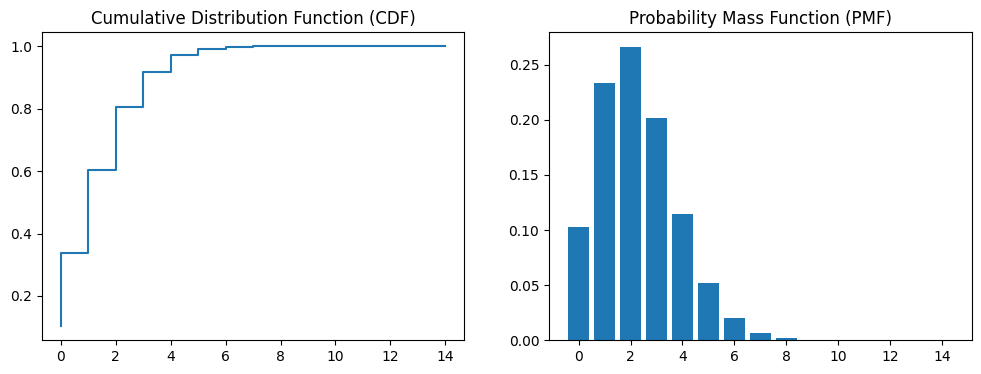

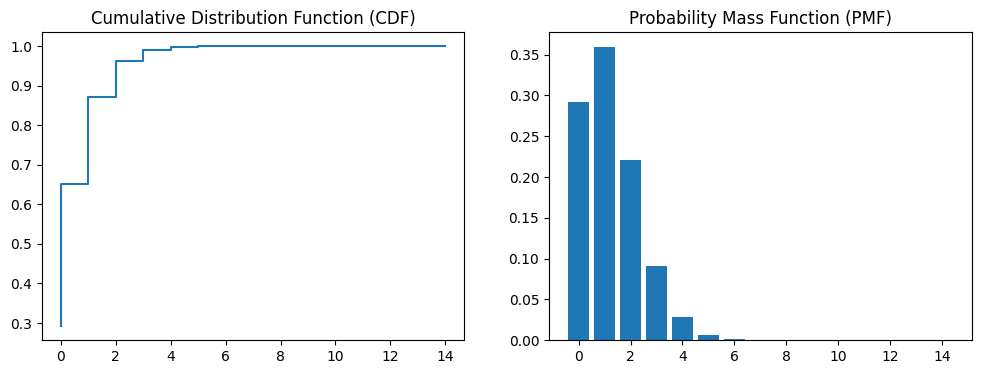



628 vs 629 Distributions
628    4
628    4
628    0
628    0
Name: Goals_Scored_0, dtype: object
629    0
629    2
629    1
629    0
Name: Goals_Scored_0, dtype: object


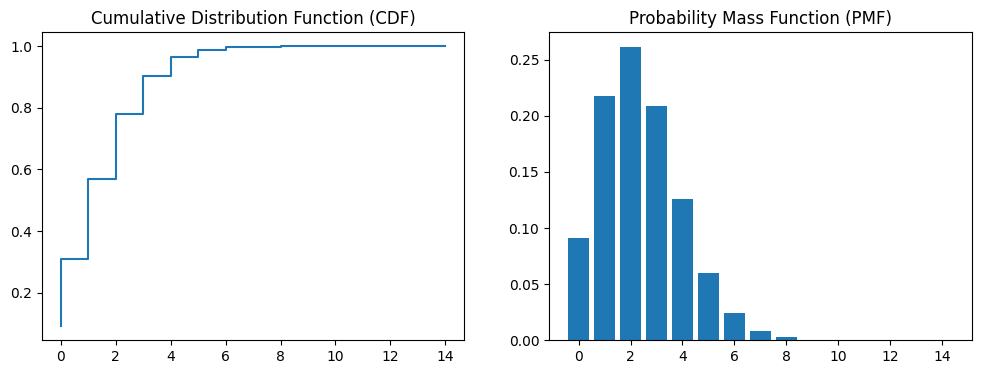

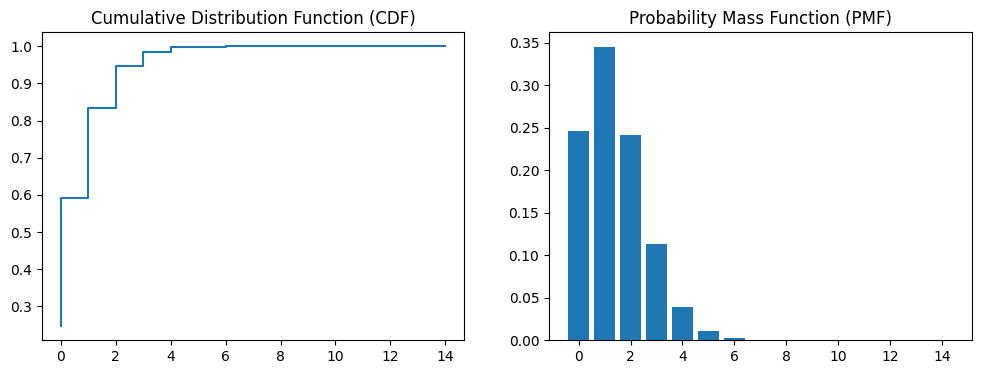



103 vs 102 Distributions
103    4
103    1
103    0
103    1
Name: Goals_Scored_0, dtype: object
102    1
102    1
102    0
102    3
Name: Goals_Scored_0, dtype: object


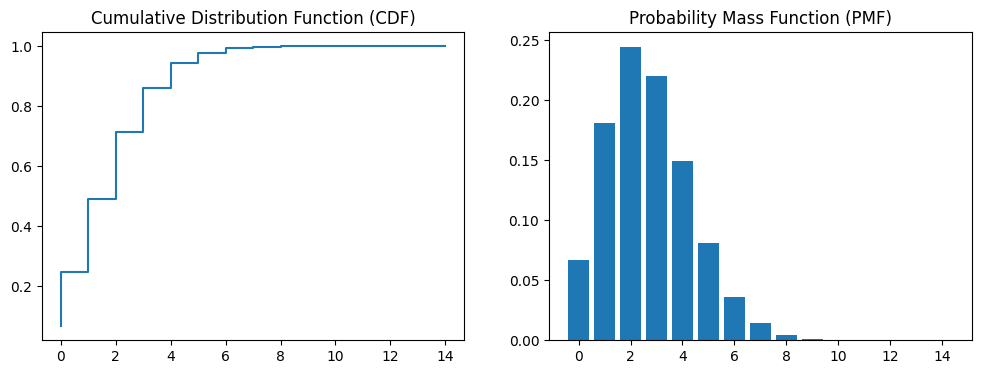

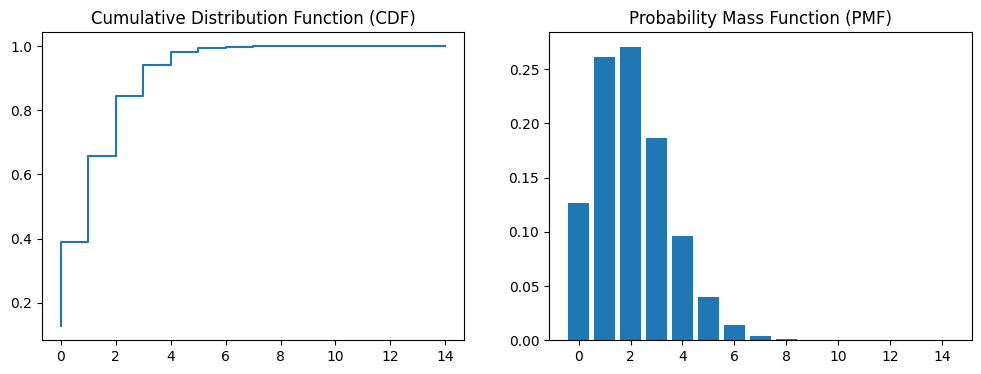



350 vs 351 Distributions
350    0
350    0
350    3
350    2
Name: Goals_Scored_0, dtype: object
351    1
351    3
351    2
351    2
Name: Goals_Scored_0, dtype: object


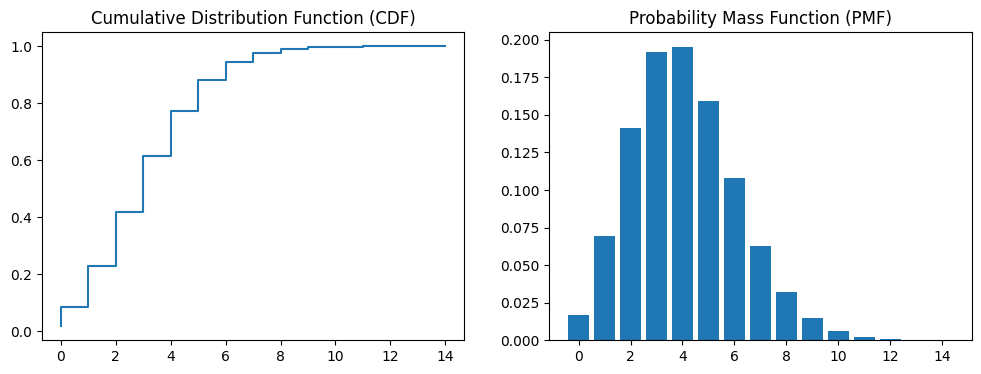

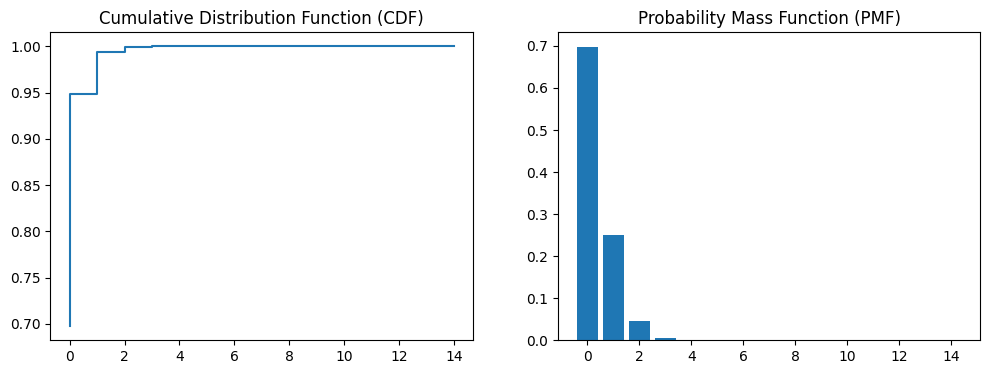



157 vs 156 Distributions
157    1
157    2
157    2
157    2
Name: Goals_Scored_0, dtype: object
156    2
156    0
156    2
156    1
Name: Goals_Scored_0, dtype: object


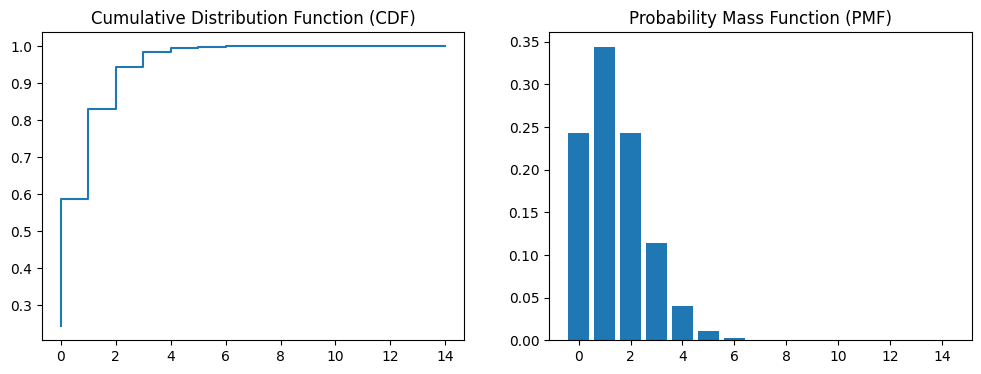

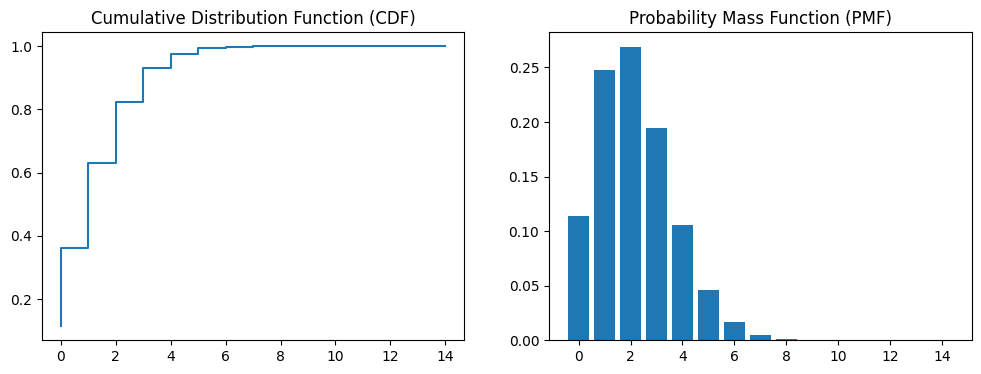



634 vs 635 Distributions
634    2
634    1
634    2
634    0
Name: Goals_Scored_0, dtype: object
635    2
635    1
635    1
635    1
Name: Goals_Scored_0, dtype: object


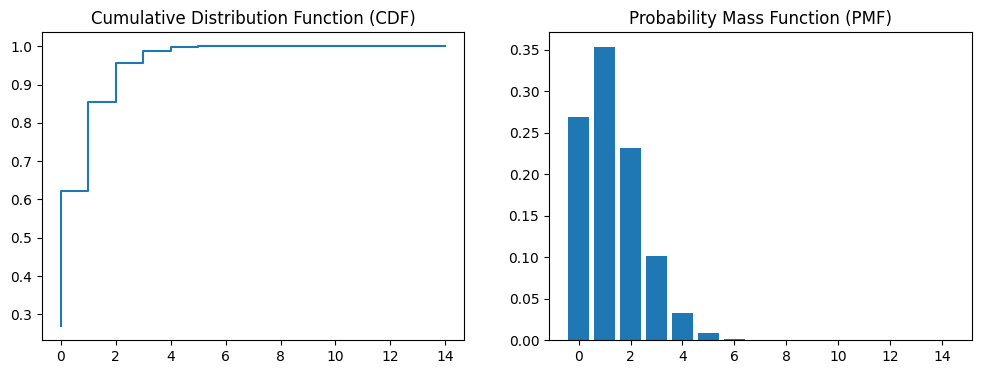

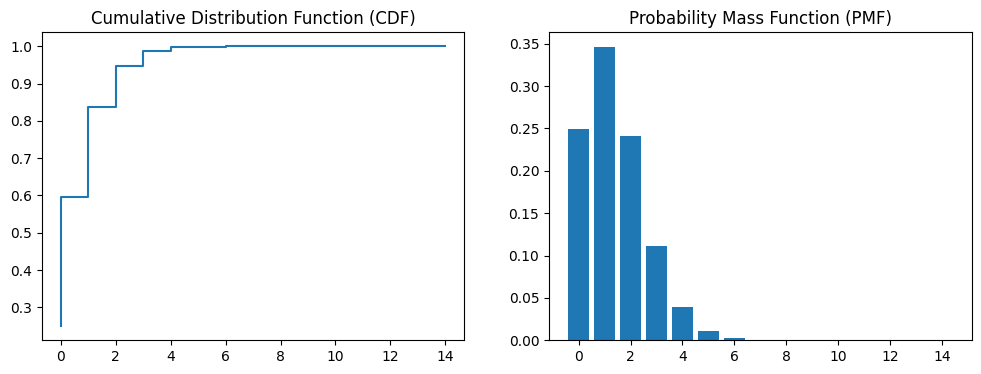



727 vs 726 Distributions
727    2
727    0
727    0
727    1
Name: Goals_Scored_0, dtype: object
726    1
726    1
726    1
726    0
Name: Goals_Scored_0, dtype: object


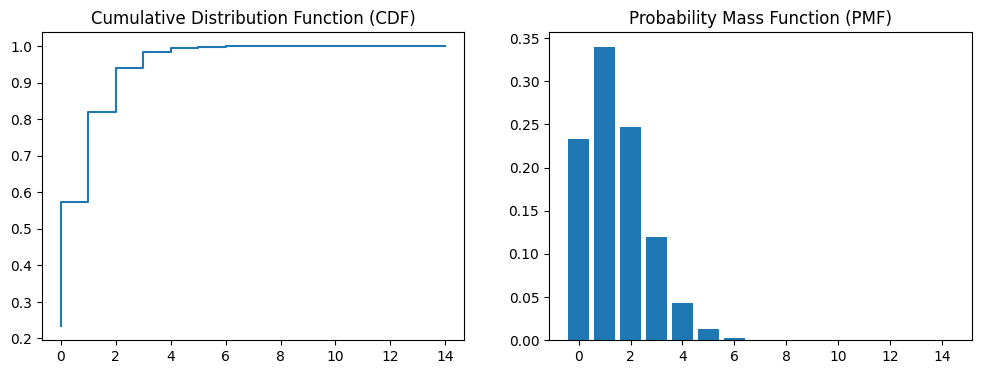

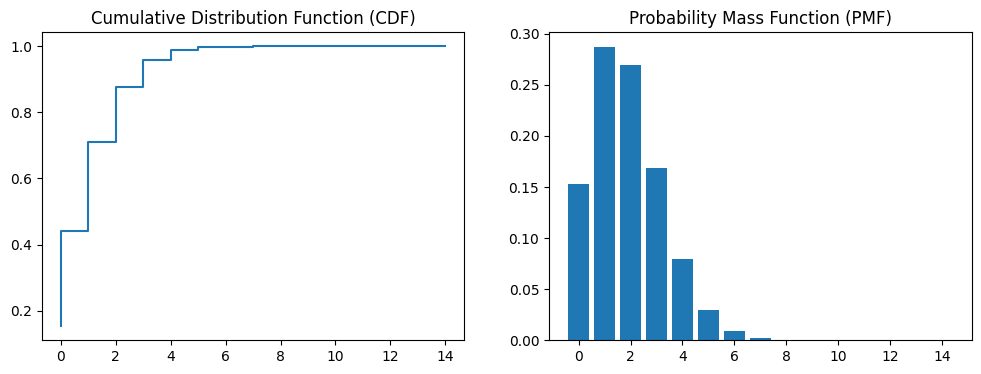



281 vs 280 Distributions
281    0
281    2
281    2
281    4
Name: Goals_Scored_0, dtype: object
280    1
280    2
280    1
280    2
Name: Goals_Scored_0, dtype: object


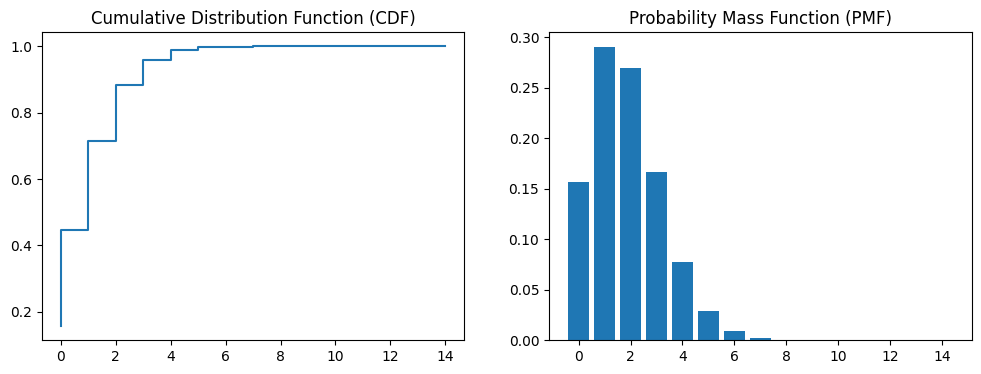

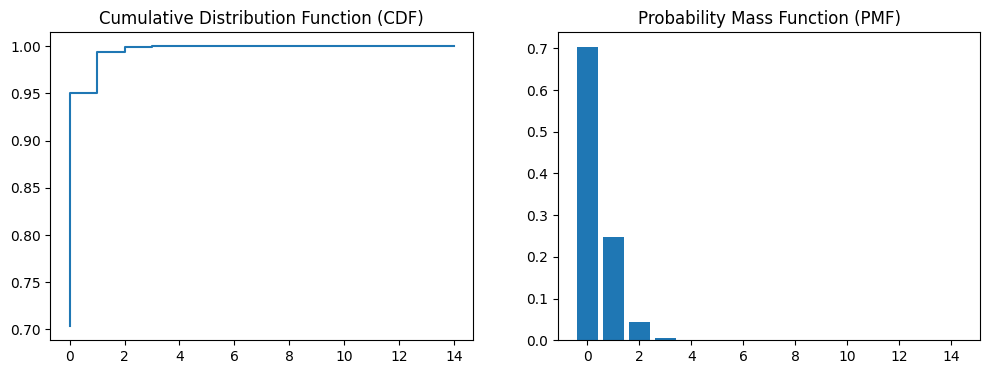



233 vs 232 Distributions
233    1
233    0
233    3
233    0
Name: Goals_Scored_0, dtype: object
232    0
232    2
232    3
232    3
Name: Goals_Scored_0, dtype: object


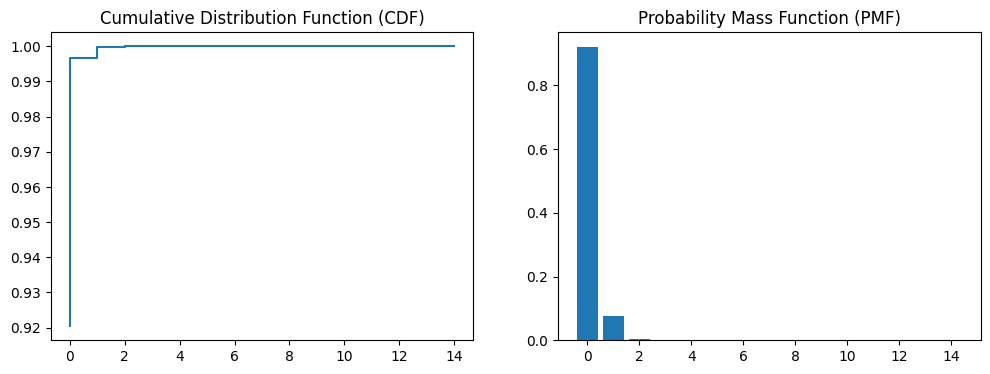

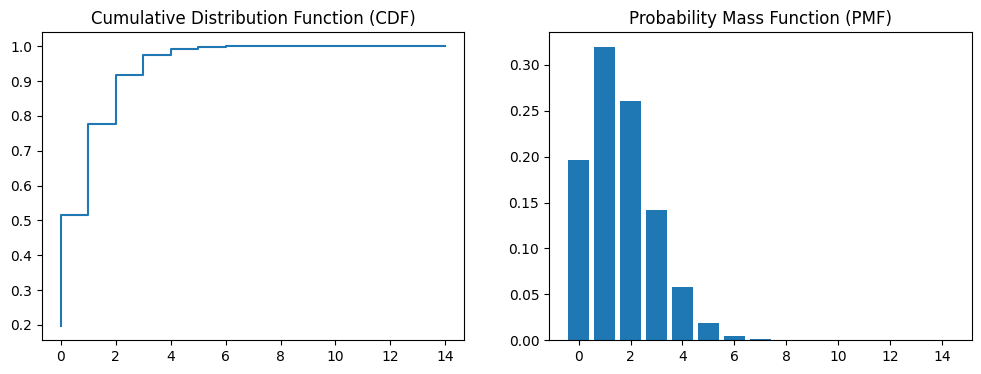



576 vs 577 Distributions
576    0
576    2
576    2
576    0
Name: Goals_Scored_0, dtype: object
577    3
577    1
577    0
577    4
Name: Goals_Scored_0, dtype: object


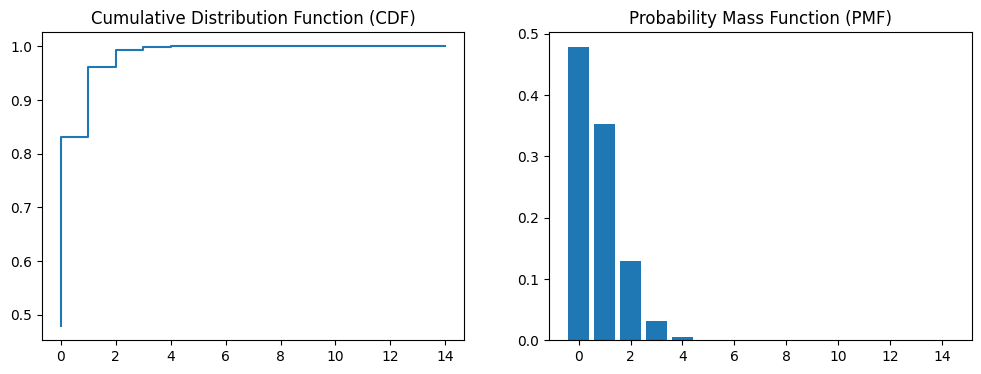

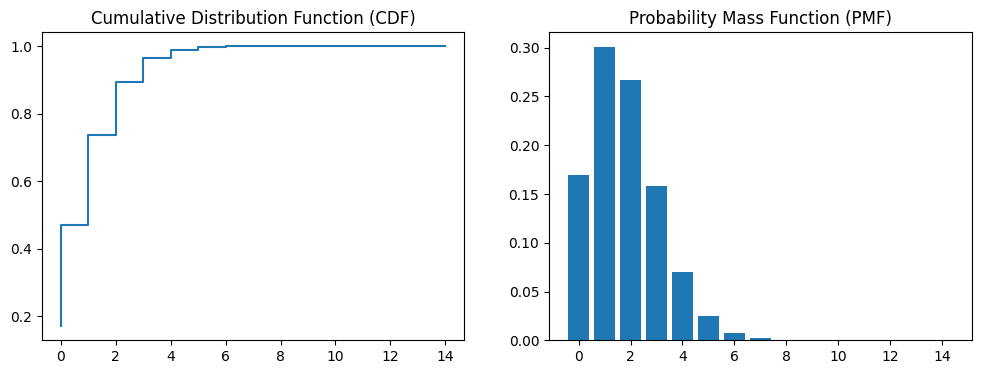



682 vs 683 Distributions
682    0
682    0
682    2
682    1
Name: Goals_Scored_0, dtype: object
683    0
683    2
683    2
683    0
Name: Goals_Scored_0, dtype: object


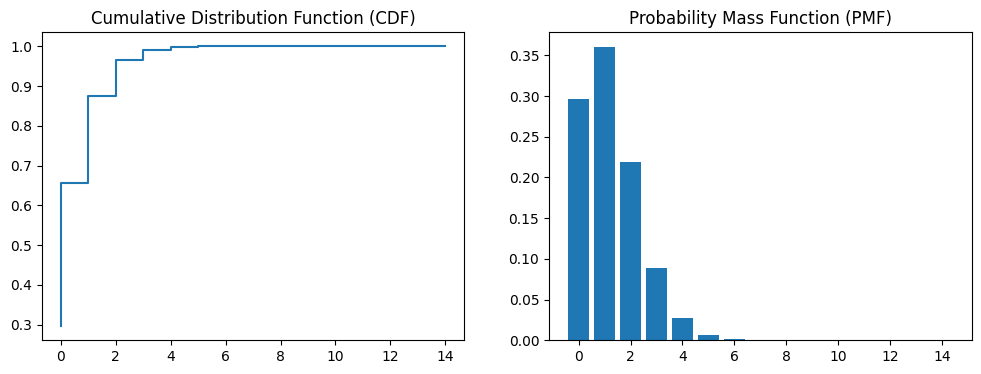

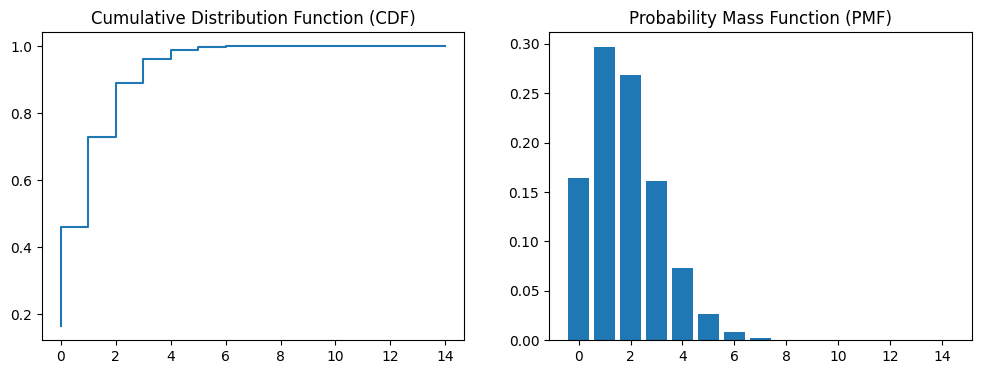



41 vs 40 Distributions
41    4
41    2
41    2
41    4
Name: Goals_Scored_0, dtype: object
40    0
40    1
40    1
40    1
Name: Goals_Scored_0, dtype: object


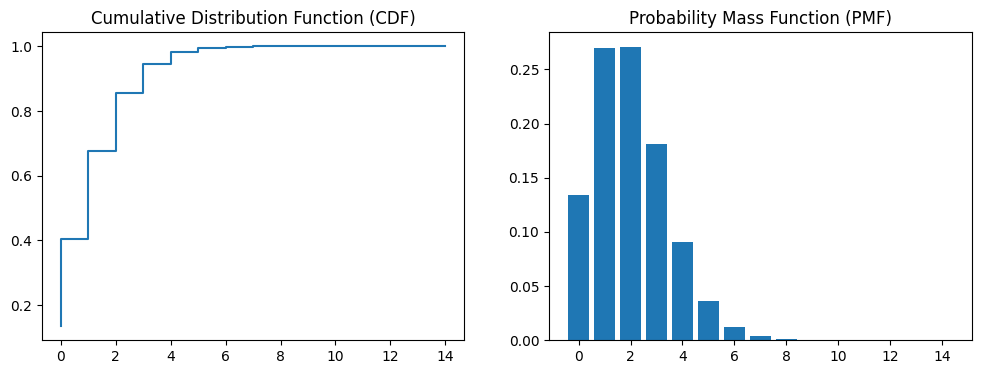

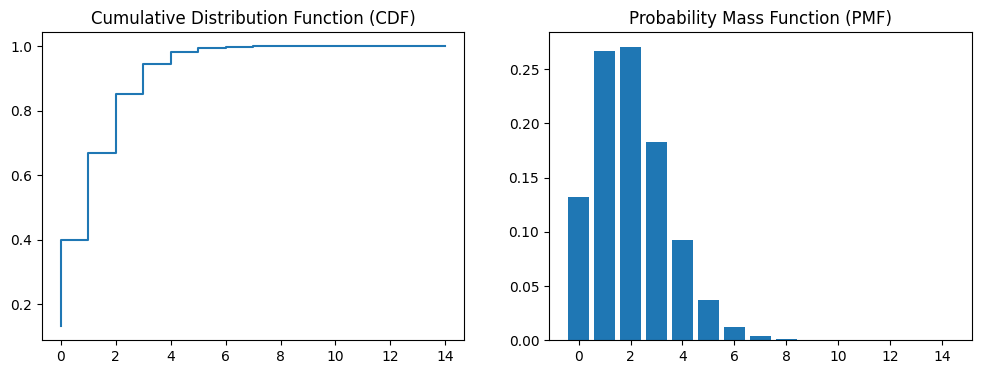



524 vs 525 Distributions
524    0
524    0
524    3
524    0
Name: Goals_Scored_0, dtype: object
525    1
525    1
525    2
525    1
Name: Goals_Scored_0, dtype: object


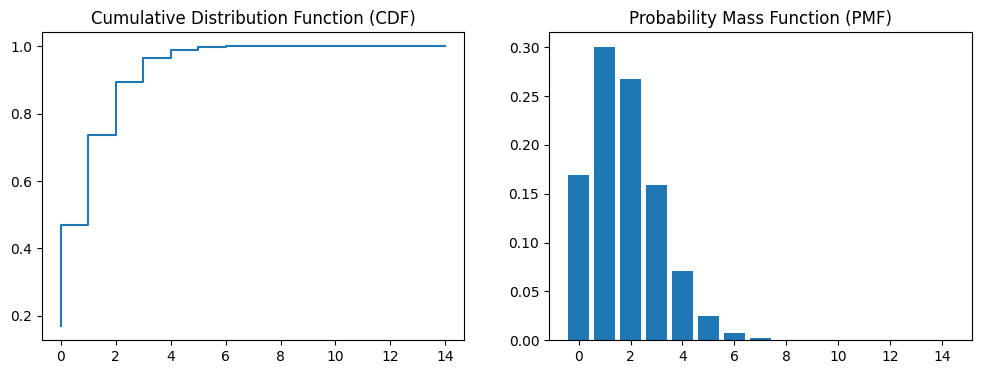

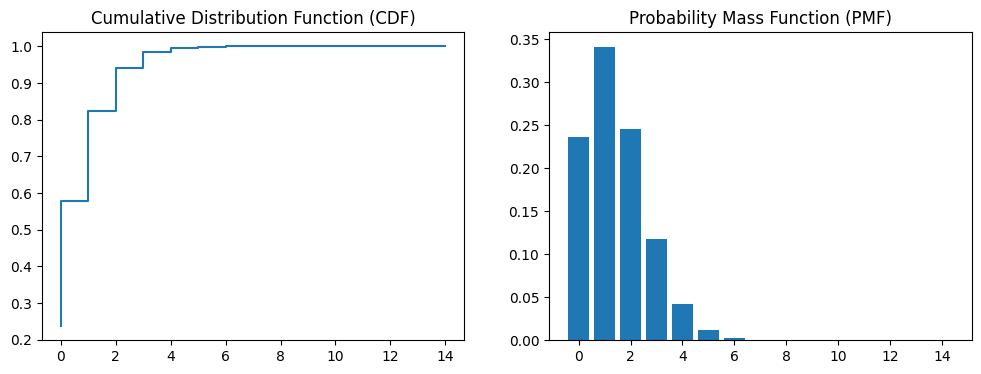



351 vs 350 Distributions
351    1
351    3
351    2
351    2
Name: Goals_Scored_0, dtype: object
350    0
350    0
350    3
350    2
Name: Goals_Scored_0, dtype: object


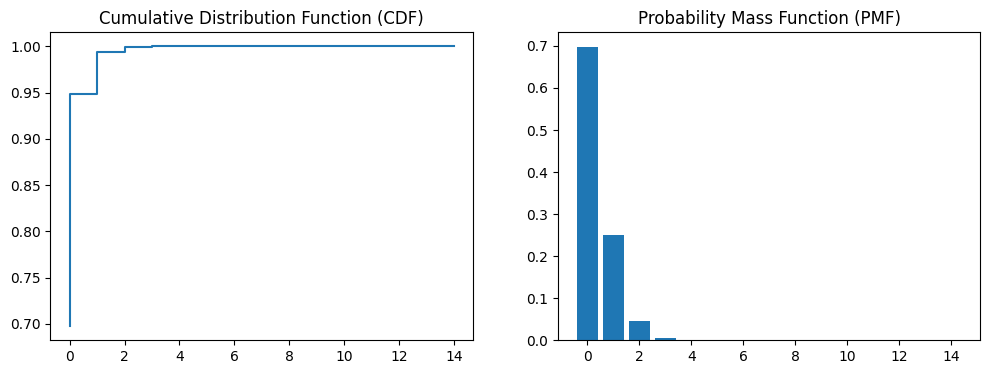

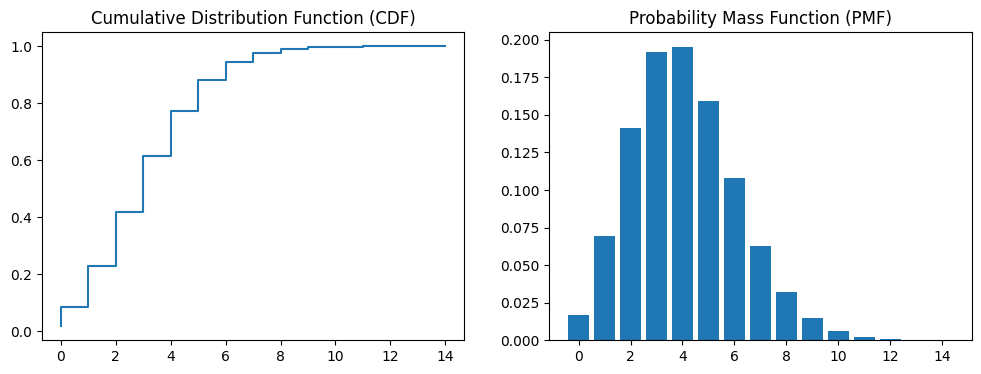



482 vs 483 Distributions
482    2
482    0
482    1
482    1
Name: Goals_Scored_0, dtype: object
483    1
483    1
483    2
483    1
Name: Goals_Scored_0, dtype: object


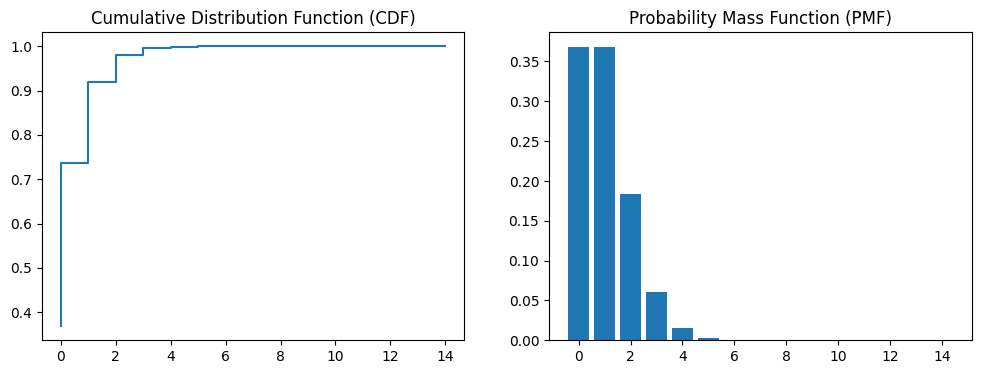

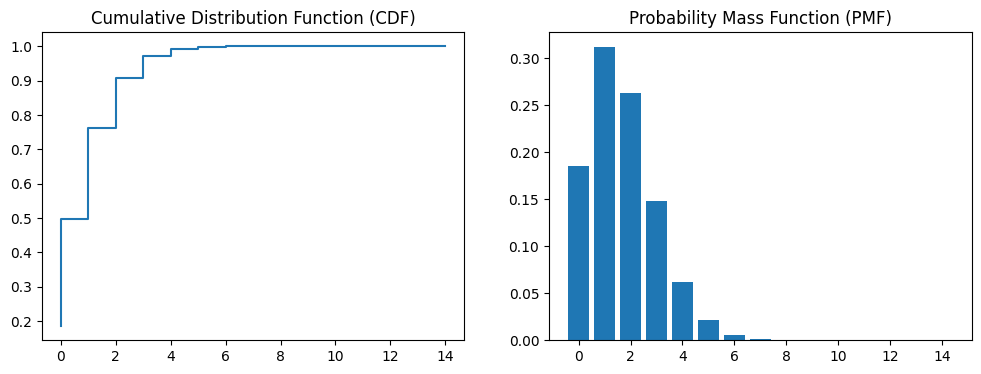



575 vs 574 Distributions
575    0
575    0
575    1
575    1
Name: Goals_Scored_0, dtype: object
574    3
574    1
574    4
574    1
Name: Goals_Scored_0, dtype: object


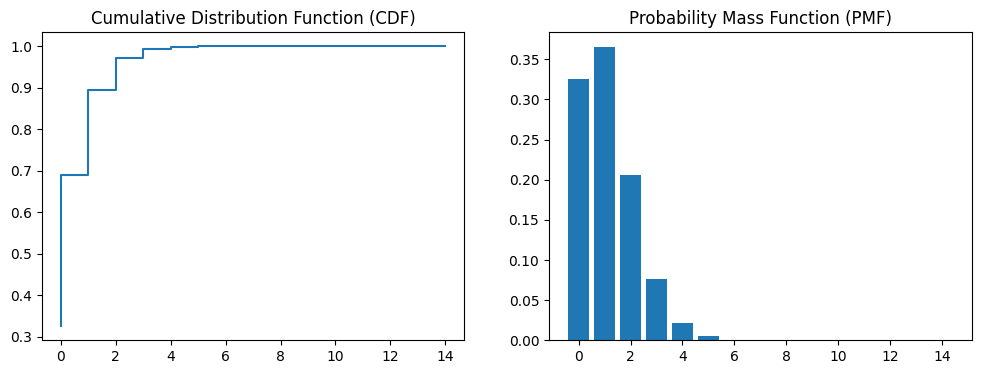

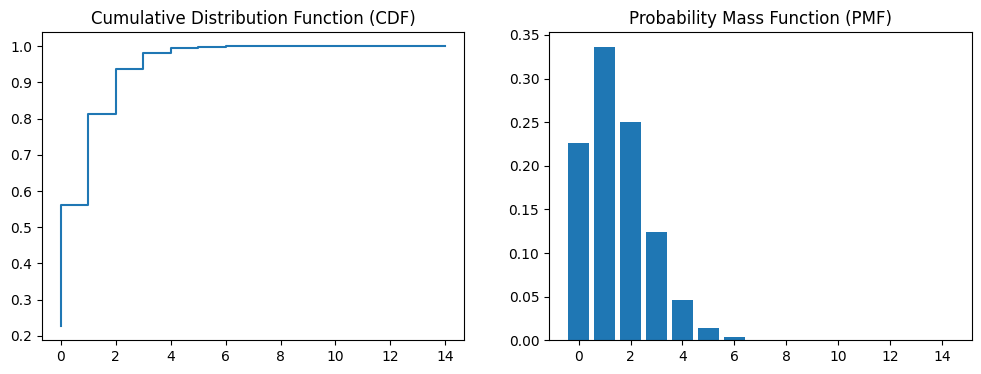



626 vs 627 Distributions
626    0
626    1
626    3
626    2
Name: Goals_Scored_0, dtype: object
627    5
627    0
627    0
627    0
Name: Goals_Scored_0, dtype: object


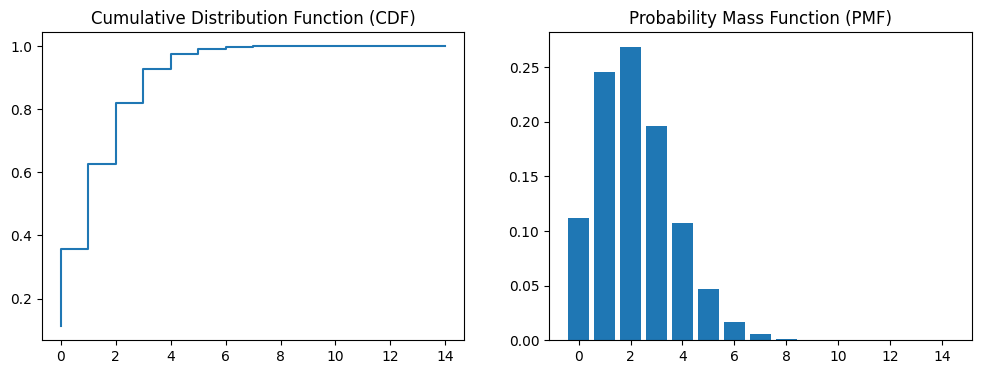

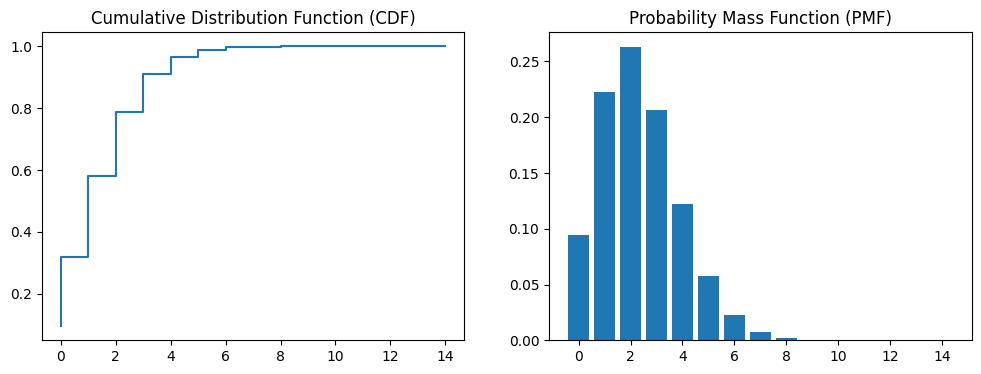



133 vs 132 Distributions
133    0
133    2
133    1
133    3
Name: Goals_Scored_0, dtype: object
132    3
132    1
132    1
132    0
Name: Goals_Scored_0, dtype: object


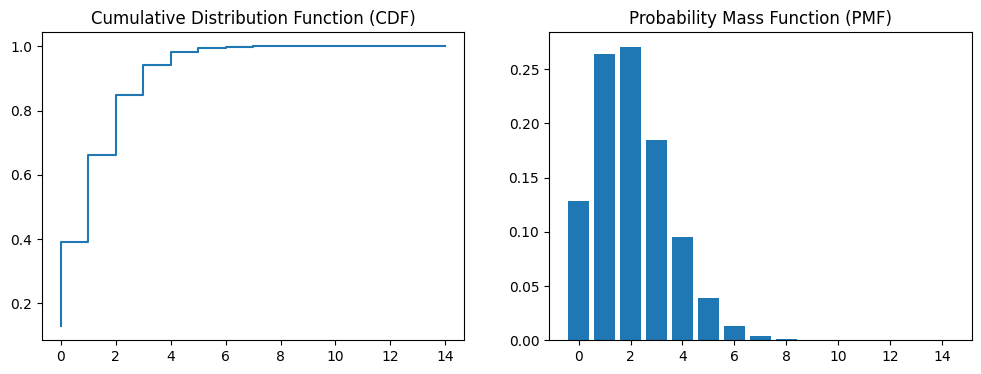

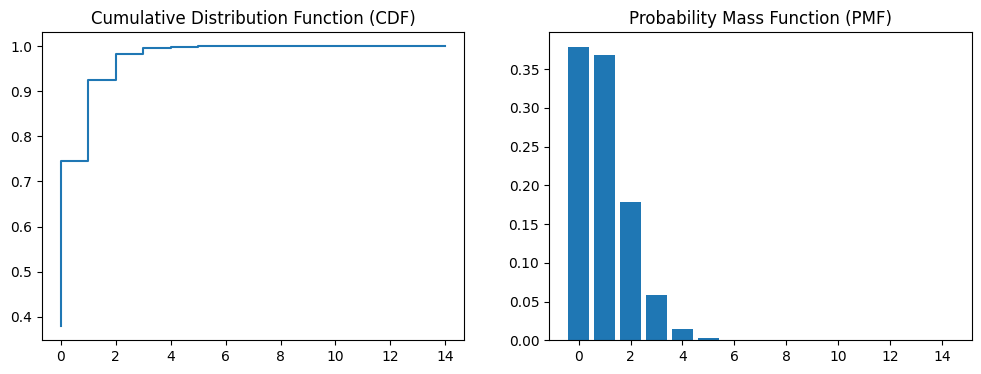



524 vs 525 Distributions
524    0
524    0
524    3
524    0
Name: Goals_Scored_0, dtype: object
525    1
525    1
525    2
525    1
Name: Goals_Scored_0, dtype: object


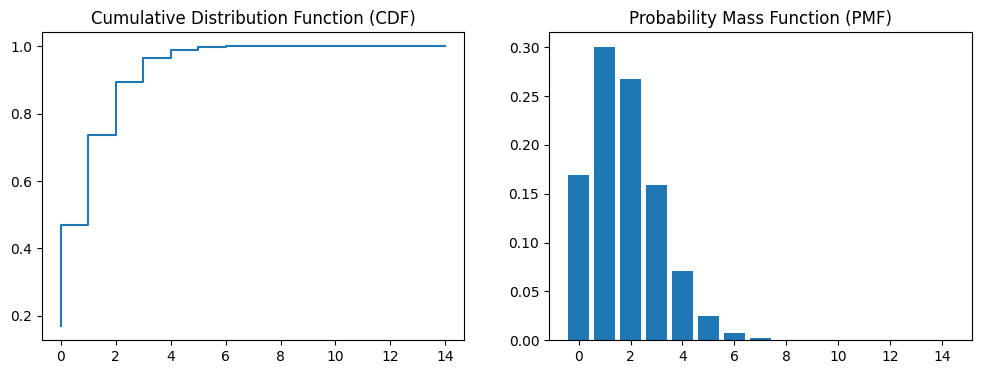

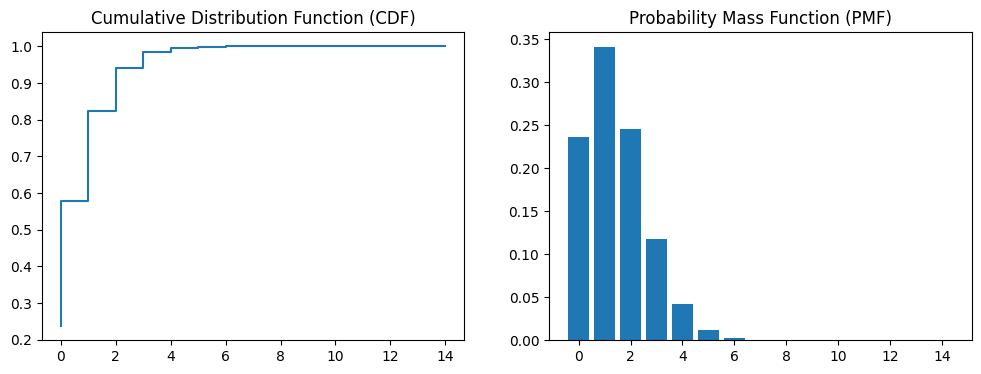



393 vs 392 Distributions
393    2
393    1
393    1
393    0
Name: Goals_Scored_0, dtype: object
392    0
392    2
392    0
392    0
Name: Goals_Scored_0, dtype: object


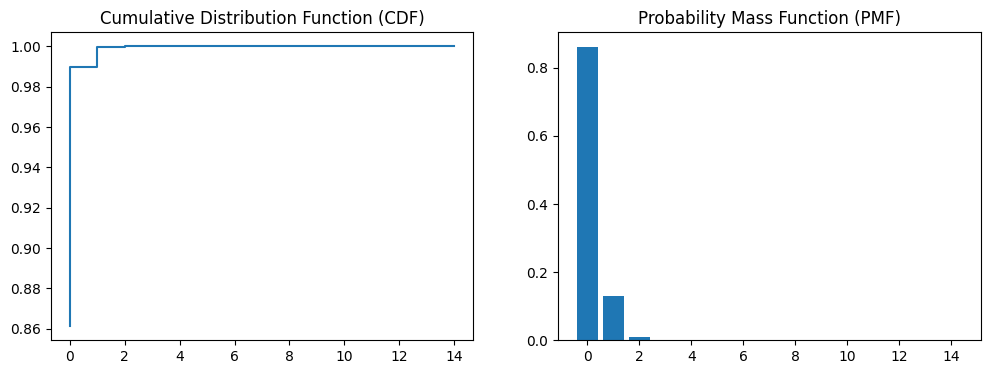

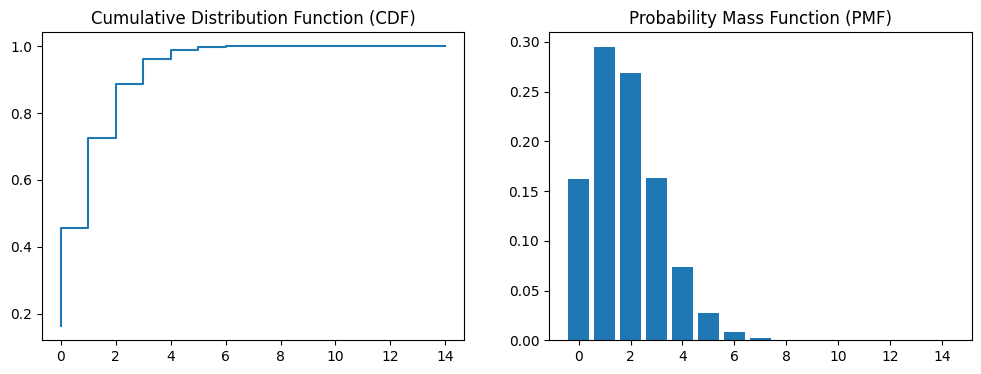



399 vs 398 Distributions
399    2
399    1
399    0
399    1
Name: Goals_Scored_0, dtype: object
398    1
398    1
398    0
398    0
Name: Goals_Scored_0, dtype: object


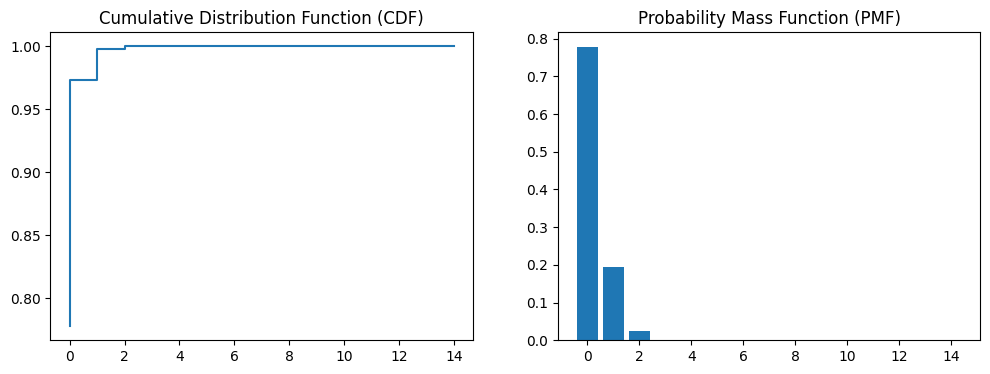

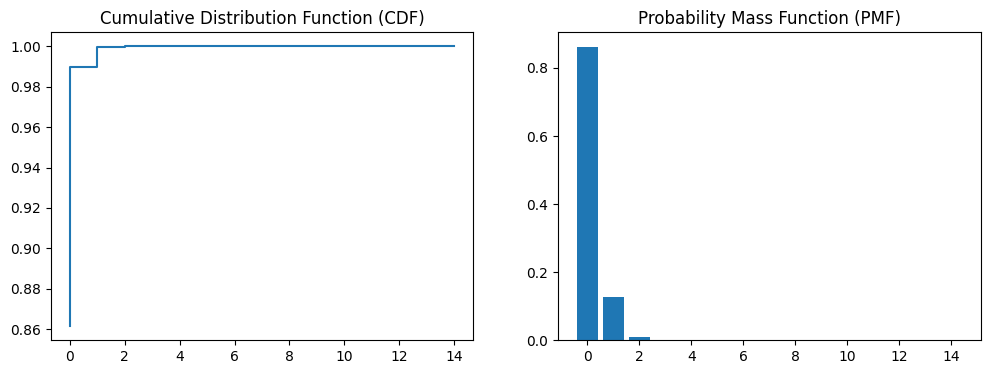



673 vs 672 Distributions
673    2
673    1
673    2
673    1
Name: Goals_Scored_0, dtype: object
672    3
672    1
672    4
672    4
Name: Goals_Scored_0, dtype: object


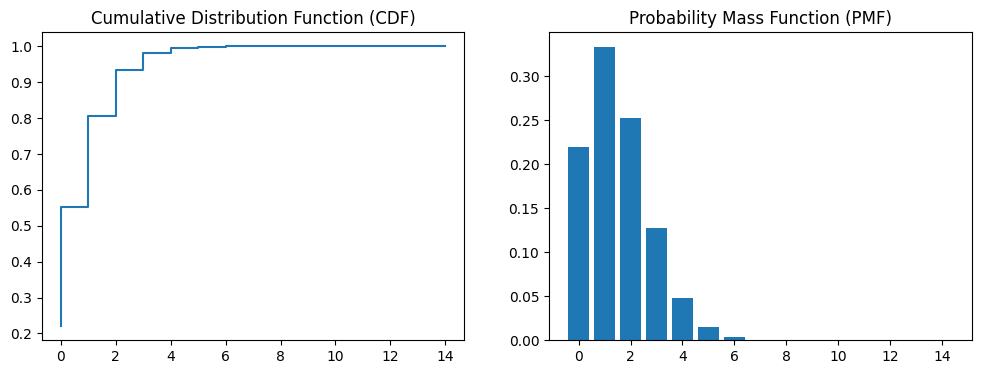

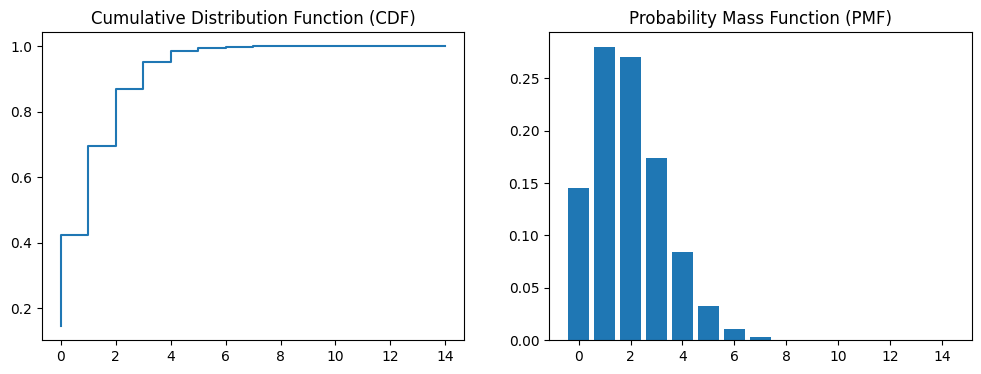



674 vs 675 Distributions
674    0
674    0
674    0
674    0
Name: Goals_Scored_0, dtype: object
675    1
675    0
675    1
675    2
Name: Goals_Scored_0, dtype: object


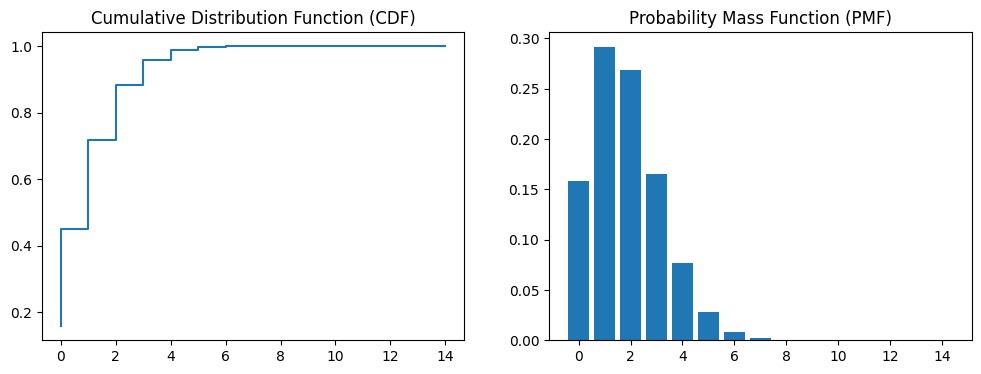

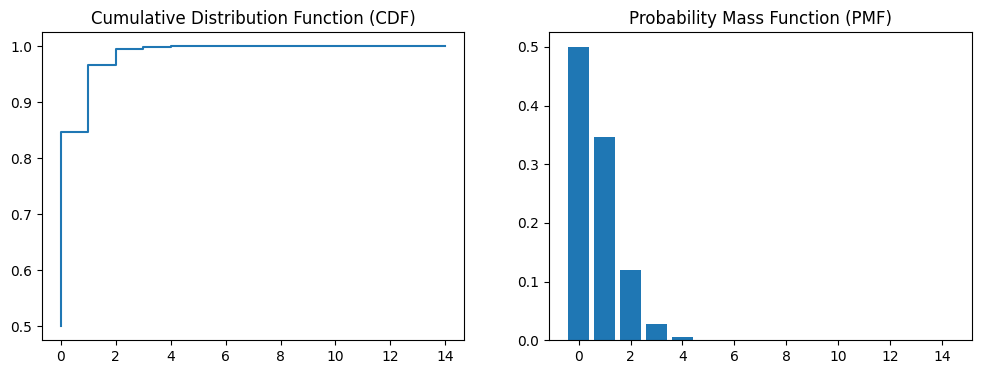



702 vs 703 Distributions
702    1
702    4
702    2
702    1
Name: Goals_Scored_0, dtype: object
703    2
703    1
703    2
703    1
Name: Goals_Scored_0, dtype: object


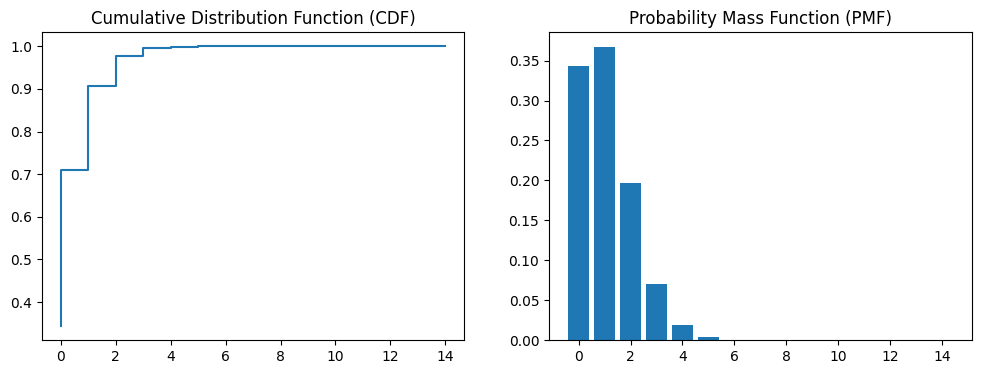

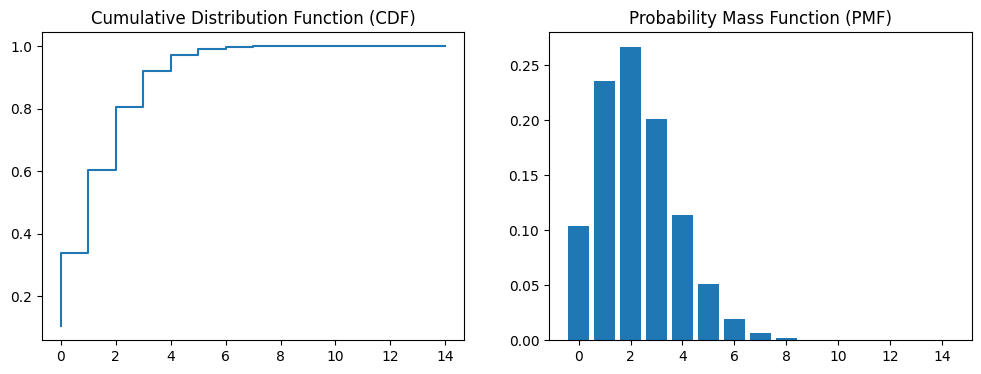



698 vs 699 Distributions
698    0
698    2
698    1
698    0
Name: Goals_Scored_0, dtype: object
699    0
699    0
699    1
699    1
Name: Goals_Scored_0, dtype: object


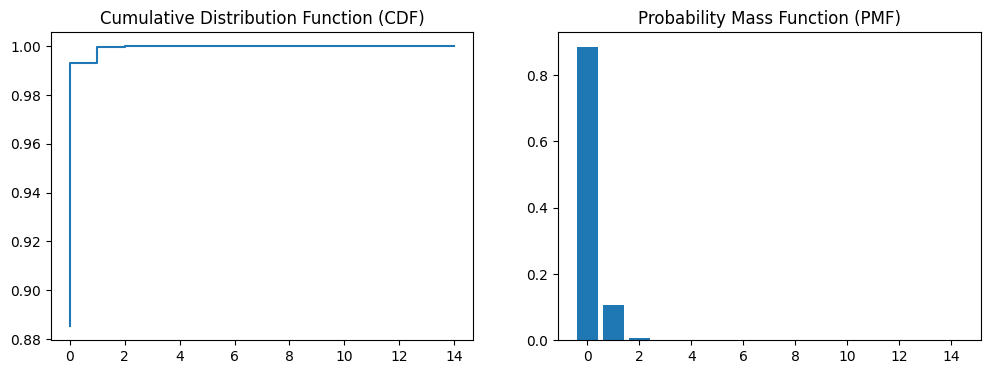

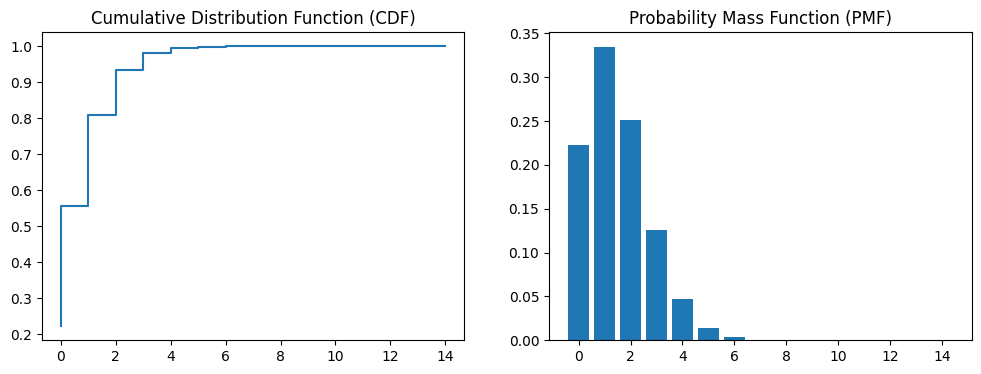



492 vs 493 Distributions
492    3
492    2
492    0
492    1
Name: Goals_Scored_0, dtype: object
493    1
493    0
493    0
493    0
Name: Goals_Scored_0, dtype: object


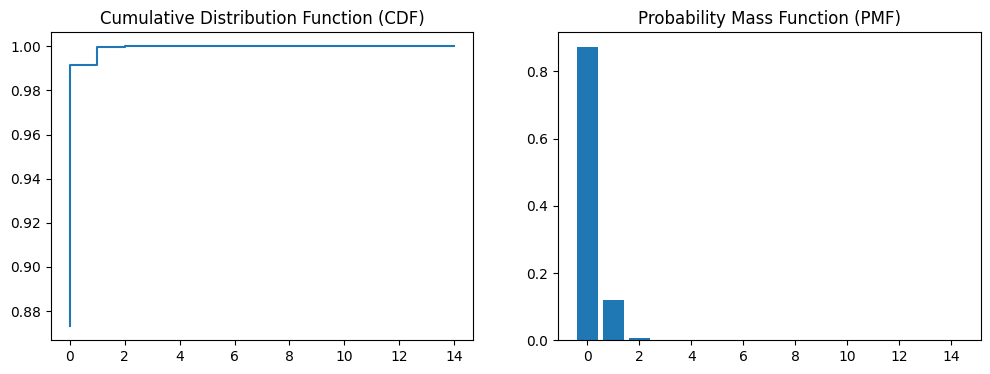

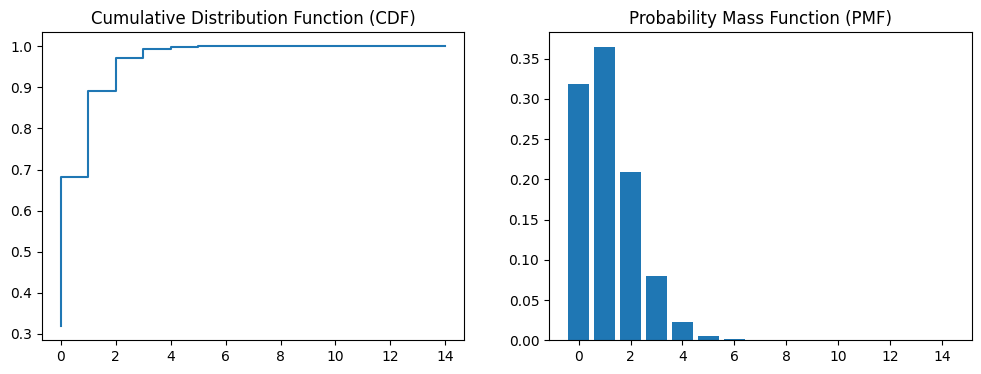



658 vs 659 Distributions
658    0
658    2
658    1
658    1
Name: Goals_Scored_0, dtype: object
659    0
659    1
659    1
659    1
Name: Goals_Scored_0, dtype: object


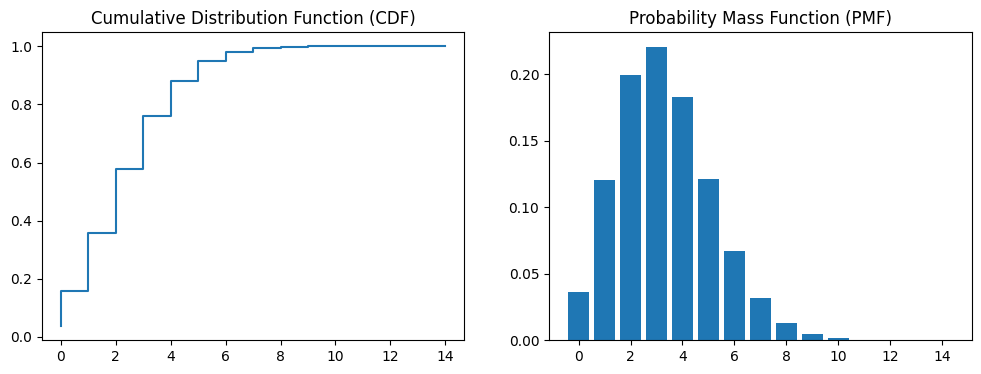

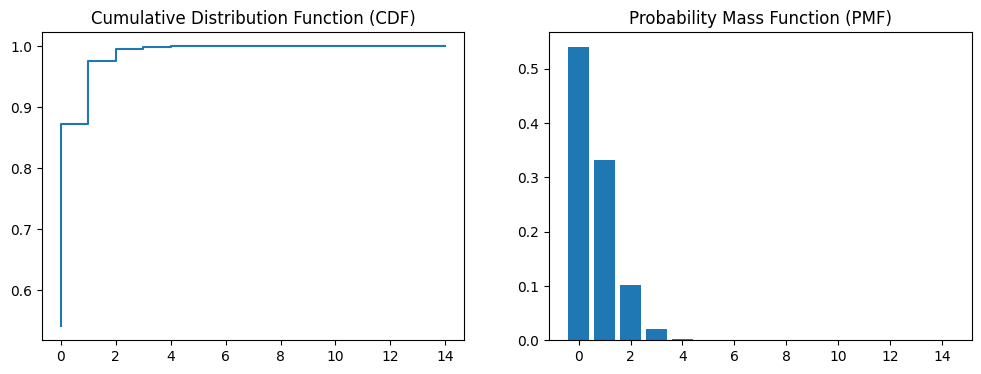



180 vs 181 Distributions
180    0
180    1
180    1
180    1
Name: Goals_Scored_0, dtype: object
181    3
181    3
181    1
181    1
Name: Goals_Scored_0, dtype: object


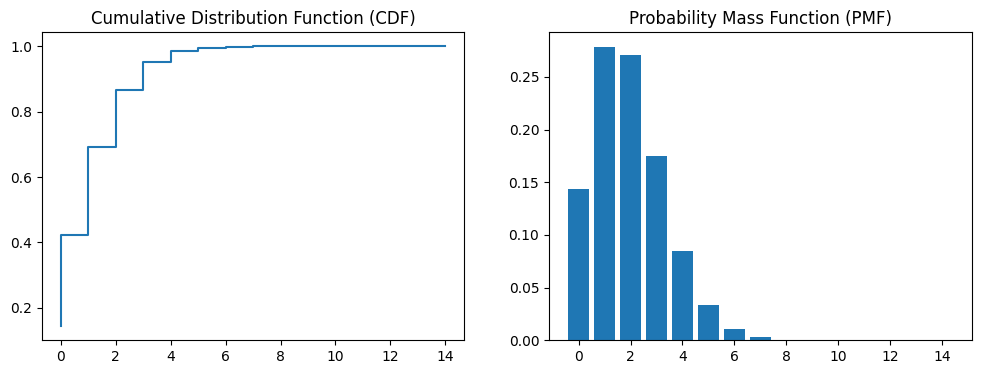

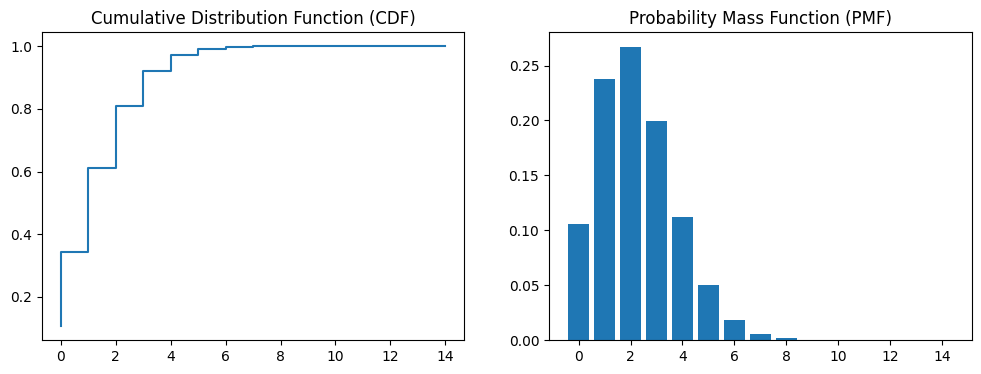



89 vs 88 Distributions
89    1
89    0
89    0
89    0
Name: Goals_Scored_0, dtype: object
88    1
88    1
88    6
88    1
Name: Goals_Scored_0, dtype: object


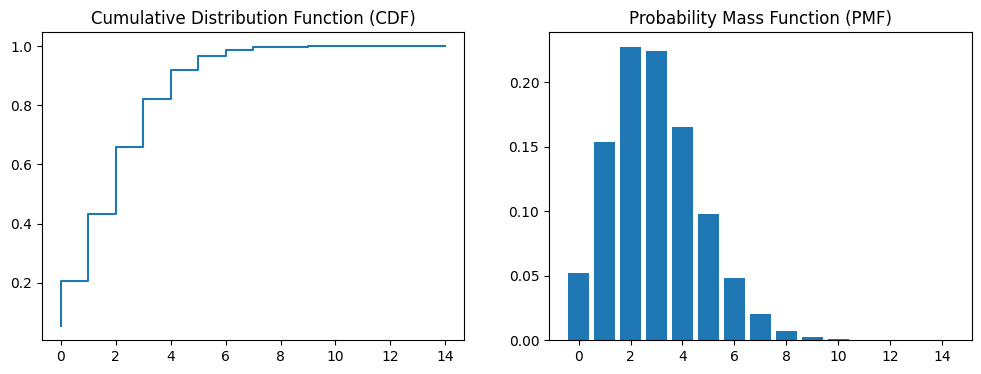

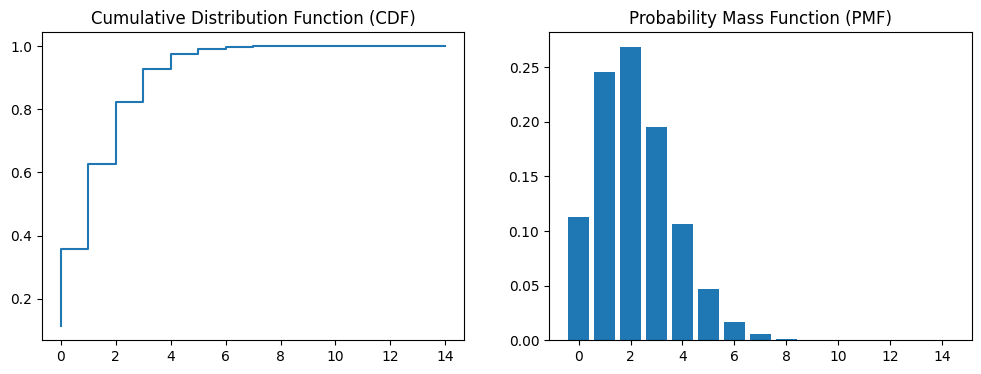



98 vs 99 Distributions
98    2
98    3
98    2
98    0
Name: Goals_Scored_0, dtype: object
99    0
99    1
99    0
99    2
Name: Goals_Scored_0, dtype: object


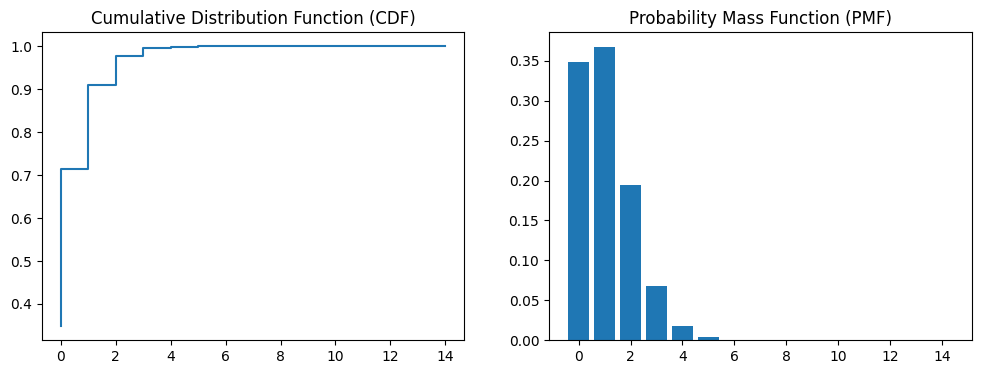

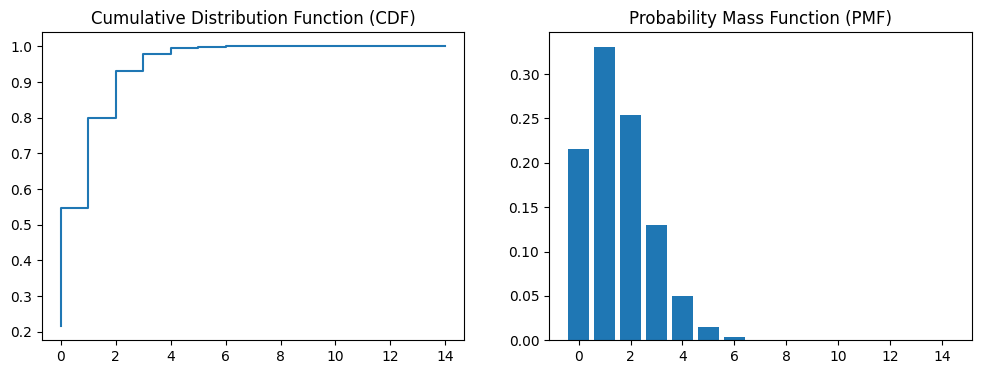



546 vs 547 Distributions
546    0
546    1
546    0
546    2
Name: Goals_Scored_0, dtype: object
547    2
547    1
547    2
547    2
Name: Goals_Scored_0, dtype: object


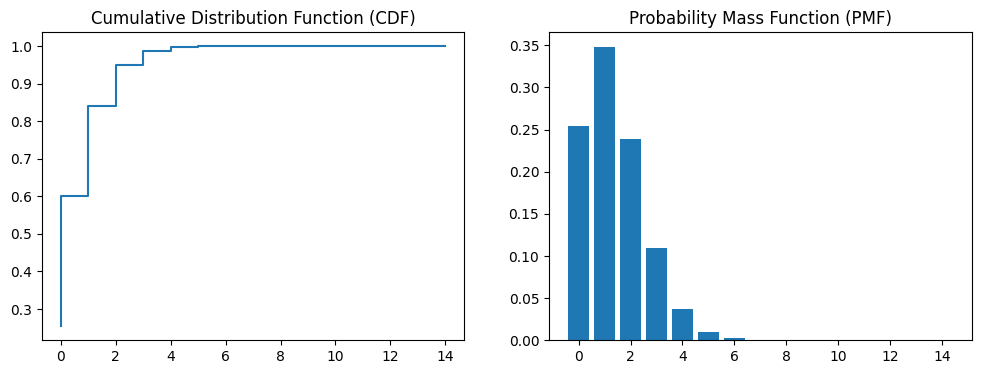

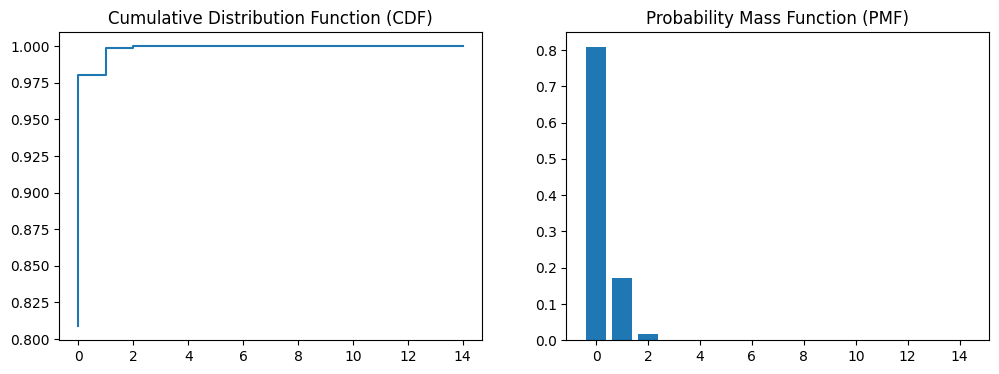



511 vs 510 Distributions
511    3
511    0
511    1
511    0
Name: Goals_Scored_0, dtype: object
510    2
510    1
510    1
510    3
Name: Goals_Scored_0, dtype: object


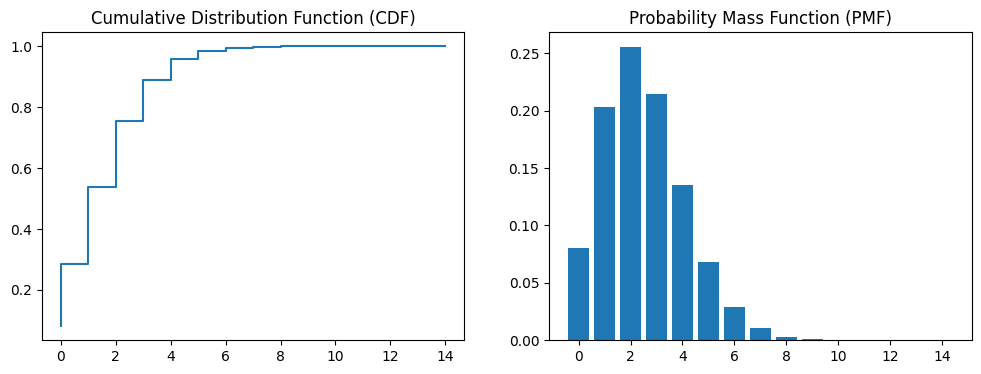

KeyboardInterrupt: 

<Figure size 1200x400 with 0 Axes>

In [197]:
#This doesn't work right now
for game in tqdm(outcomes.index):
    print('{team1} vs {team2} Distributions'.format(team1=game,team2=find_matching_game(game)))
    print(outcomes[game])
    print(outcomes[find_matching_game(game)])
    game_index = list(outcomes.index).index(game)
    matching_game = list(outcomes.index).index(find_matching_game(game))
    game_index_dist= distributions[game_index]
    matching_game_dist = distributions[matching_game]
    
    # Create a range of values to plot the CDF and PDF for
    x = np.arange(0, 15)
    # Plot the CDF and PDF
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].step(x, game_index_dist[0])
    ax[0].set_title("Cumulative Distribution Function (CDF)")
    ax[1].bar(x, game_index_dist[1])
    ax[1].set_title("Probability Mass Function (PMF)")
    plt.show()
    
    x = np.arange(0, 15)
    # Plot the CDF and PDF
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].step(x, matching_game_dist[0])
    ax[0].set_title("Cumulative Distribution Function (CDF)")
    ax[1].bar(x, matching_game_dist[1])
    ax[1].set_title("Probability Mass Function (PMF)")
    plt.show()
    print('\n')
    


    
    
    

In [334]:
odds_df = new_full_df[['win_h','win_a','draw_h','result_h']]

In [335]:
odds_df['result_h'] = odds_df['result_h'].apply(get_result)

/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_1447/2368683440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds_df['result_h'] = odds_df['result_h'].apply(get_result)


In [336]:
X = odds_df.drop('result_h',axis=1)

In [337]:
y = odds_df['result_h']

In [338]:
sc = StandardScaler()

In [339]:
X = sc.fit_transform(X)

In [340]:
X_train, X_test, y_train, y_test= train_test_split(X,y)

In [ ]:
#create streak (rolling window of 7) features for xG, xGA, FPL points
#take for last 7 seasons(max FPL data available)

In [1540]:
df_schedule

Date  HomeTeam Result  AwayTeam
0    2021-08-13         2    2:0         0
1    2021-08-14         4    1:2         3
2    2021-08-14         5    3:0         6
3    2021-08-14         7    3:1        15
4    2021-08-14         9    1:0        19
..          ...       ...    ...       ...
375  2022-05-22         6    1:0        12
376  2022-05-22         9    4:1        15
377  2022-05-22        10    3:1        19
378  2022-05-22        11    3:2         1
379  2022-05-22        14    0:5        16

[380 rows x 4 columns]

In [215]:
#for each game starting after the 6th game, get last 5 for each team, and then try to predict result - outcome - hWin, draw, aWin

In [414]:
games_training = {}
keep_track_lists = []
for i,row in df_schedule.iterrows():
    home = row['HomeTeam']
    away = row['AwayTeam']
    home_df = copy.deepcopy(full_teams_dict[home])
    away_df = copy.deepcopy(full_teams_dict[away])
    home_game_index = home_df[(home_df['Home Team'] == home) & (home_df['Away Team'] == away)].index.tolist()[0]

    away_game_index = away_df[(away_df['Home Team'] == home) & (away_df['Away Team'] == away)].index.tolist()[0]
    
    
    if (away_game_index >4) & (home_game_index > 4):
        combined_df = pd.concat([home_df.loc[home_game_index-5:home_game_index-1].add_prefix('h_').reset_index(drop=True),away_df.loc[away_game_index-5:away_game_index-1].add_prefix('a_').reset_index(drop=True)], axis=1)

        avg_row = combined_df.mean(axis=0)
        avg_row['h_dates'] = home_df['dates'][home_game_index]
        avg_row['a_win'] = away_df['win'][away_game_index]
        avg_row['h_win'] = home_df['win'][home_game_index]
        avg_row['h_draw'] = home_df['draw'][home_game_index]
        avg_row['a_draw'] = away_df['draw'][away_game_index]
        combined_df = combined_df.append(avg_row, ignore_index=True)
        
        
        games_training["{}v{}".format(home,away)] = {}
        games_training["{}v{}".format(home,away)]['data'] = combined_df.drop(['h_Home Team', 'h_Away Team','a_Home Team', 'a_Away Team','a_dates','a_result','h_result','h_Team','a_Team'],axis =1)
        
        #0 home win, 1 draw, 2 away win
        result = home_df['result'][home_game_index].split(":")
        print(result)
        if int(result[0])>int(result[1]):
            result = 0
        elif int(result[0])<int(result[1]):
            result = 2
        else:
            result = 1
        
            
        
        games_training["{}v{}".format(home,away)]['result'] = result
        
        
        
    
    

    


/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avg_row = combined_df.mean(axis=0)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(avg_row, ignore_index=True)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of nume

['3', '3']
['0', '1']
['2', '0']
['1', '2']
['2', '2']
['0', '1']
['1', '1']
['3', '1']
['0', '1']
['1', '1']
['0', '0']
['0', '0']
['3', '1']
['1', '0']
['1', '1']
['2', '1']
['2', '2']
['2', '2']
['2', '1']
['1', '2']
['2', '3']
['0', '1']
['4', '2']
['2', '0']
['0', '0']
['1', '0']
['0', '5']
['0', '1']
['2', '3']
['2', '2']
['3', '1']
['1', '4']
['7', '0']
['1', '1']
['2', '5']
['1', '1']
['2', '2']
['1', '2']
['0', '5']
['1', '0']
['3', '1']
['0', '2']
['2', '2']
['0', '2']
['0', '3']
['0', '3']
['0', '1']
['1', '4']
['1', '2']
['2', '1']
['1', '0']
['1', '2']
['1', '1']
['1', '1']
['2', '0']
['0', '2']
['1', '0']
['0', '0']
['1', '1']
['3', '2']
['2', '0']
['3', '3']
['0', '3']
['4', '0']
['3', '3']


/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avg_row = combined_df.mean(axis=0)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(avg_row, ignore_index=True)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of nume

['2', '1']
['4', '1']
['1', '0']
['3', '0']
['2', '1']
['2', '0']
['0', '0']
['1', '2']
['4', '0']
['0', '0']
['1', '0']
['1', '1']
['4', '2']
['2', '1']
['1', '0']
['1', '1']
['1', '2']
['1', '4']
['2', '2']
['1', '2']
['1', '1']
['0', '0']
['3', '2']
['2', '0']
['1', '0']
['1', '1']
['1', '3']
['3', '2']
['0', '1']
['2', '1']
['2', '2']
['1', '0']
['3', '0']
['2', '1']
['2', '1']
['3', '0']
['3', '2']
['1', '0']
['1', '0']
['0', '1']
['0', '0']
['3', '1']
['4', '0']
['7', '0']
['0', '2']
['2', '0']
['0', '1']
['2', '2']
['1', '1']
['3', '1']
['1', '4']
['0', '4']
['2', '2']
['0', '0']
['1', '3']
['2', '0']
['6', '3']
['0', '5']
['3', '0']
['2', '3']
['1', '1']
['3', '0']
['1', '0']
['1', '1']
['1', '4']
['0', '1']
['1', '1']
['3', '1']
['1', '2']
['2', '3']
['0', '1']
['2', '1']
['2', '2']
['2', '3']
['3', '1']
['0', '1']
['4', '1']
['2', '0']
['1', '1']
['2', '2']
['1', '0']
['1', '1']
['2', '1']
['3', '1']
['3', '0']
['2', '3']
['1', '1']


/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avg_row = combined_df.mean(axis=0)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(avg_row, ignore_index=True)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of nume

['1', '3']
['2', '3']
['0', '3']
['1', '2']
['0', '1']
['0', '1']
['1', '0']
['1', '1']
['0', '0']
['2', '0']
['1', '3']
['1', '1']
['0', '0']
['1', '1']
['3', '1']
['1', '0']
['3', '3']
['2', '0']
['1', '1']
['2', '3']
['2', '0']
['0', '1']
['0', '0']
['3', '0']
['1', '1']
['0', '4']
['0', '2']
['0', '1']
['2', '2']
['1', '0']
['0', '2']
['2', '0']
['2', '1']
['0', '1']
['0', '3']
['0', '1']
['3', '1']
['2', '3']
['2', '0']
['1', '1']
['2', '4']
['2', '1']
['1', '0']
['6', '0']
['1', '4']
['2', '1']
['2', '0']
['0', '2']
['0', '2']
['1', '1']
['0', '1']
['0', '4']
['0', '0']
['1', '0']
['0', '2']
['4', '0']
['0', '4']
['1', '0']
['1', '0']
['2', '1']
['1', '3']
['0', '2']
['4', '1']
['2', '3']
['5', '0']
['0', '3']
['1', '3']
['1', '2']
['4', '0']
['2', '0']


/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avg_row = combined_df.mean(axis=0)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(avg_row, ignore_index=True)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of nume

['0', '2']
['3', '2']
['2', '0']
['1', '0']
['0', '1']
['2', '1']
['1', '2']
['2', '1']
['0', '0']
['0', '2']
['0', '2']
['1', '0']
['2', '3']
['0', '1']
['2', '1']
['3', '1']
['0', '0']
['0', '2']
['1', '4']
['1', '1']
['2', '0']
['1', '1']
['2', '1']
['5', '1']
['2', '1']
['3', '0']
['3', '2']
['1', '0']
['1', '2']
['0', '4']
['1', '0']
['0', '6']
['0', '3']
['2', '0']
['2', '1']
['2', '2']
['2', '0']
['3', '2']
['1', '0']
['0', '1']
['1', '2']
['2', '1']
['1', '1']
['4', '0']
['2', '4']
['1', '1']
['3', '0']
['1', '0']
['2', '0']
['3', '1']
['0', '0']
['0', '0']
['5', '1']
['0', '3']
['2', '2']
['1', '0']
['1', '0']
['2', '0']


/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avg_row = combined_df.mean(axis=0)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(avg_row, ignore_index=True)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of nume

['0', '0']
['1', '1']
['2', '0']
['0', '4']
['0', '1']
['1', '2']
['1', '2']
['0', '3']
['1', '0']
['3', '1']
['1', '2']
['3', '0']
['3', '0']
['4', '0']
['1', '3']
['2', '2']
['1', '0']
['1', '1']
['2', '1']
['1', '2']
['5', '0']
['0', '4']
['1', '2']
['0', '3']
['3', '0']
['0', '0']
['1', '5']
['3', '0']
['1', '1']
['2', '3']
['1', '1']
['1', '0']
['1', '5']
['2', '2']
['1', '1']
['2', '0']
['1', '2']
['1', '1']
['1', '1']
['3', '2']
['5', '1']
['1', '2']
['3', '1']
['1', '2']
['2', '1']
['1', '0']
['4', '1']
['3', '1']
['3', '2']
['0', '5']


/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avg_row = combined_df.mean(axis=0)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(avg_row, ignore_index=True)
/var/folders/1v/6kfsg1sj1h94v2jtztzln6rh0000gn/T/ipykernel_31264/2069889382.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of nume

In [367]:
games_training['19v4']['data']

h_Team xG  h_Team xAG  h_ppda     h_dates  h_points        h_elo  h_draw  \
0       0.90        1.60   15.56  2021-10-23      38.0  1742.436646     248   
1       1.70        1.50    8.50  2021-11-01      41.0  1743.699829     222   
2       0.30        2.00   16.05  2021-11-06      20.0  1750.605225     212   
3       1.40        0.40   21.69  2021-11-20      65.0  1739.312866     227   
4       0.30        1.70   16.00  2021-11-27      56.0  1754.180786     233   
5       0.92        1.44   15.56  2021-12-01      44.0  1746.047070     238   

   h_win  a_Team xG  a_Team xAG  a_ppda  a_points        a_elo  a_draw  a_win  
0    204        0.9        2.20  23.470      20.0  1681.717529     826   2029  
1    123        0.7        1.60   9.730      36.0  1682.898926     265    297  
2    245        2.7        0.80  16.260      54.0  1684.495361     219    163  
3    218        0.7        1.80  15.900      31.0  1694.504395     492   1208  
4    118        1.5        2.00  11.780      44.0  1701.327393     220    185  
5   -104        1.3        1.68  15.428      37.0  1688.988721     238    338